In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
from typing import List, Dict

In [2]:
LOGDIR = '../philly-traces/trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

In [3]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [4]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [5]:
class JobTrace:
    """Encapsulates a job."""
    
    def __init__(self, status, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
    
    def __repr__(self):
        return (f'Job(job_id={self._jobid},\n'
                f'user={self._user},\n'
                f'status={self._status},\n'
                f'num_gpus = {self._num_gpus},\n'
                f'submitted_time = {self._submitted_time},\n'
                f'run_time={self._run_time}\n'
                f'attempts={self._attempts})')
    
    @property
    def status(self):
        return self._status
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

In [6]:
def get_bucket_from_num_gpus(num_gpus):
    """Maps GPU count to a bucket for plotting purposes."""
    if num_gpus is None:
        return None
    if num_gpus == 1:
        return 0
    elif num_gpus >= 2 and num_gpus <= 4:
        return 1
    elif num_gpus >= 5 and num_gpus <= 8:
        return 2
    elif num_gpus > 8:
        return 3
    else:
        return None
    
def get_plot_config_from_bucket(bucket):
    """Returns plotting configuration information."""
    if bucket == 0:
        return ('1', 'green', '-')
    elif bucket == 1:
        return ('2-4', 'blue', '-.')
    elif bucket == 2:
        return ('5-8', 'red', '--')
    elif bucket == 3:
        return ('>8', 'purple', ':')

In [7]:
cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [JobTrace(status=job['status'], jobid=job['jobid'], attempts=job['attempts'], submitted_time=job['submitted_time'], user=job['user']) for job in cluster_job_log]
jobs = sorted(jobs, key=lambda t: t._submitted_time)

/tmp/ipykernel_26099/368235848.py:7: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  dates_df["dates"] = dates_df["dates"].astype("datetime64")


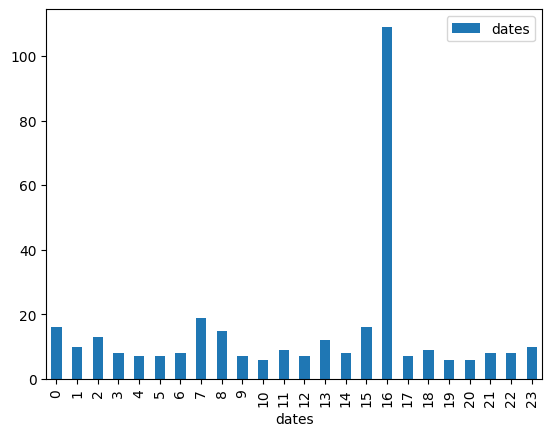

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


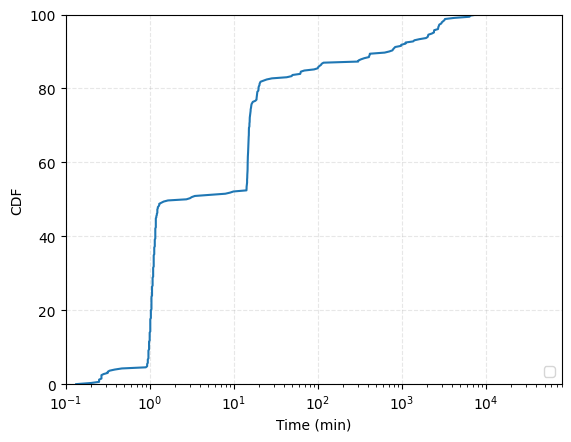

In [8]:
# Filter jobs based on Day
start_day = datetime.datetime(2017, 10, 7)
day_jobs = [j for j in jobs if (j._submitted_time - start_day).days ==0 and j._run_time is not None and j.status == 'Pass']
single_day_jobs = day_jobs
dates = [j._submitted_time for j in day_jobs]
dates_df = pd.DataFrame (dates, columns = ['dates'])
dates_df["dates"] = dates_df["dates"].astype("datetime64")
dates_df.groupby([dates_df["dates"].dt.hour]).count().plot(kind="bar")
plt.show()

# Plotting Job CDF for Phillly Trace
dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        dayrun_times.append(j._run_time)
dayrun_times.sort()
#print(run_times)

# buckets = sorted([bucket for bucket in run_times])
# for bucket in buckets:
#     num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
x, y = get_cdf(dayrun_times)
plt.plot(x, y)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim(10 ** -1, 8* 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

In [9]:
# Preprocessing
day_jobs = single_day_jobs[100:200]#jobs[75000:75200]

#print(len(day_jobs))
deadline_multiplier = 1.05
# Let's do everything in hours (for normalization sake)
starting_time = day_jobs[0]._submitted_time

# Offline Setting
dayjob_arrival_times = [(j._submitted_time- starting_time).seconds/3600.0 for j in day_jobs]

dayrun_times = []
for j in day_jobs:
    if j._run_time is not None and j.status=='Pass':
        if j._run_time > 100:
            dayrun_times.append(500.0)
        else:
            dayrun_times.append(j._run_time)
dayjob_run_times = [j/60.0 for j in dayrun_times]
# print(dayjob_run_times)
# print(dayjob_run_times)
# dayjob_run_times = [j if j <10 else 10 for j in dayjob_run_times]
# asdf = dayjob_run_times.copy()
# asdf.sort()
# print(asdf)
gpu_info = []
for d in day_jobs:
    if len(d.attempts)==0:
        gpu_info.append([{'gpus': ['asdf']}])
    else:
        gpu_info.append(d.attempts[-1]['detail'])

#print(gpu_info)
gpu_count = [sum([len(x['gpus']) for x in y]) for y in gpu_info]
# dayrun_times.sort()
# print([j/60.0 for j in dayrun_times])
# runtime_df = pd.DataFrame(dayrun_times, columns=['runtimes'])
# sns.distplot(runtime_df["runtimes"], bins = 100)
# #plt.xscale('log')
# plt.xlim(10 ** -1, 3*10 ** 3)
# plt.xlabel('Time (min)')
# plt.grid(alpha=.3, linestyle='--')
# plt.show()
# Here jobs can only wait for at max 5% of its runtime
dayjob_dead_times = [dayjob_arrival_times[i] + deadline_multiplier * dayjob_run_times[i] for i, _ in enumerate(dayjob_run_times)]

job_info = [(dayjob_arrival_times[i], dayjob_run_times[i], dayjob_dead_times[i], gpu_count[i]) for i in range(len(dayjob_run_times))]
#job_info = [(dayjob_arrival_times[i], dayjob_run_times[i], dayjob_dead_times[i], 1) for i in range(len(dayjob_run_times))]
print(job_info)

[(0.0, 0.0022222222222222222, 0.0023333333333333335, 2), (0.0075, 0.0044444444444444444, 0.012166666666666666, 2), (0.11138888888888888, 0.01583333333333333, 0.12801388888888887, 1), (0.27805555555555556, 0.020555555555555556, 0.2996388888888889, 1), (0.44472222222222224, 0.016666666666666666, 0.46222222222222226, 1), (0.6113888888888889, 0.017222222222222226, 0.6294722222222222, 1), (0.7783333333333333, 0.019166666666666665, 0.7984583333333333, 1), (0.9447222222222222, 0.018611111111111113, 0.9642638888888889, 1), (1.111388888888889, 0.0175, 1.129763888888889, 1), (1.1291666666666667, 0.05277777777777778, 1.1845833333333333, 1), (1.2780555555555555, 0.017777777777777778, 1.296722222222222, 1), (1.4447222222222222, 0.018333333333333333, 1.4639722222222222, 1), (1.611388888888889, 0.016666666666666666, 1.628888888888889, 1), (1.7780555555555555, 0.01611111111111111, 1.7949722222222222, 1), (1.9447222222222222, 0.017777777777777778, 1.9633888888888889, 1), (2.111388888888889, 0.017222222

In [10]:
from math import floor, ceil

# Time Quantum Converter
# 6 seconds per time quantum (1 hr/600)
TIME_QUANTUM = 1/600.0

# Maximum job time in hours
CLIP_MAX_TIME = 100

# Deadline Multiplier d_t = a_t + K * r_t
DEADLINE_CONSTANT = 1.05

# Returns the deadline of a job.
def deadline_mult_fn(arrival_time, run_time):
    return arrival_time + DEADLINE_CONSTANT * run_time

# Returns the total cost of a job.
def gpu_cost_fn(resources: dict, run_time: float):
    return resources['GPUs'] * run_time

# NUM_GPUS per node: 8
GPUS_PER_NODE = 8

# Num nodes
NUM_NODES = 4

class Job(object):
    def __init__(self, idx, arrival, runtime, deadline, resources, cost):
        self.idx = idx
        self.arrival = arrival
        self.runtime = runtime
        self.deadline = deadline
        self.resources = resources
        self.num_gpus = resources['GPUs']
        self.cost = cost
        
        
        # For finished job stats; If it is None, most likely ran on cloud.
        self.start = None
        self.allocated_gpus = {}
    
    def __eq__(self, other):
        return self.idx == other.idx
        
    def __hash__(self):
        return hash(str(self.idx))
    
    def __repr__(self):
        return f'Job(idx={self.idx}, resources={self.resources}, arr={self.arrival}, run = {self.runtime}, deadline={self.deadline}, start={self.start})\n'

class QJob(Job):
    def __init__(self, idx, arrival, runtime, deadline, resources, cost):
        self.idx = idx
        self.arrival = arrival
        self.runtime = runtime
        self.deadline = deadline
        self.resources = resources
        self.num_gpus = resources['GPUs']
        self.cost = cost
        
        # For finished job stats; If it is None, most likely ran on cloud.
        self.start = None
        self.allocated_gpus = {}
    
    def __repr__(self):
        return f'QJob(idx={self.idx}, resources={self.resources}, arr={self.arrival}, run = {self.runtime}, deadline={self.deadline}, start={self.start})\n'

def preprocess_jobs(jobs: List[JobTrace], deadline_fn= deadline_mult_fn , cost_fn=gpu_cost_fn, clip_time: float = CLIP_MAX_TIME):
    """Converts a list of jobs into (arrival_time, run_time, deadline, resources, cost).
    """
    jobs = jobs.copy()
    
    # Remove invalid jobs (jobs that have not finished and jobs that failed/killed early)
    jobs = [j for j in jobs if j._run_time is not None and j.status=='Pass']
    jobs.sort(key=lambda j: j._submitted_time)
    
    if not clip_time:
        clip_time = 1e9
    
    # Arrival time for jobs
    start_time = jobs[0]._submitted_time
    arrival_times = [(j._submitted_time- start_time).total_seconds()/3600.0 for j in jobs]
    
    # Run time for jobs
    run_times = []
    for j in jobs:
        # Clip the maximum run time for jobs to simplify simulation.
        run_time_hr = j._run_time/60.0
        if run_time_hr > clip_time:
            run_times.append(clip_time)
        else:
            run_times.append(run_time_hr)
    
    deadlines = [deadline_fn(arrival, run) for arrival, run in zip(arrival_times, run_times)]
    
    # Get GPU resources
    resources = []
    for j in jobs:
        detail_dict = j.attempts[-1]['detail']
        gpu_count = sum([len(node_dict['gpus']) for node_dict in detail_dict])
        resources.append({'GPUs': gpu_count})
    
    costs = [cost_fn(res, run) for res, run in zip(resources, run_times)]
    
    return [Job(idx, arr, run, dead, res, cost) \
            for idx, (arr, run, dead, res, cost) in \
            enumerate(list(zip(arrival_times, run_times, deadlines, resources, costs)))]

jobs_subset = single_day_jobs[100:200]  #jobs[50000:55000] #single_day_jobs[100:200]
jobs_proc = preprocess_jobs(jobs_subset)

def quantize_jobs(processed_jobs: List[Job]) -> List[QJob]:
    quantized_jobs = []
    for p_job in processed_jobs:
        arr_q = floor(p_job.arrival/TIME_QUANTUM)
        run_q = ceil(p_job.runtime/TIME_QUANTUM)
        deadline_q = ceil(p_job.deadline/TIME_QUANTUM)
        quantized_jobs.append(QJob(p_job.idx, arr_q, run_q, deadline_q, p_job.resources, p_job.cost))
    return quantized_jobs

quantized_jobs_proc = quantize_jobs(jobs_proc)
max_time_quantum = max([x.arrival + x.runtime for x in quantized_jobs_proc])+1

In [11]:
# Time Quantum Simulator

class Node(object):
    def __init__(self, num_gpus):
        self.num_gpus = num_gpus
        self.gpu_dict = {}
        for idx in range(self.num_gpus):
            self.gpu_dict[idx] = None
    
    def free_gpus(self):
        return len([v for v in self.gpu_dict.values() if not isinstance(v, Job)])
    
    def try_fit(self, cur_timestamp, job, num_gpus=None):
        gpu_list = []
        if num_gpus==None:
            num_gpus = job.resources['GPUs']

        if num_gpus > self.free_gpus():
            return False, gpu_list

        counter =0
        for idx in range(self.num_gpus):
            gpu_val = self.gpu_dict[idx]
            if not isinstance(gpu_val, Job):
                self.gpu_dict[idx] = job
                gpu_list.append(idx)
                counter +=1
            if counter >= num_gpus:
                break
        return True, gpu_list
    
    def clear(self, t):
        s = set()
        for g in self.gpu_dict.keys():
            itm = self.gpu_dict[g]
            if isinstance(itm, Job) and t >= itm.start + itm.runtime:
                self.gpu_dict[g]= None
                s.add(itm)
        return list(s)
    
    def __repr__(self):
        return f'{self.gpu_dict}'        
        

class Cluster(object):
    
    def __init__(self, num_nodes, num_gpus_per_node):
        self.num_nodes = num_nodes
        self.num_gpus_per_node = num_gpus_per_node
        self.nodes = [Node(num_gpus_per_node) for _ in range(num_nodes)]
    
    # Fits on the first node if possible, return False otherwise
    def try_fit(self, cur_timestamp, job):
        num_gpus = job.resources['GPUs']
        if num_gpus <= self.num_gpus_per_node:
            # Bin pack
            for n_idx, n in enumerate(self.nodes):
                can_fit_in_node, gpu_list = n.try_fit(cur_timestamp, job)
                if can_fit_in_node:
                    job.start = cur_timestamp
                    job.allocated_gpus[n_idx] = gpu_list
                    return True
            return False
        else:
            # Gang Schedule (capture on all GPU(s))
            free_gpus_n = [n.free_gpus() for n in self.nodes]
            if num_gpus > sum(free_gpus_n):
                return False

            left_over_gpus = num_gpus%NUM_GPUS_PER_NODE
            for n_idx, n in enumerate(self.nodes):
                _, gpu_list = n.try_fit(cur_timestamp, job, num_gpus=min(free_gpus_n[n_idx], num_gpus))
                num_gpus -= free_gpus_n[n_idx]
                job.allocated_gpus[n_idx] = gpu_list
                if num_gpus <=0:
                    break
            job.start = cur_timestamp
            return True
                
    # Clean jobs that have completed.
    def try_clear(self, t):
        total_jobs = []
        for n in self.nodes:
            total_jobs.extend(n.clear(t))
        return list(set(total_jobs))
    
    def __repr__(self):
        repr_str = 'Cluster State:\n'
        for idx, n in enumerate(self.nodes):
            repr_str += f'Node {idx}: {n}\n'
        return repr_str

    
def simulator(jobs: List[Job], policy: str ='fifo', verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    
    finished_jobs = []
    jobs = copy.deepcopy(jobs)
    num_jobs = len(jobs)

    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=NUM_NODES, num_gpus_per_node=GPUS_PER_NODE)
    t=0
    while len(jobs) >0 or len(queue)>0:
        next_time_list = []
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t >= job.deadline - job.runtime:
                queue.remove(job)
                finished_jobs.append(job)
                cloud_cost += job.cost
        
        # Add jobs to queue that have arrived
        for job in jobs[:]:
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
            elif job.arrival == t:
                jobs.remove(job)
                queue.append(job)
            else:
                break
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        for job in queue[:]:
            if cluster.try_fit(t, job):
                queue.remove(job)
            break
        
        # Skip to next timestep where a new job either arrives or to the next job in queue
        for job in queue[:]:
            next_time_list.append(job.deadline - job.runtime)
            break
        if len(jobs)>0:
            next_time_list.append(jobs[0].arrival)
        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        prior_t = t
        t = min(next_time_list) if next_time_list else t
        if prior_t == t and (not jobs):
            t = t+1
    finished_jobs.extend(cluster.try_clear(1e12))
    print(cloud_cost)
    return cloud_cost, finished_jobs



algs = ['fifo', 'edf', 'ljf', 'lvjf']
results = {}
for alg in algs:
    results[alg] = simulator(jobs_proc, policy=alg, verbose=False)

1659.9483333333333
1659.2794444444444
1659.9483333333335
1659.9483333333333


In [12]:
def q_simulator(q_jobs: List[QJob], policy: str ='fifo', verbose=False, debug=False):
    if policy=='fifo':
        sort_func = lambda x: x.arrival
    elif policy == 'edf':
        sort_func = lambda x: x.deadline
    elif policy == 'ljf':
        sort_func = lambda x: -x.runtime
    elif policy == 'lvjf':
        sort_func = lambda x: -x.cost
    
    finished_jobs = []
    q_jobs = copy.deepcopy(q_jobs)
    num_jobs = len(q_jobs)
    run_logs = []
    
    max_time_quantum = max([x.deadline-x.runtime for x in q_jobs])+2
    queue = []
    cloud_cost = 0
    cluster = Cluster(num_nodes=NUM_NODES, num_gpus_per_node=GPUS_PER_NODE)
    t=0
    while len(finished_jobs) < num_jobs:
        # Clear cluster of jobs that have completed
        finished_jobs.extend(cluster.try_clear(t))
        # Check for jobs that have waited too long (move to cloud).
        for job in queue[:]:
            if t > job.deadline - job.runtime:
                queue.remove(job)
                finished_jobs.append(job)
                cloud_cost += job.cost

        # Add jobs to queue that have arrived
        arrive = False
        for job in q_jobs[:]:
            if job.arrival < t:
                raise ValueError("Should not have entered here!")
            elif job.arrival == t:
                q_jobs.remove(job)
                queue.append(job)
                arrive = False
            else:
                break
                
        # Sort queue based on heuristic
        queue.sort(key = sort_func)
        
        # Go through queue and fit jobs onto cluster as needed
        for job in queue[:]:
            if cluster.try_fit(t, job):
                queue.remove(job)
            break

        if verbose or debug:
            print(f'Timestamp: {t}')
            print(f'Jobs left: {len(q_jobs)}')
            print(f'Cloud Cost: {cloud_cost}')
            print(cluster)
            print('Queue: ' + str(queue) + '\n')
            print('Finished Jobs: ' + str(finished_jobs) + '\n')
            if debug:
                import pdb; pdb.set_trace()
        t+=1
    finished_jobs.extend(cluster.try_clear(1e12))
    print(cloud_cost)
    return cloud_cost, finished_jobs

algs = ['fifo', 'edf', 'ljf', 'lvjf']
q_results = {}
for alg in algs:
    q_results[alg] = q_simulator(quantized_jobs_proc, policy=alg, verbose=False, debug=False)
    

1377.9772222222223
1377.3166666666666
1377.9772222222223
1377.9772222222223


all


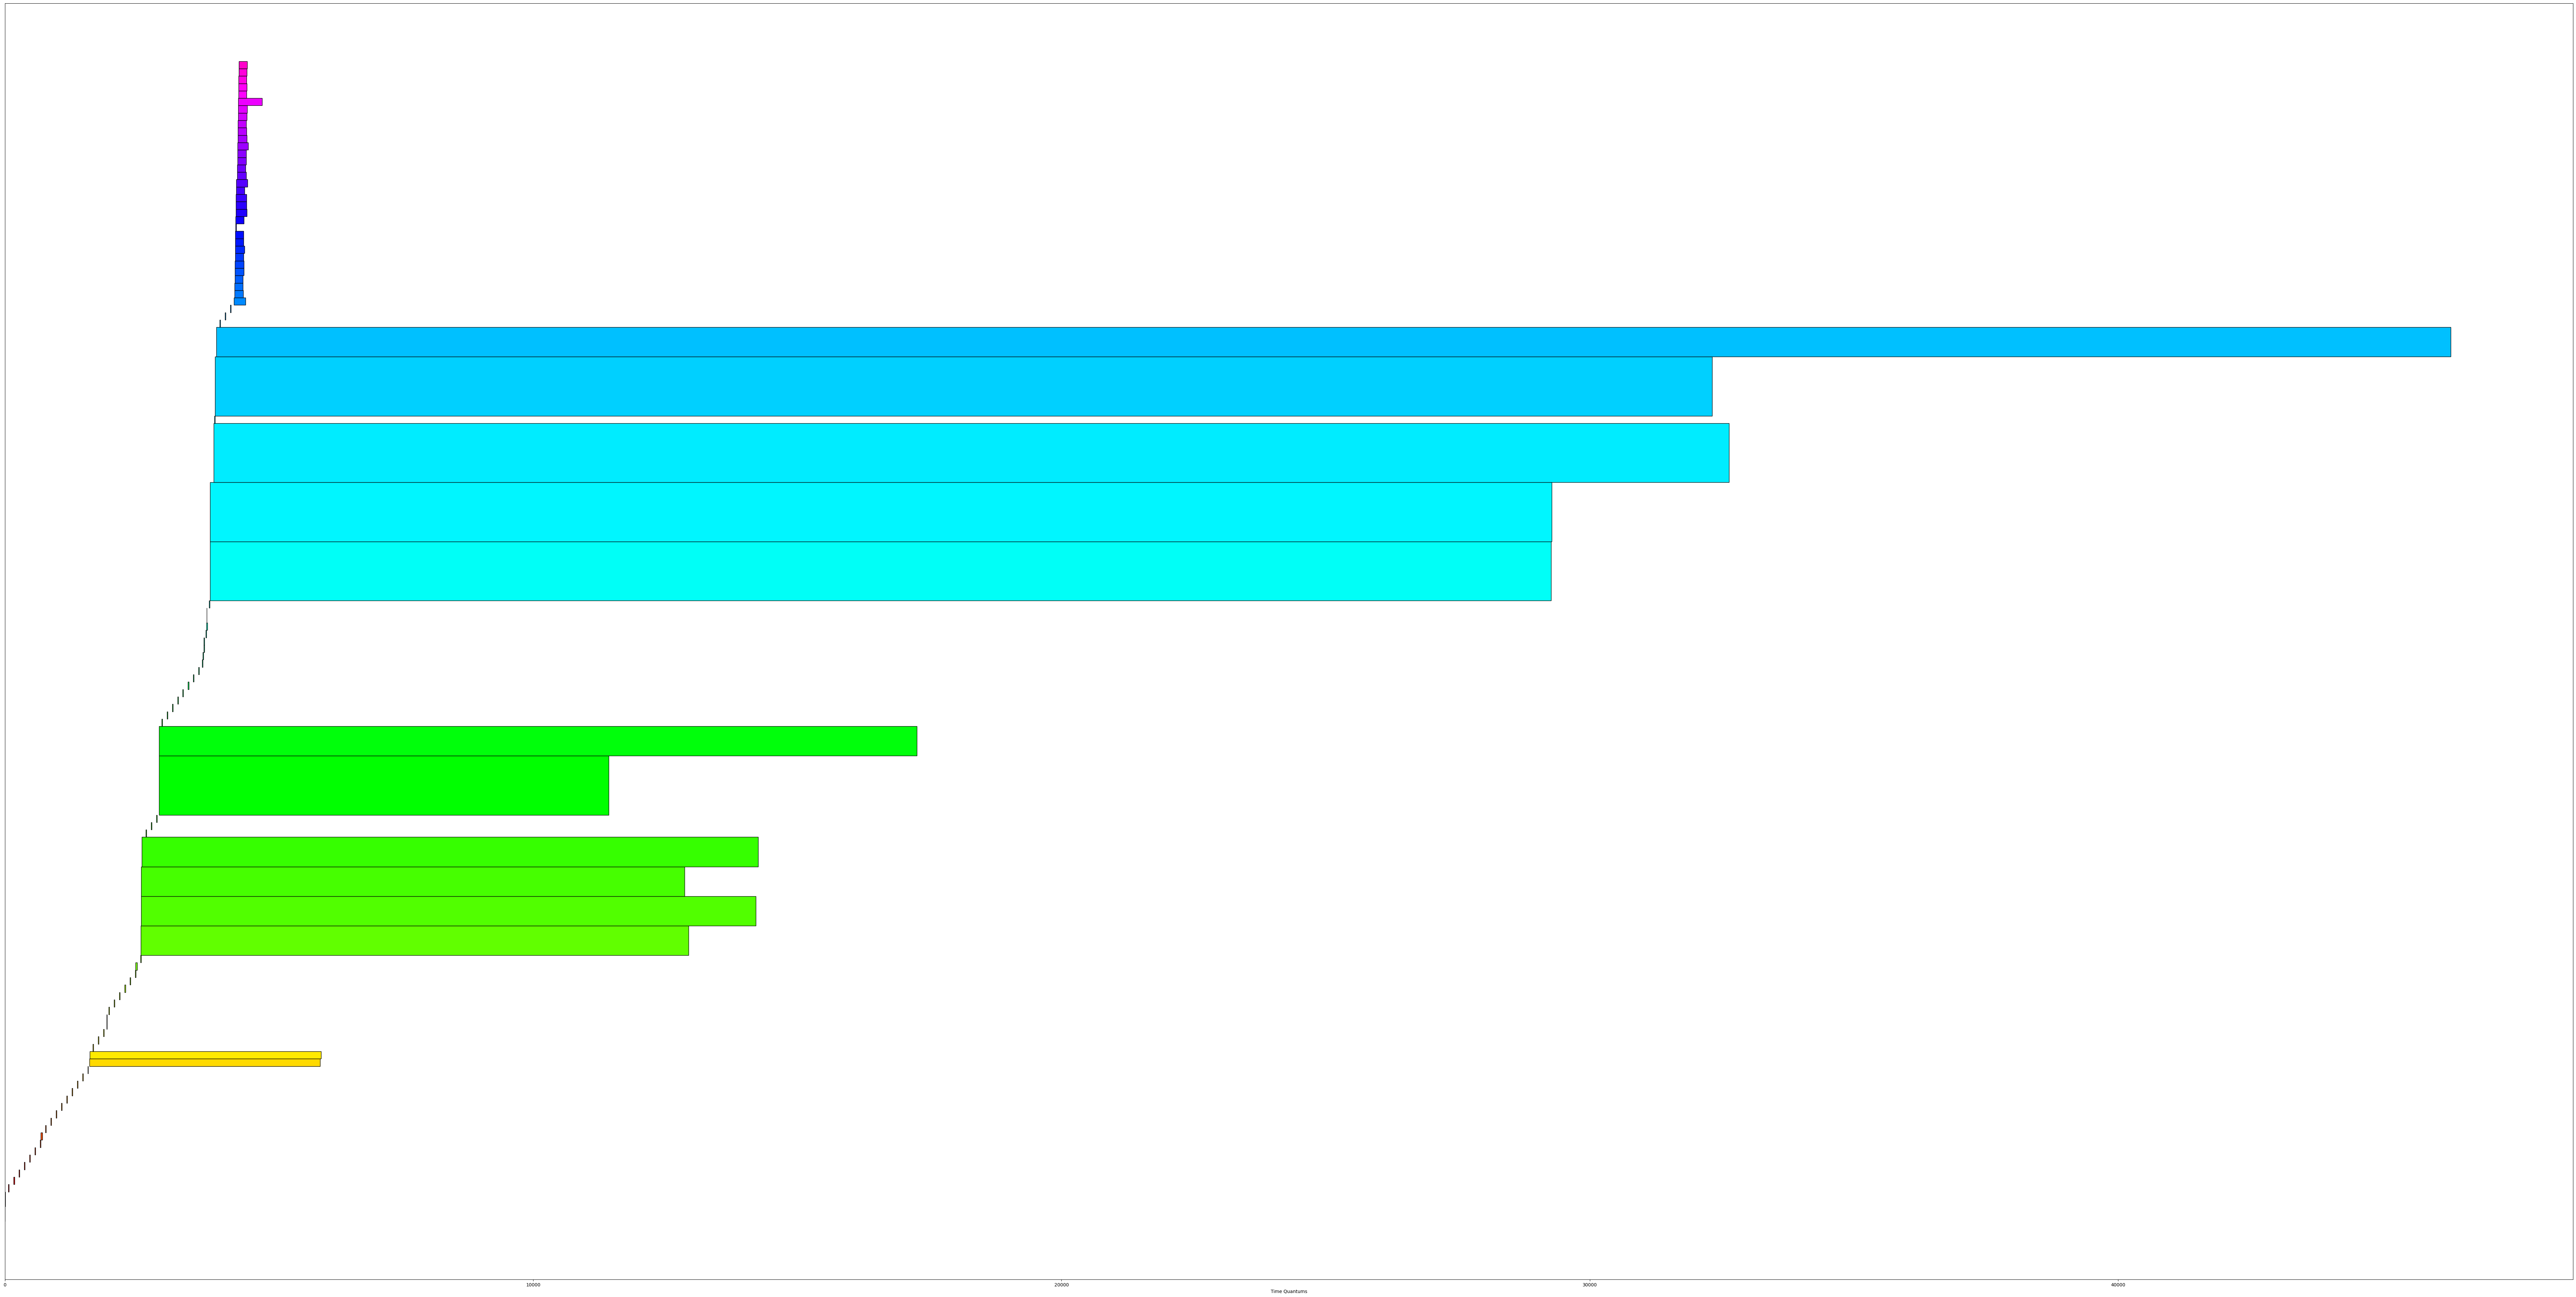

fifo-cloud


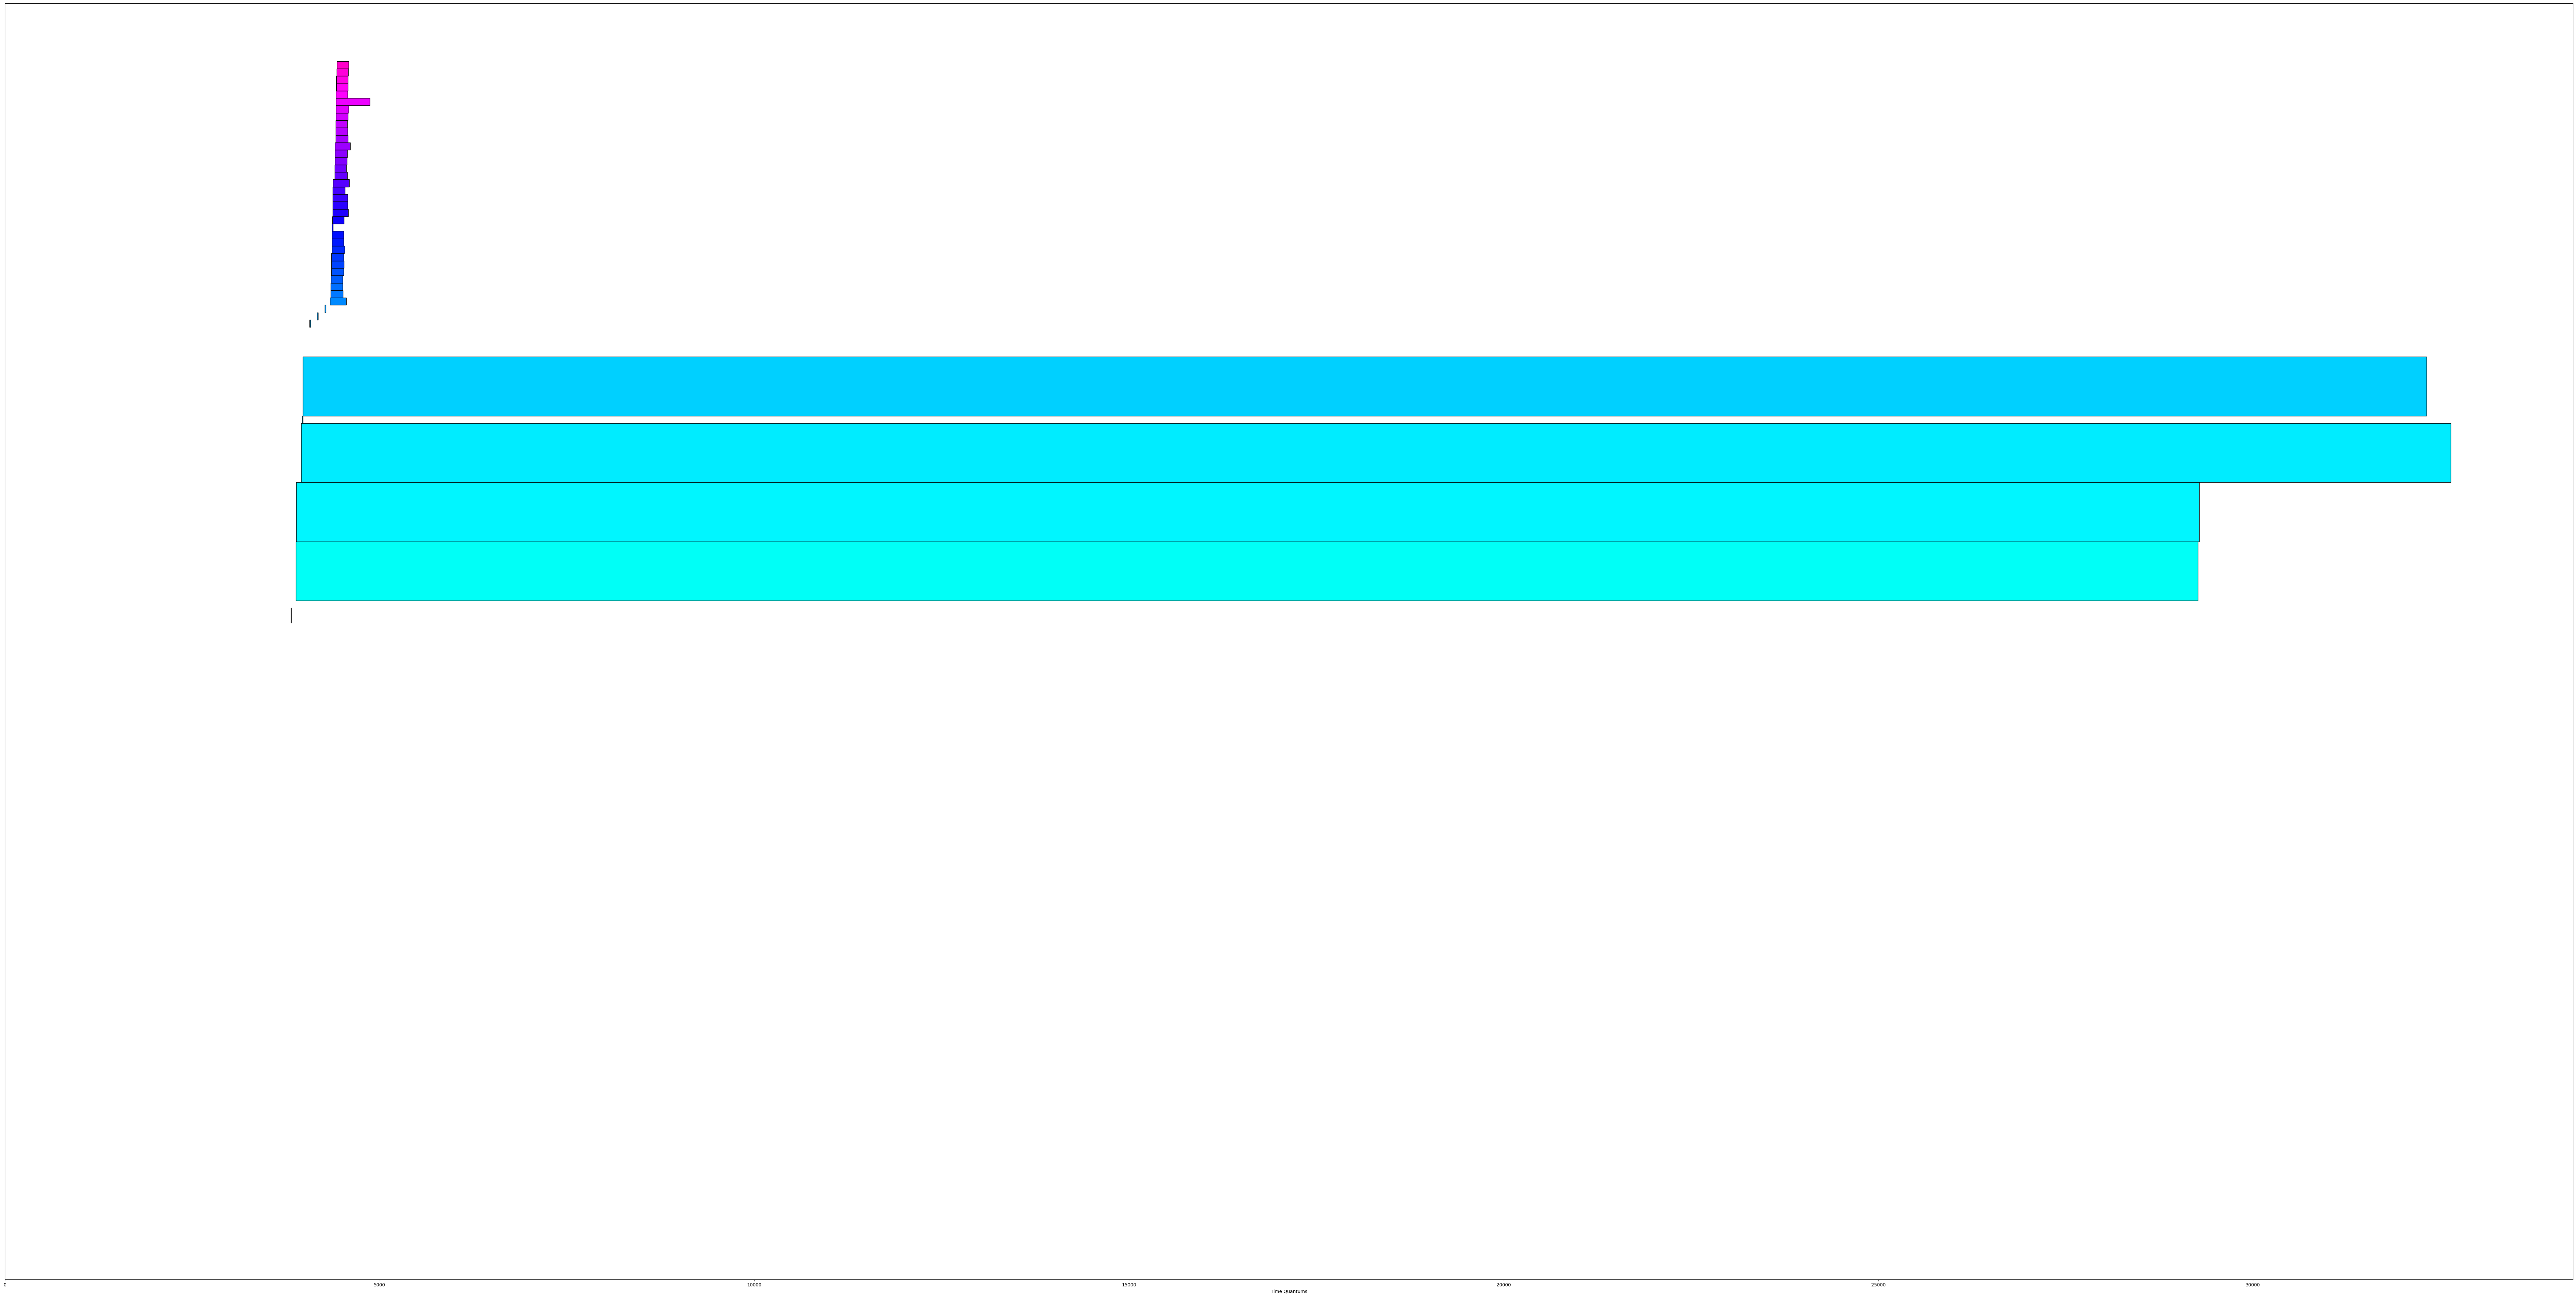

fifo-local


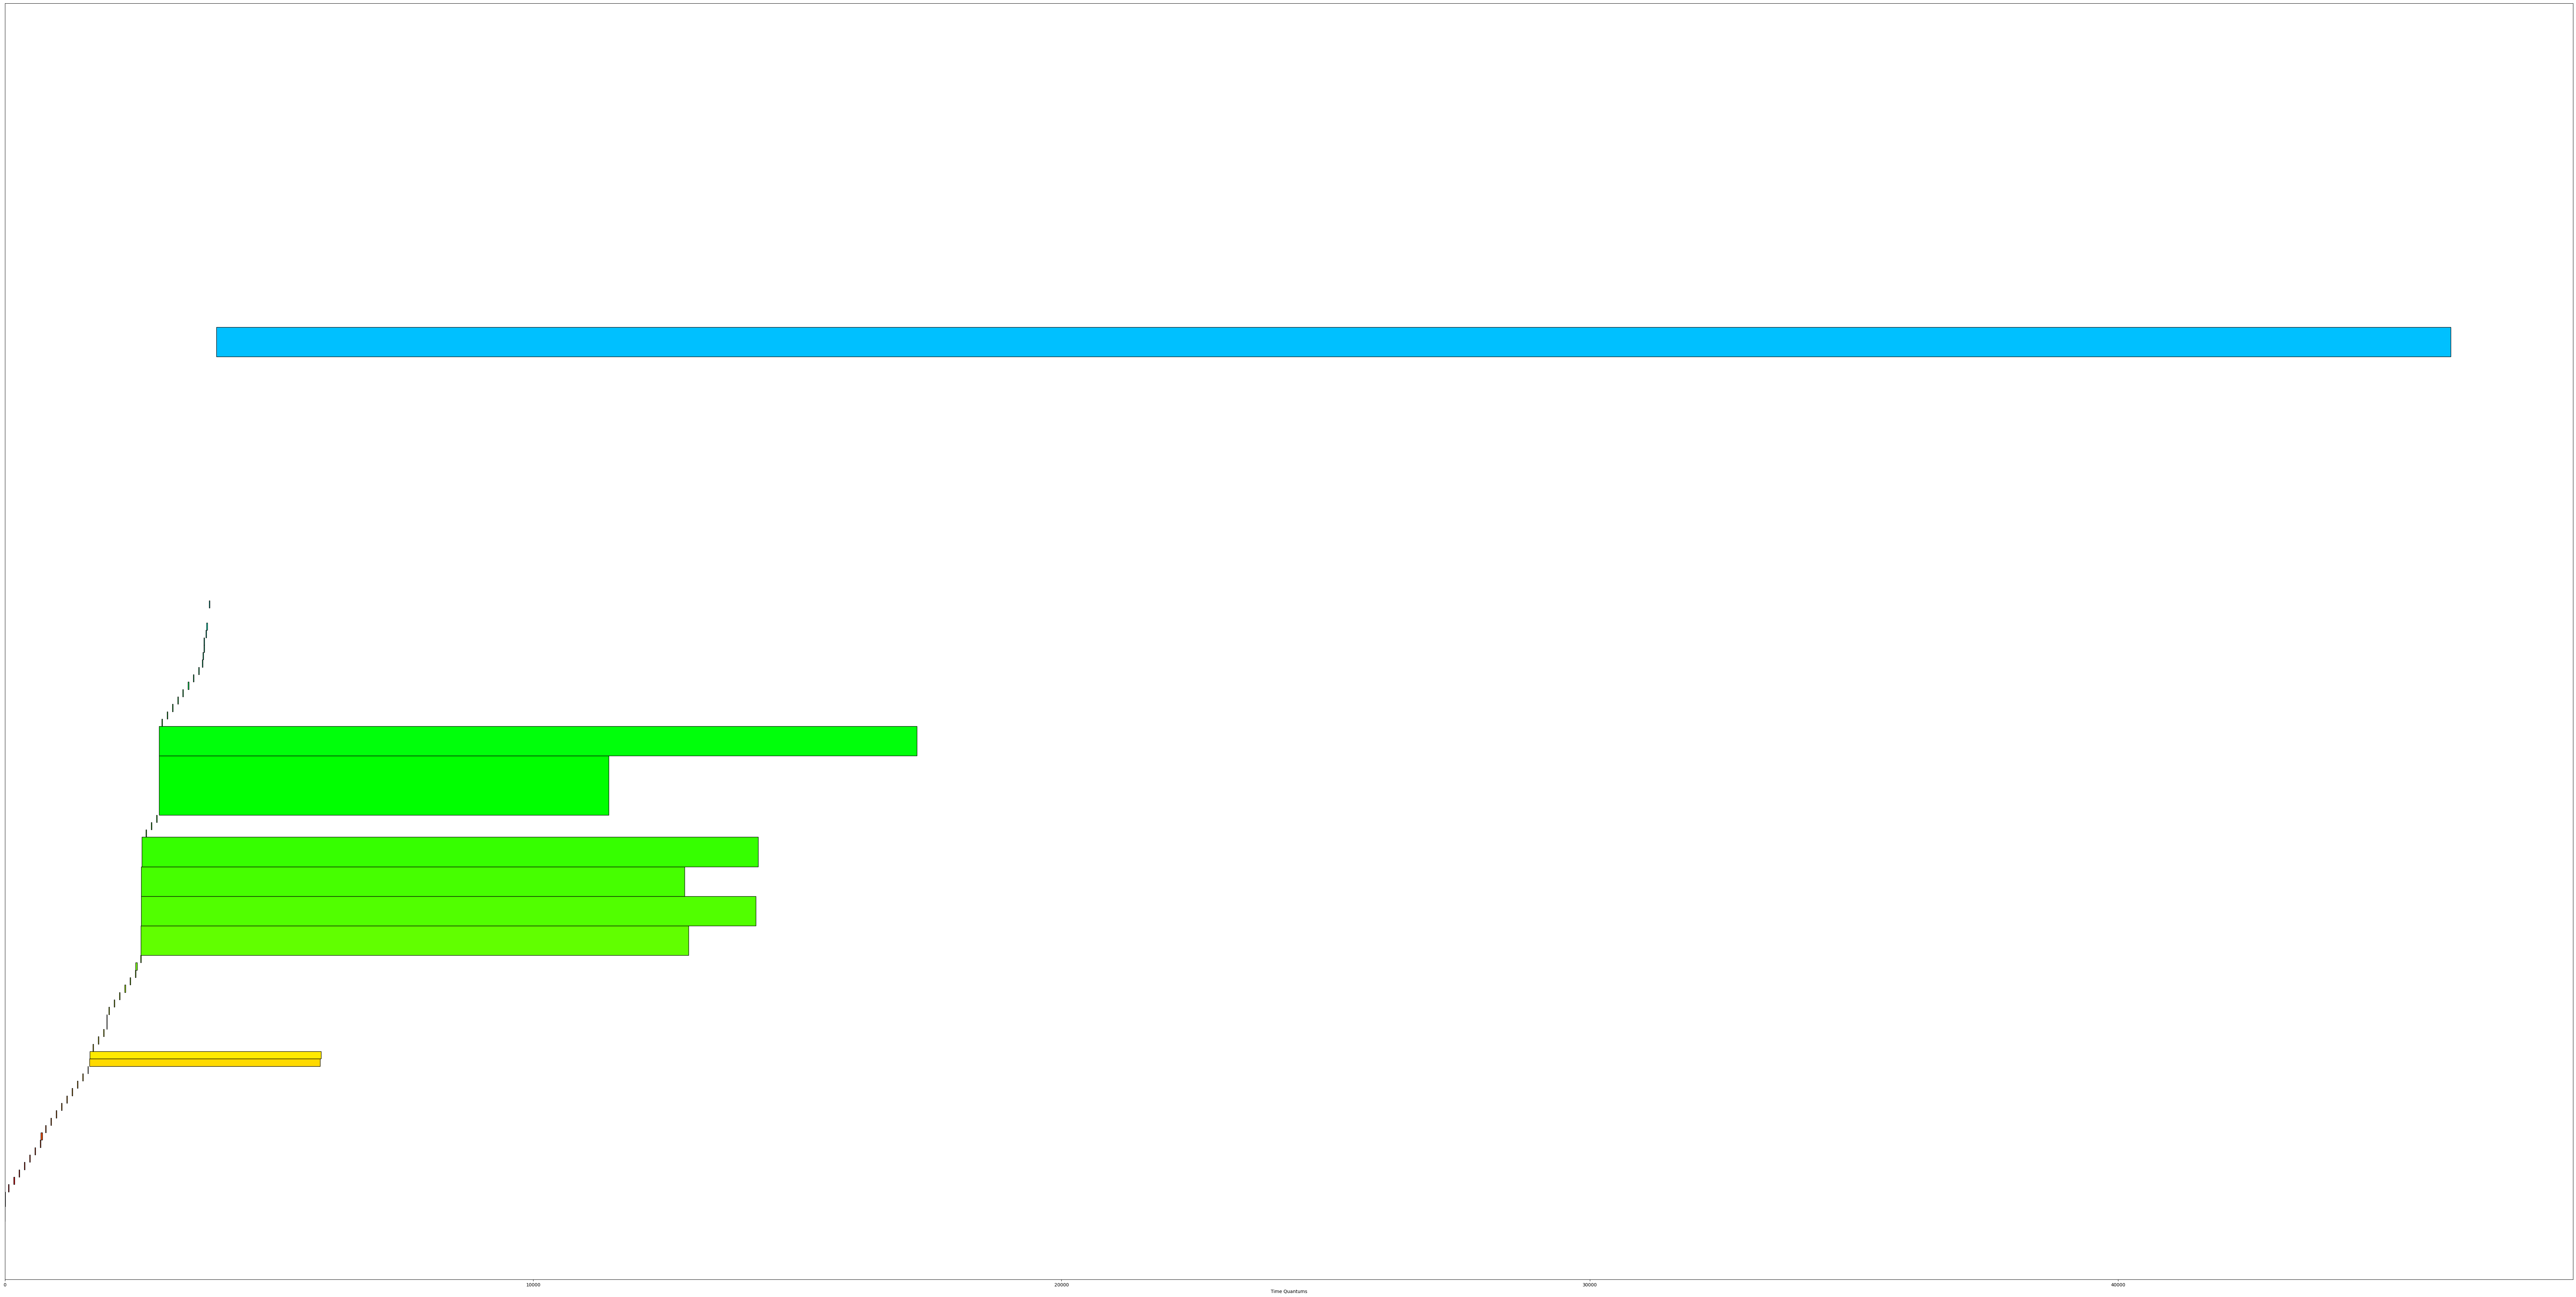

edf-cloud


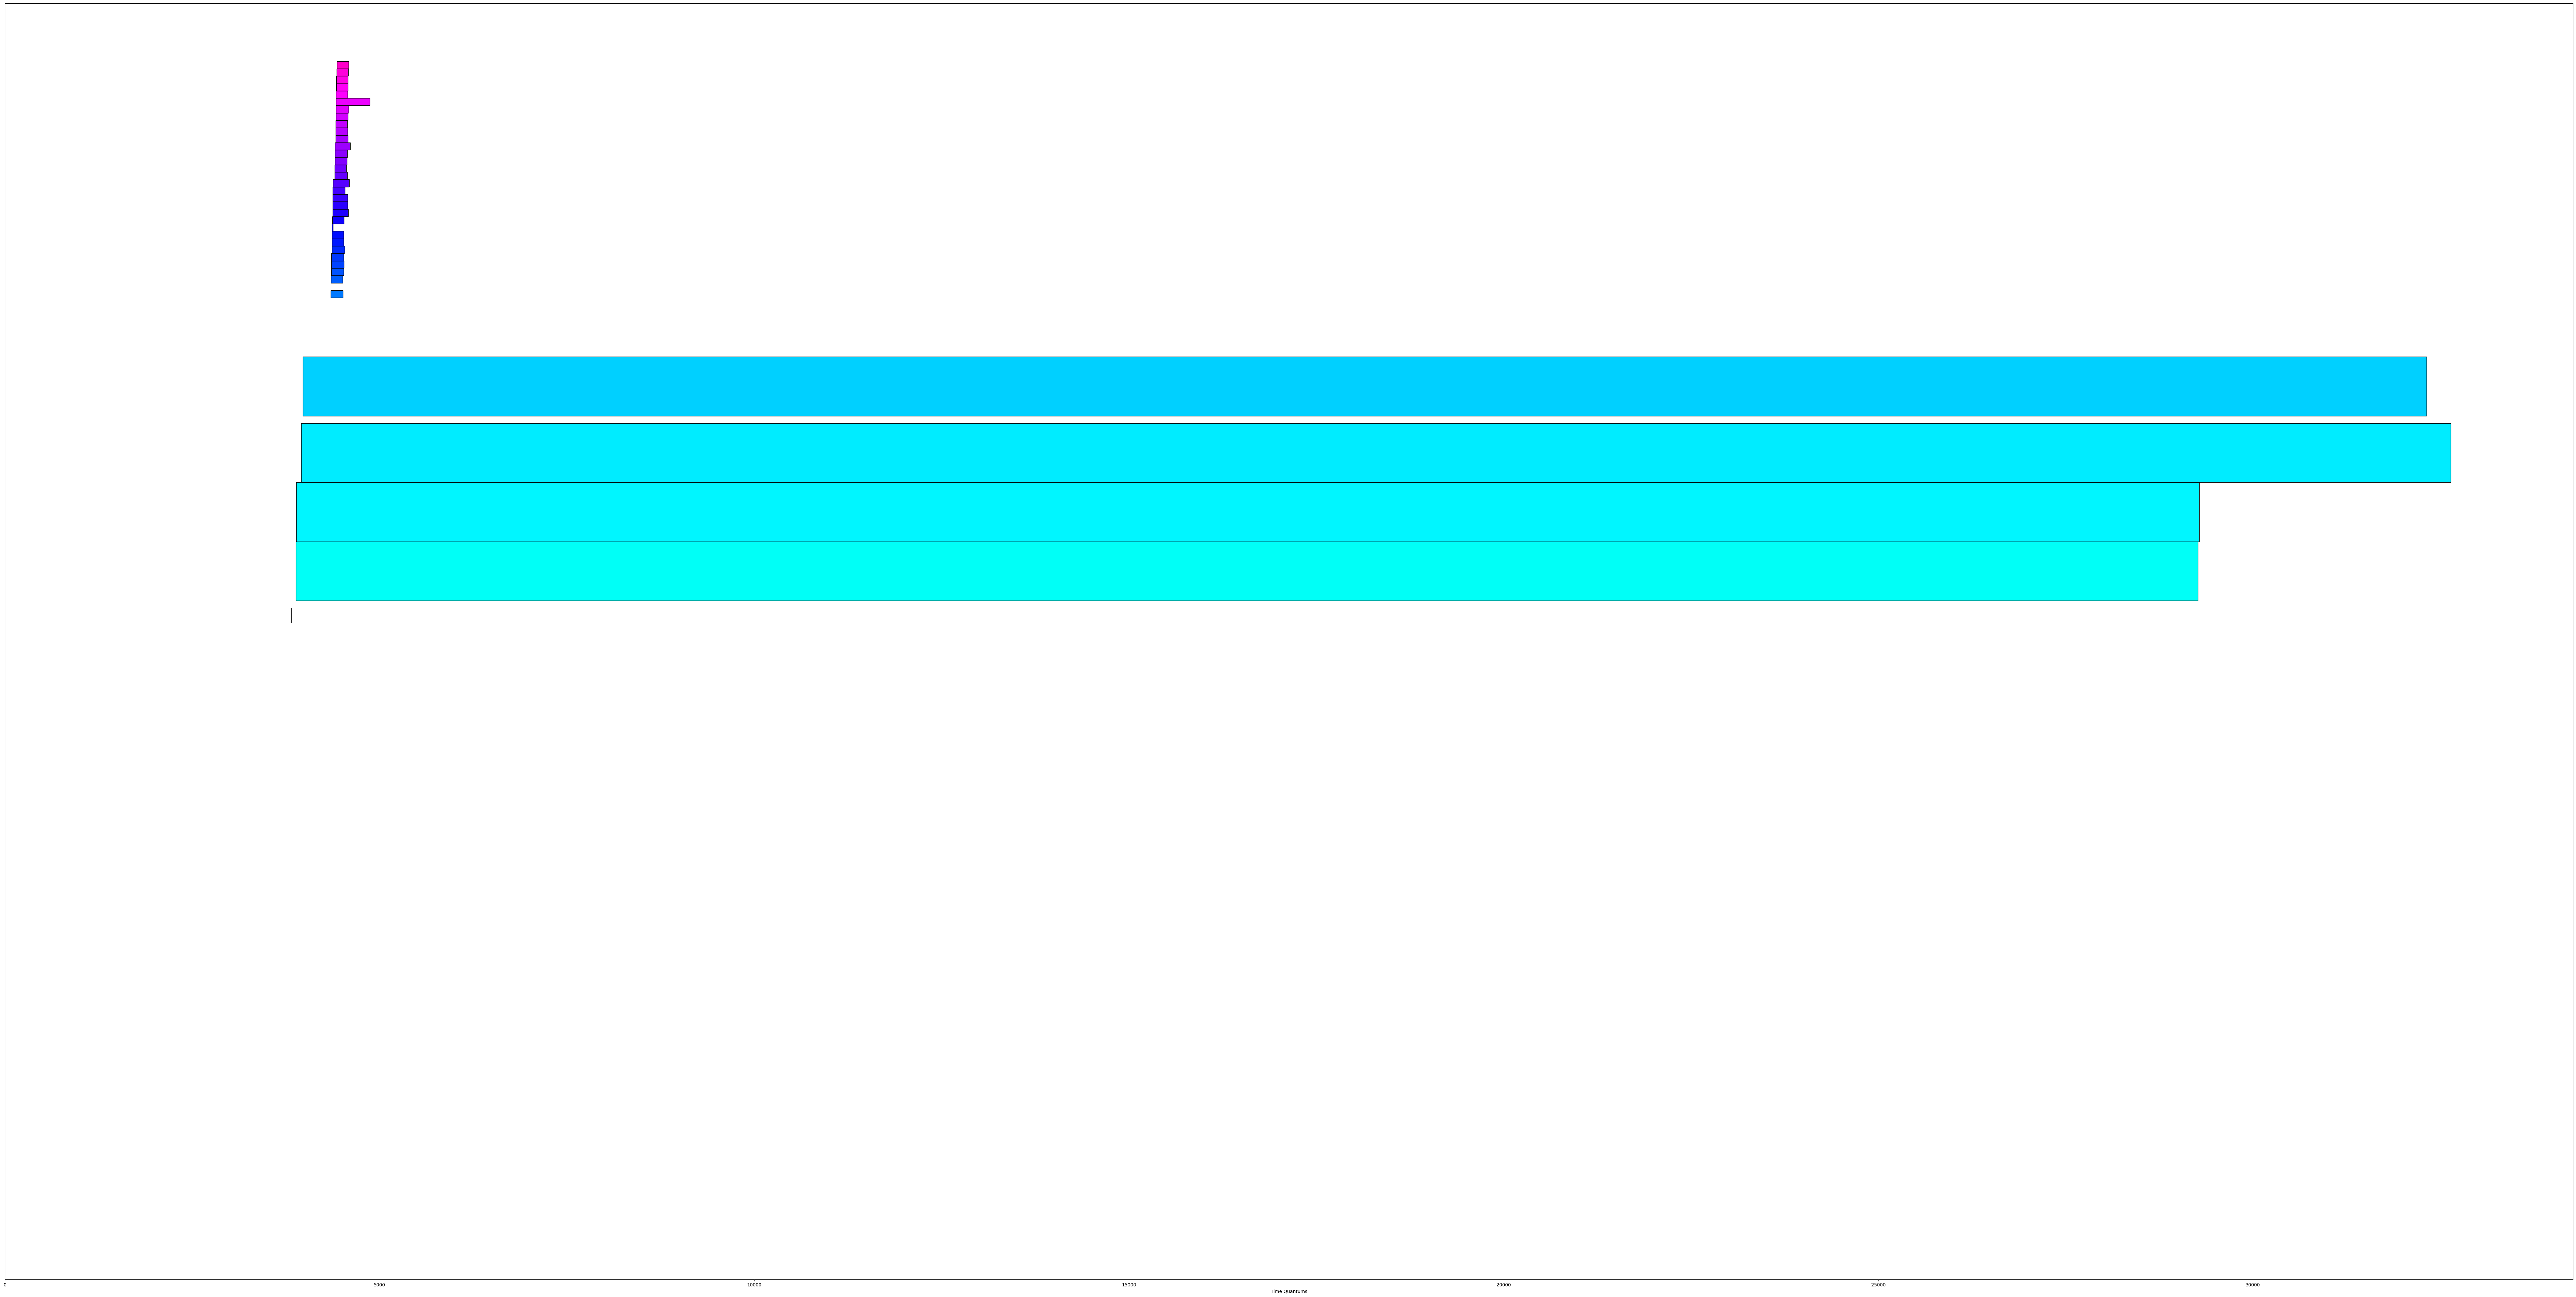

edf-local


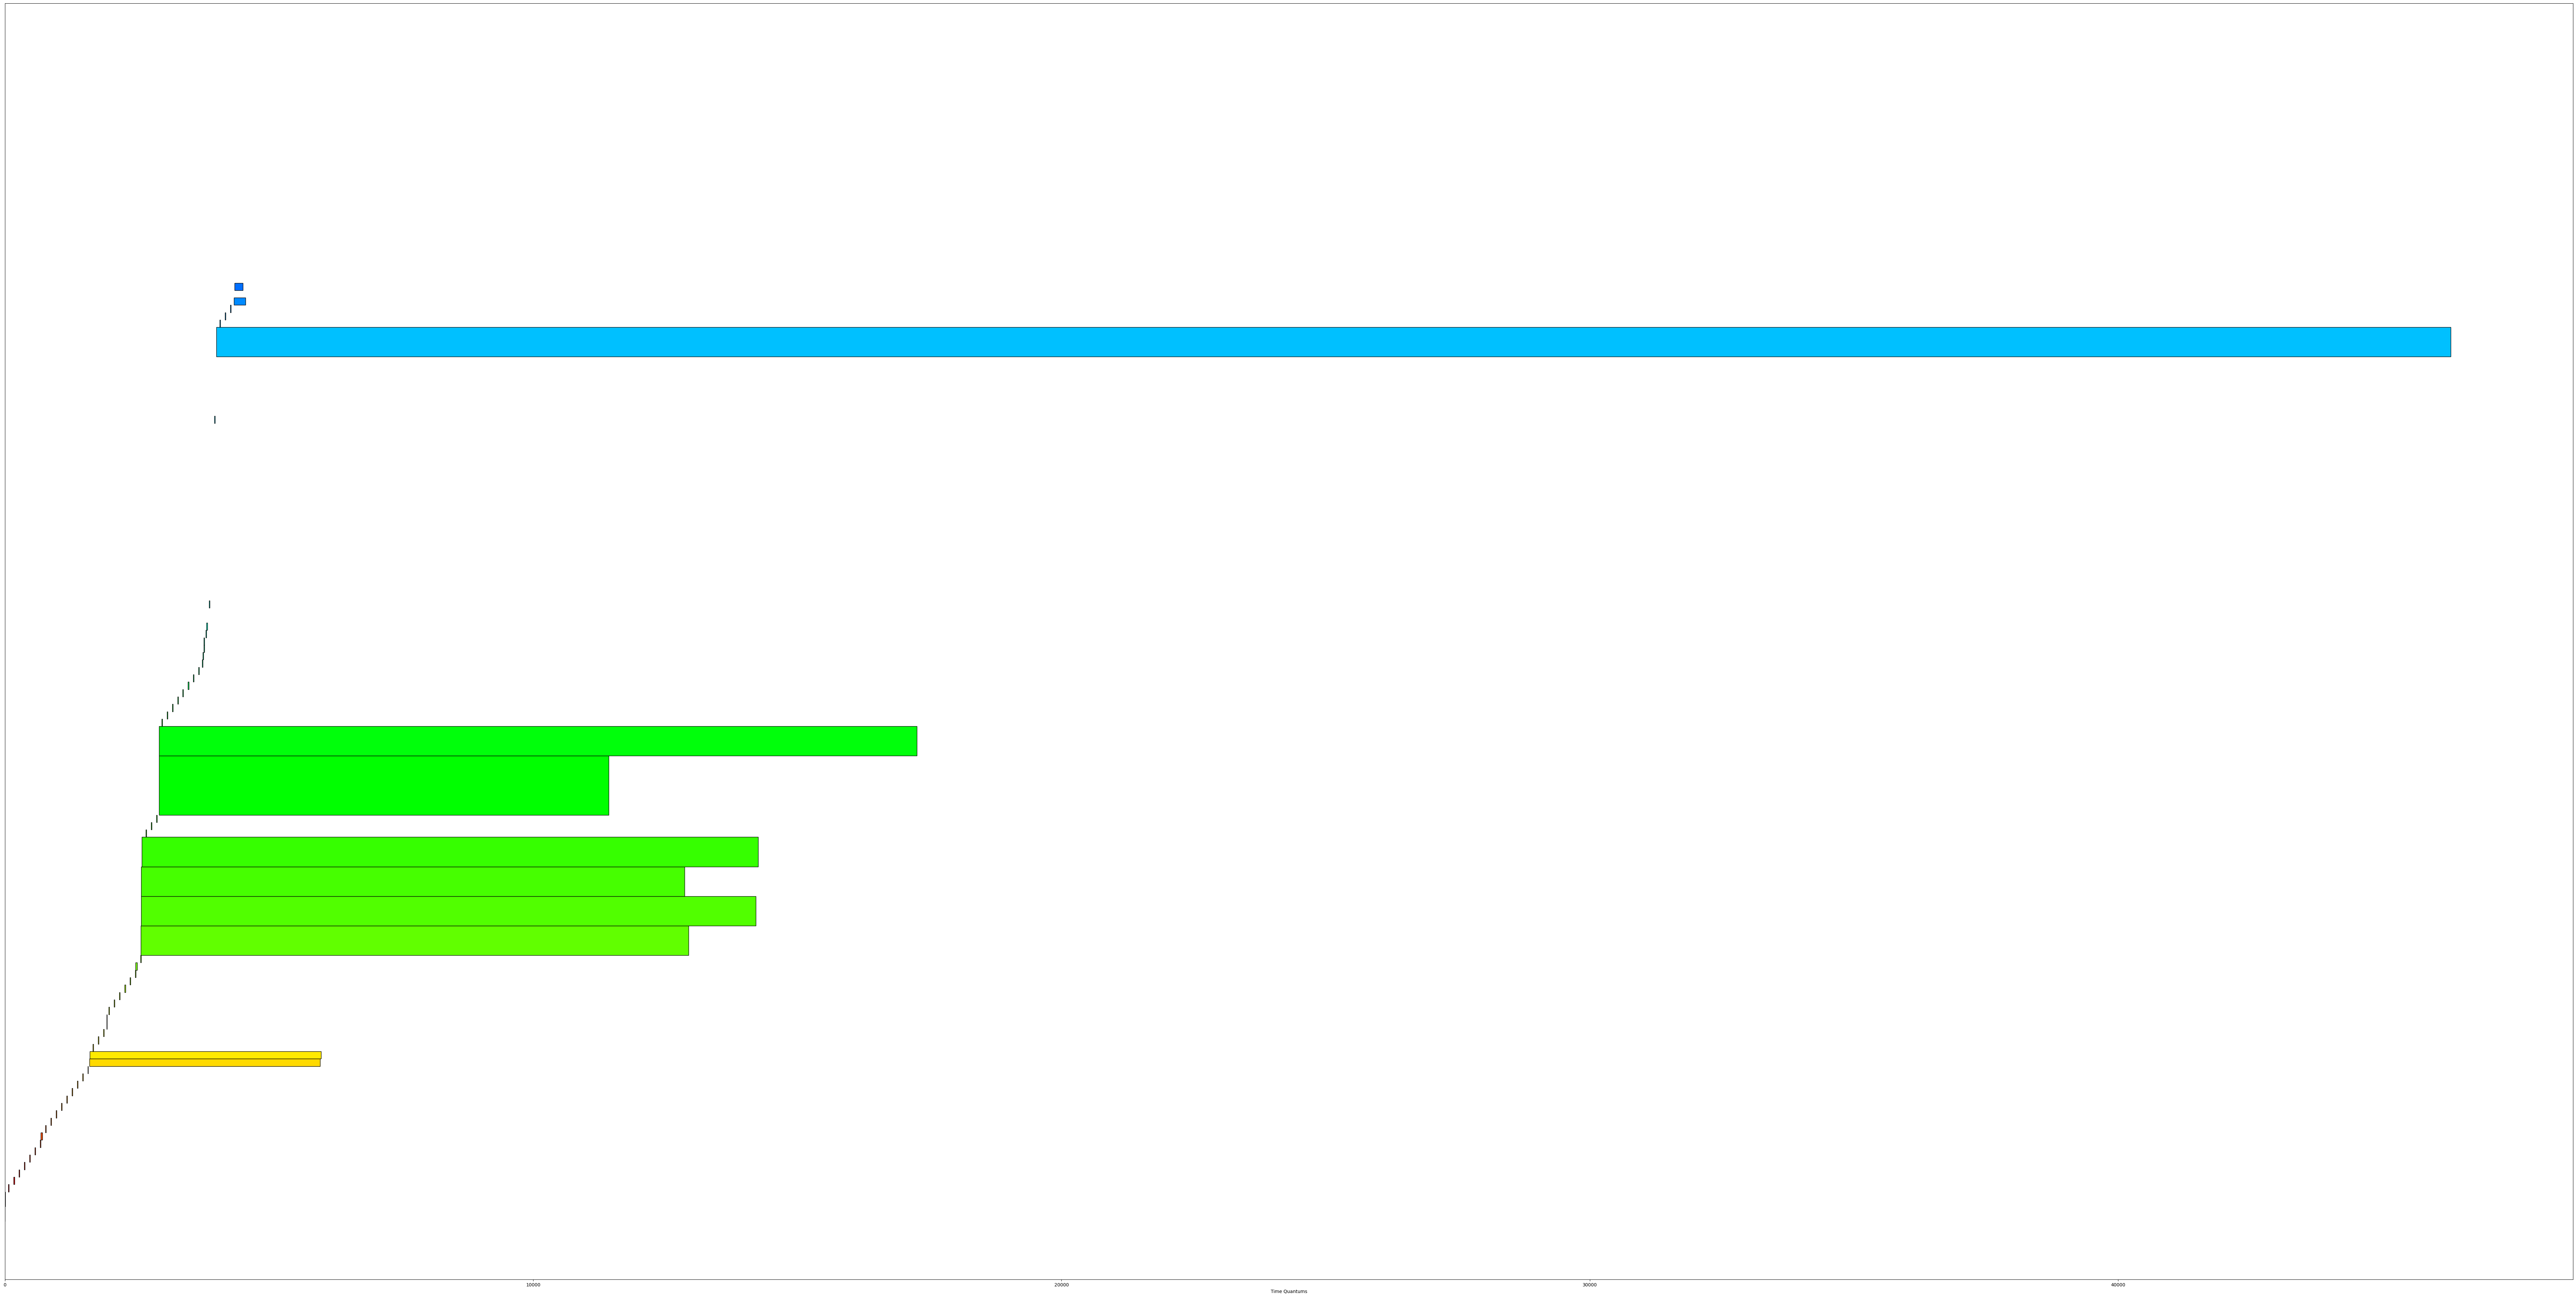

ljf-cloud


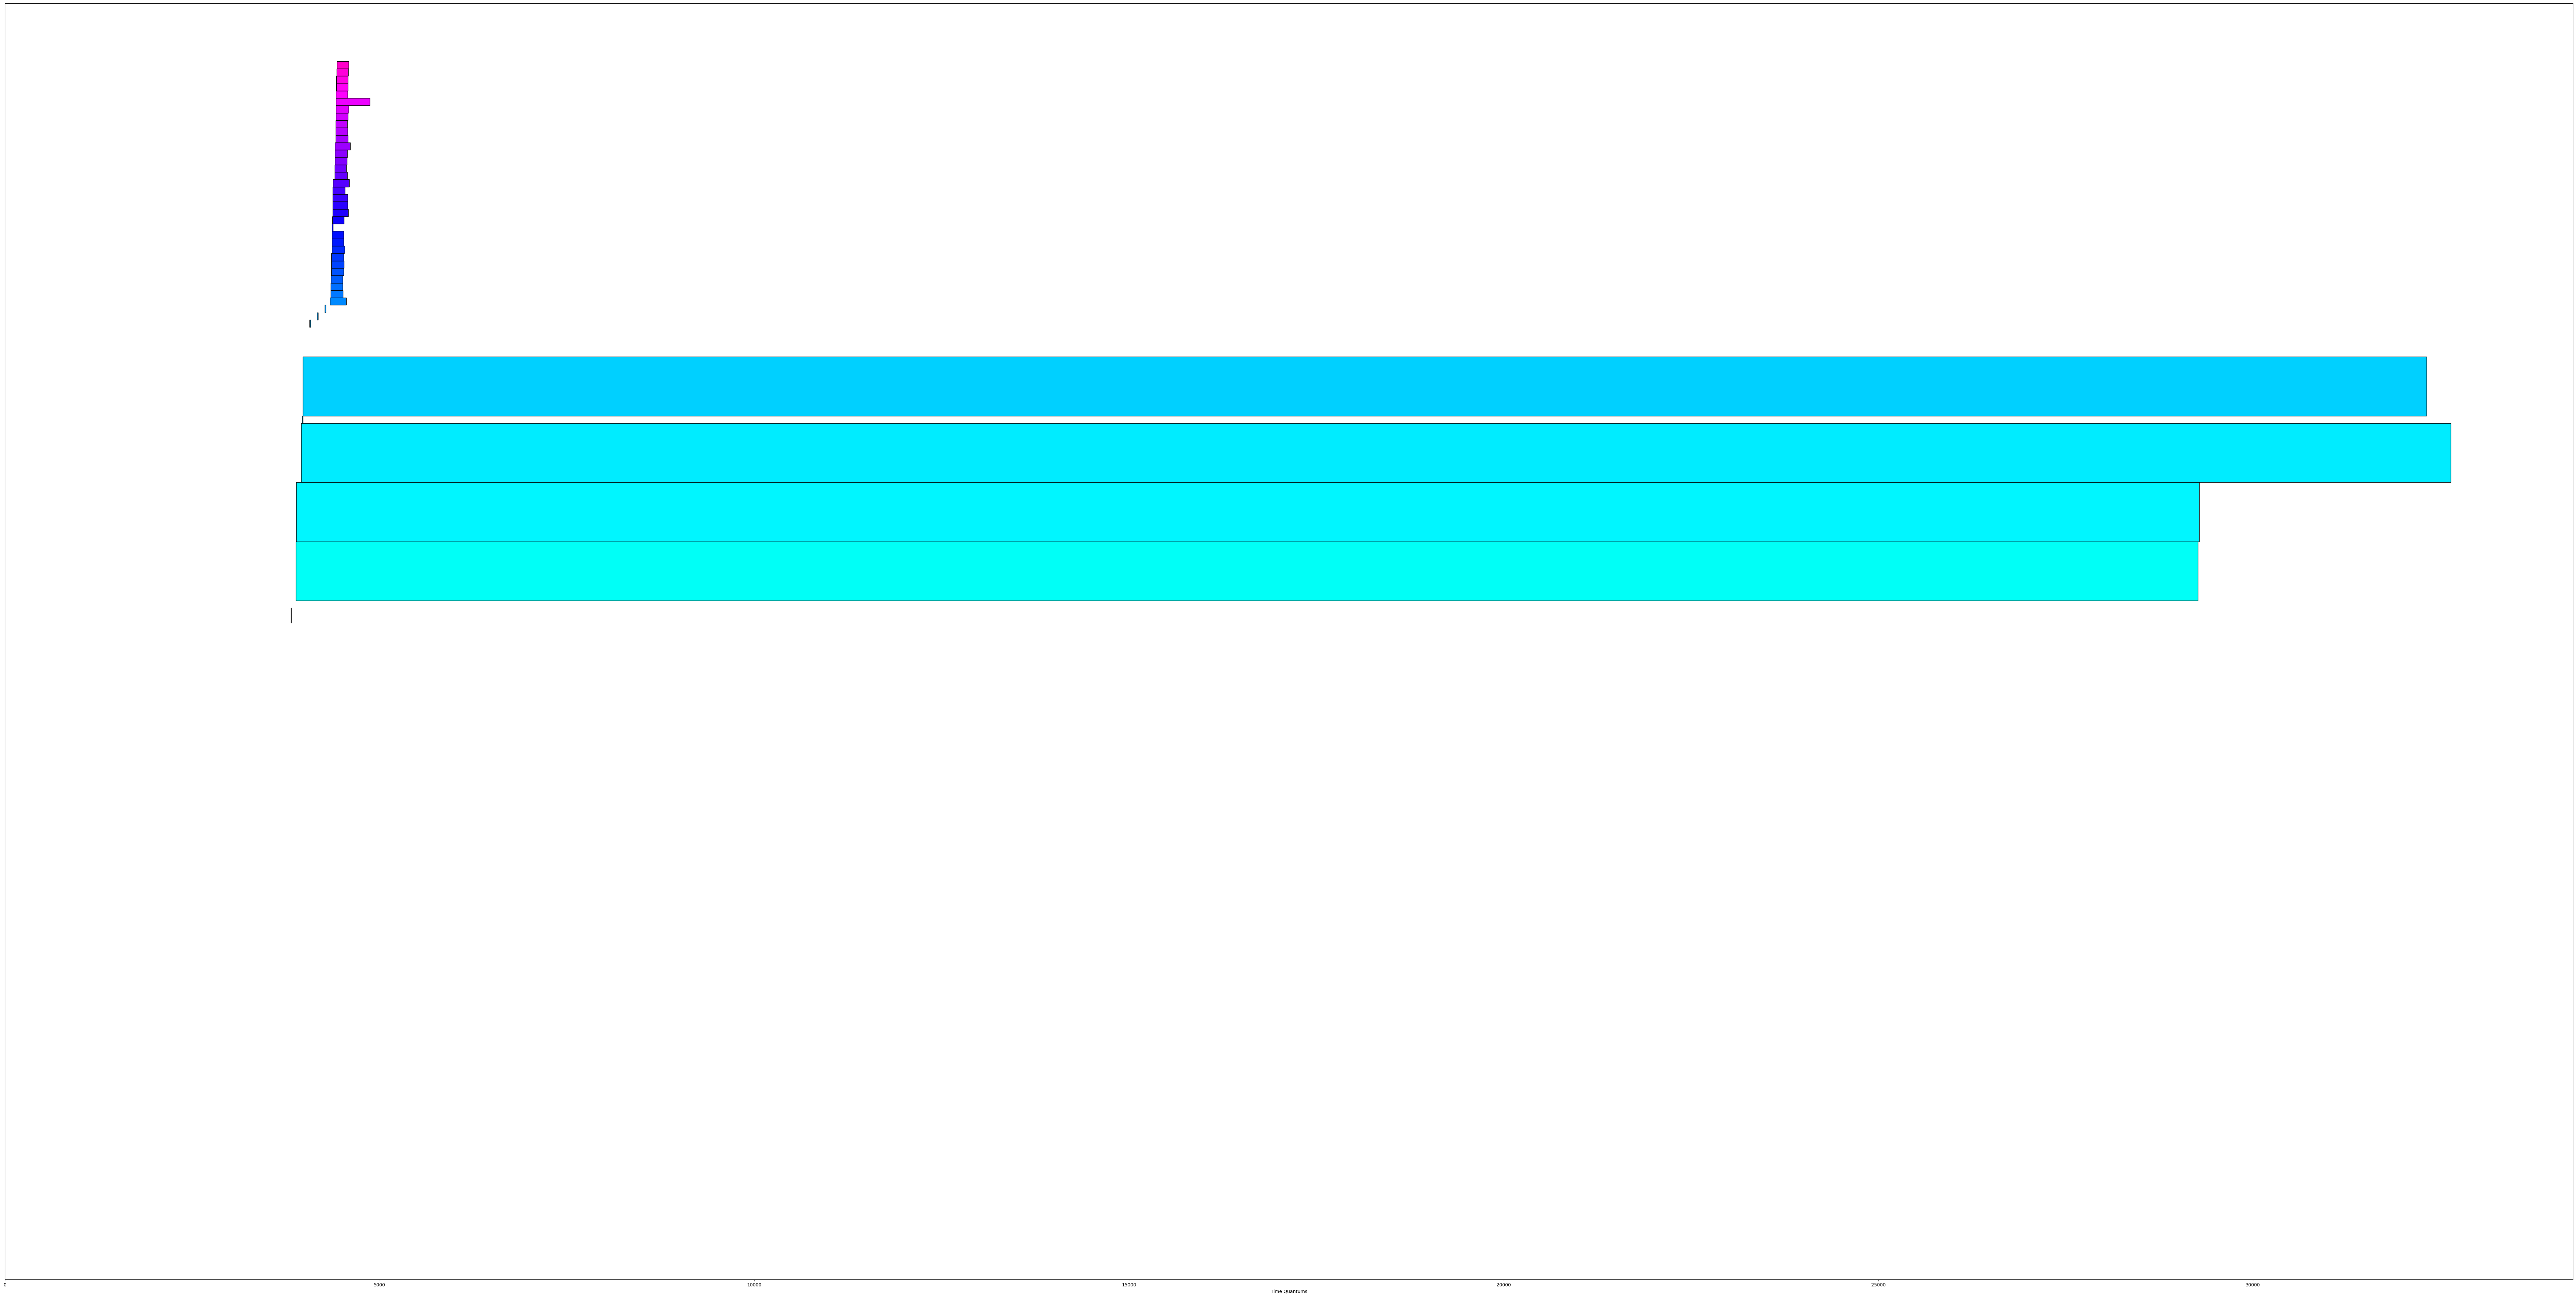

ljf-local


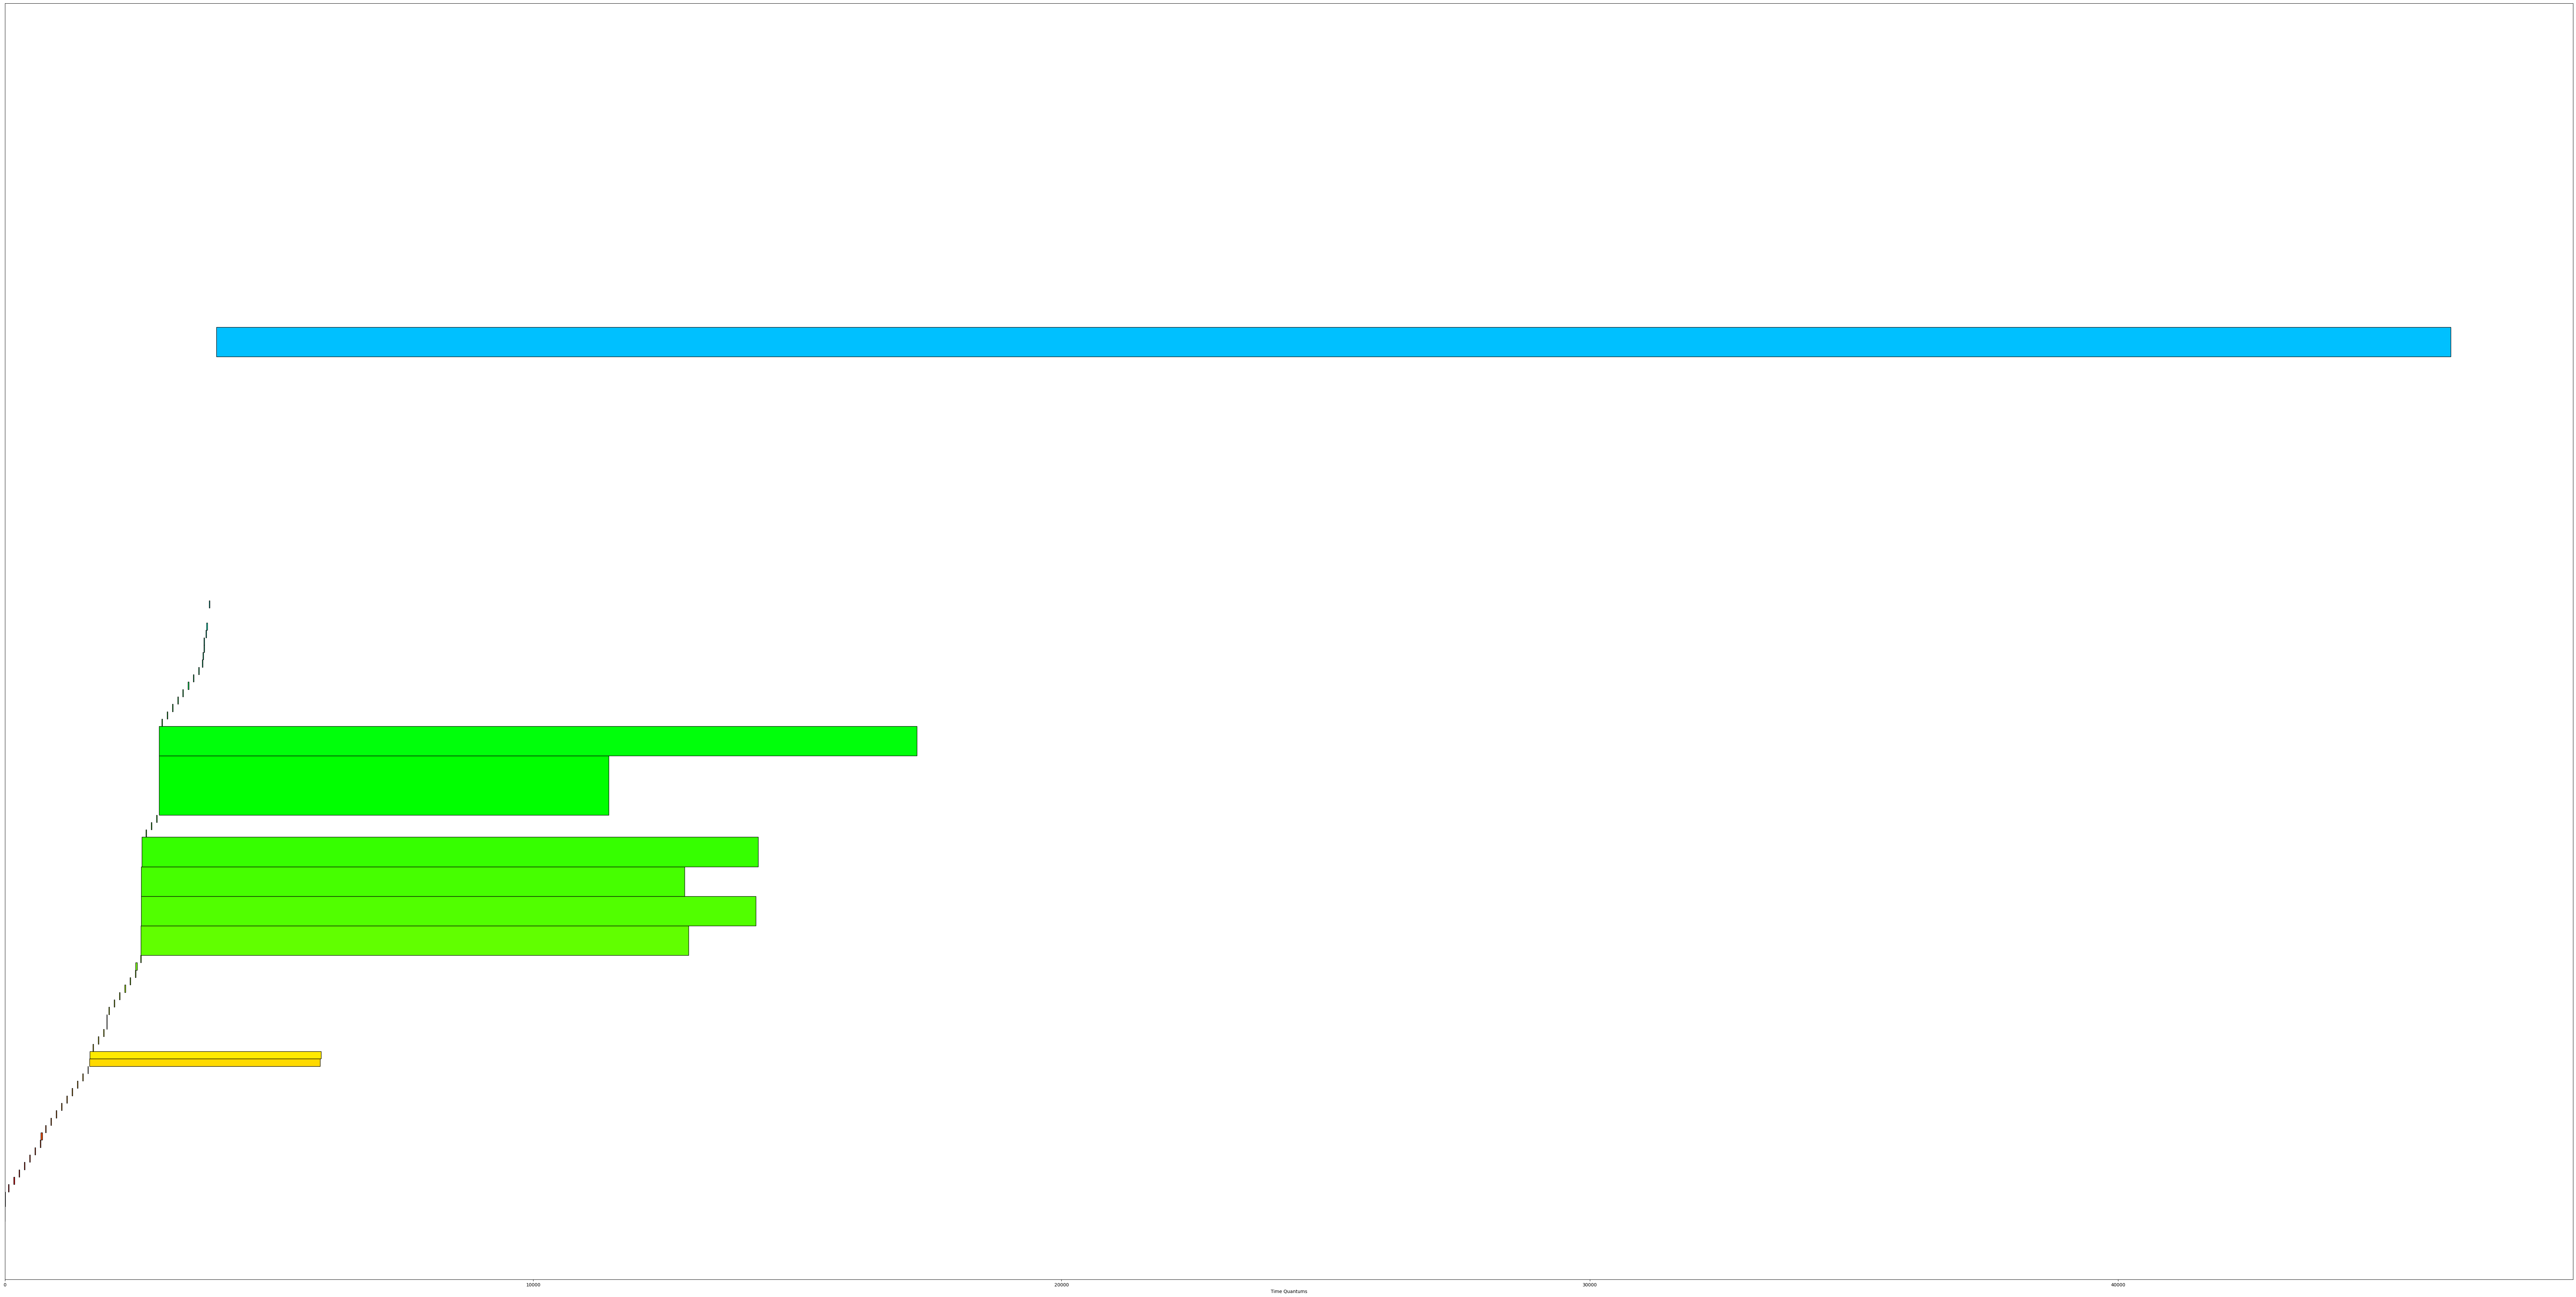

lvjf-cloud


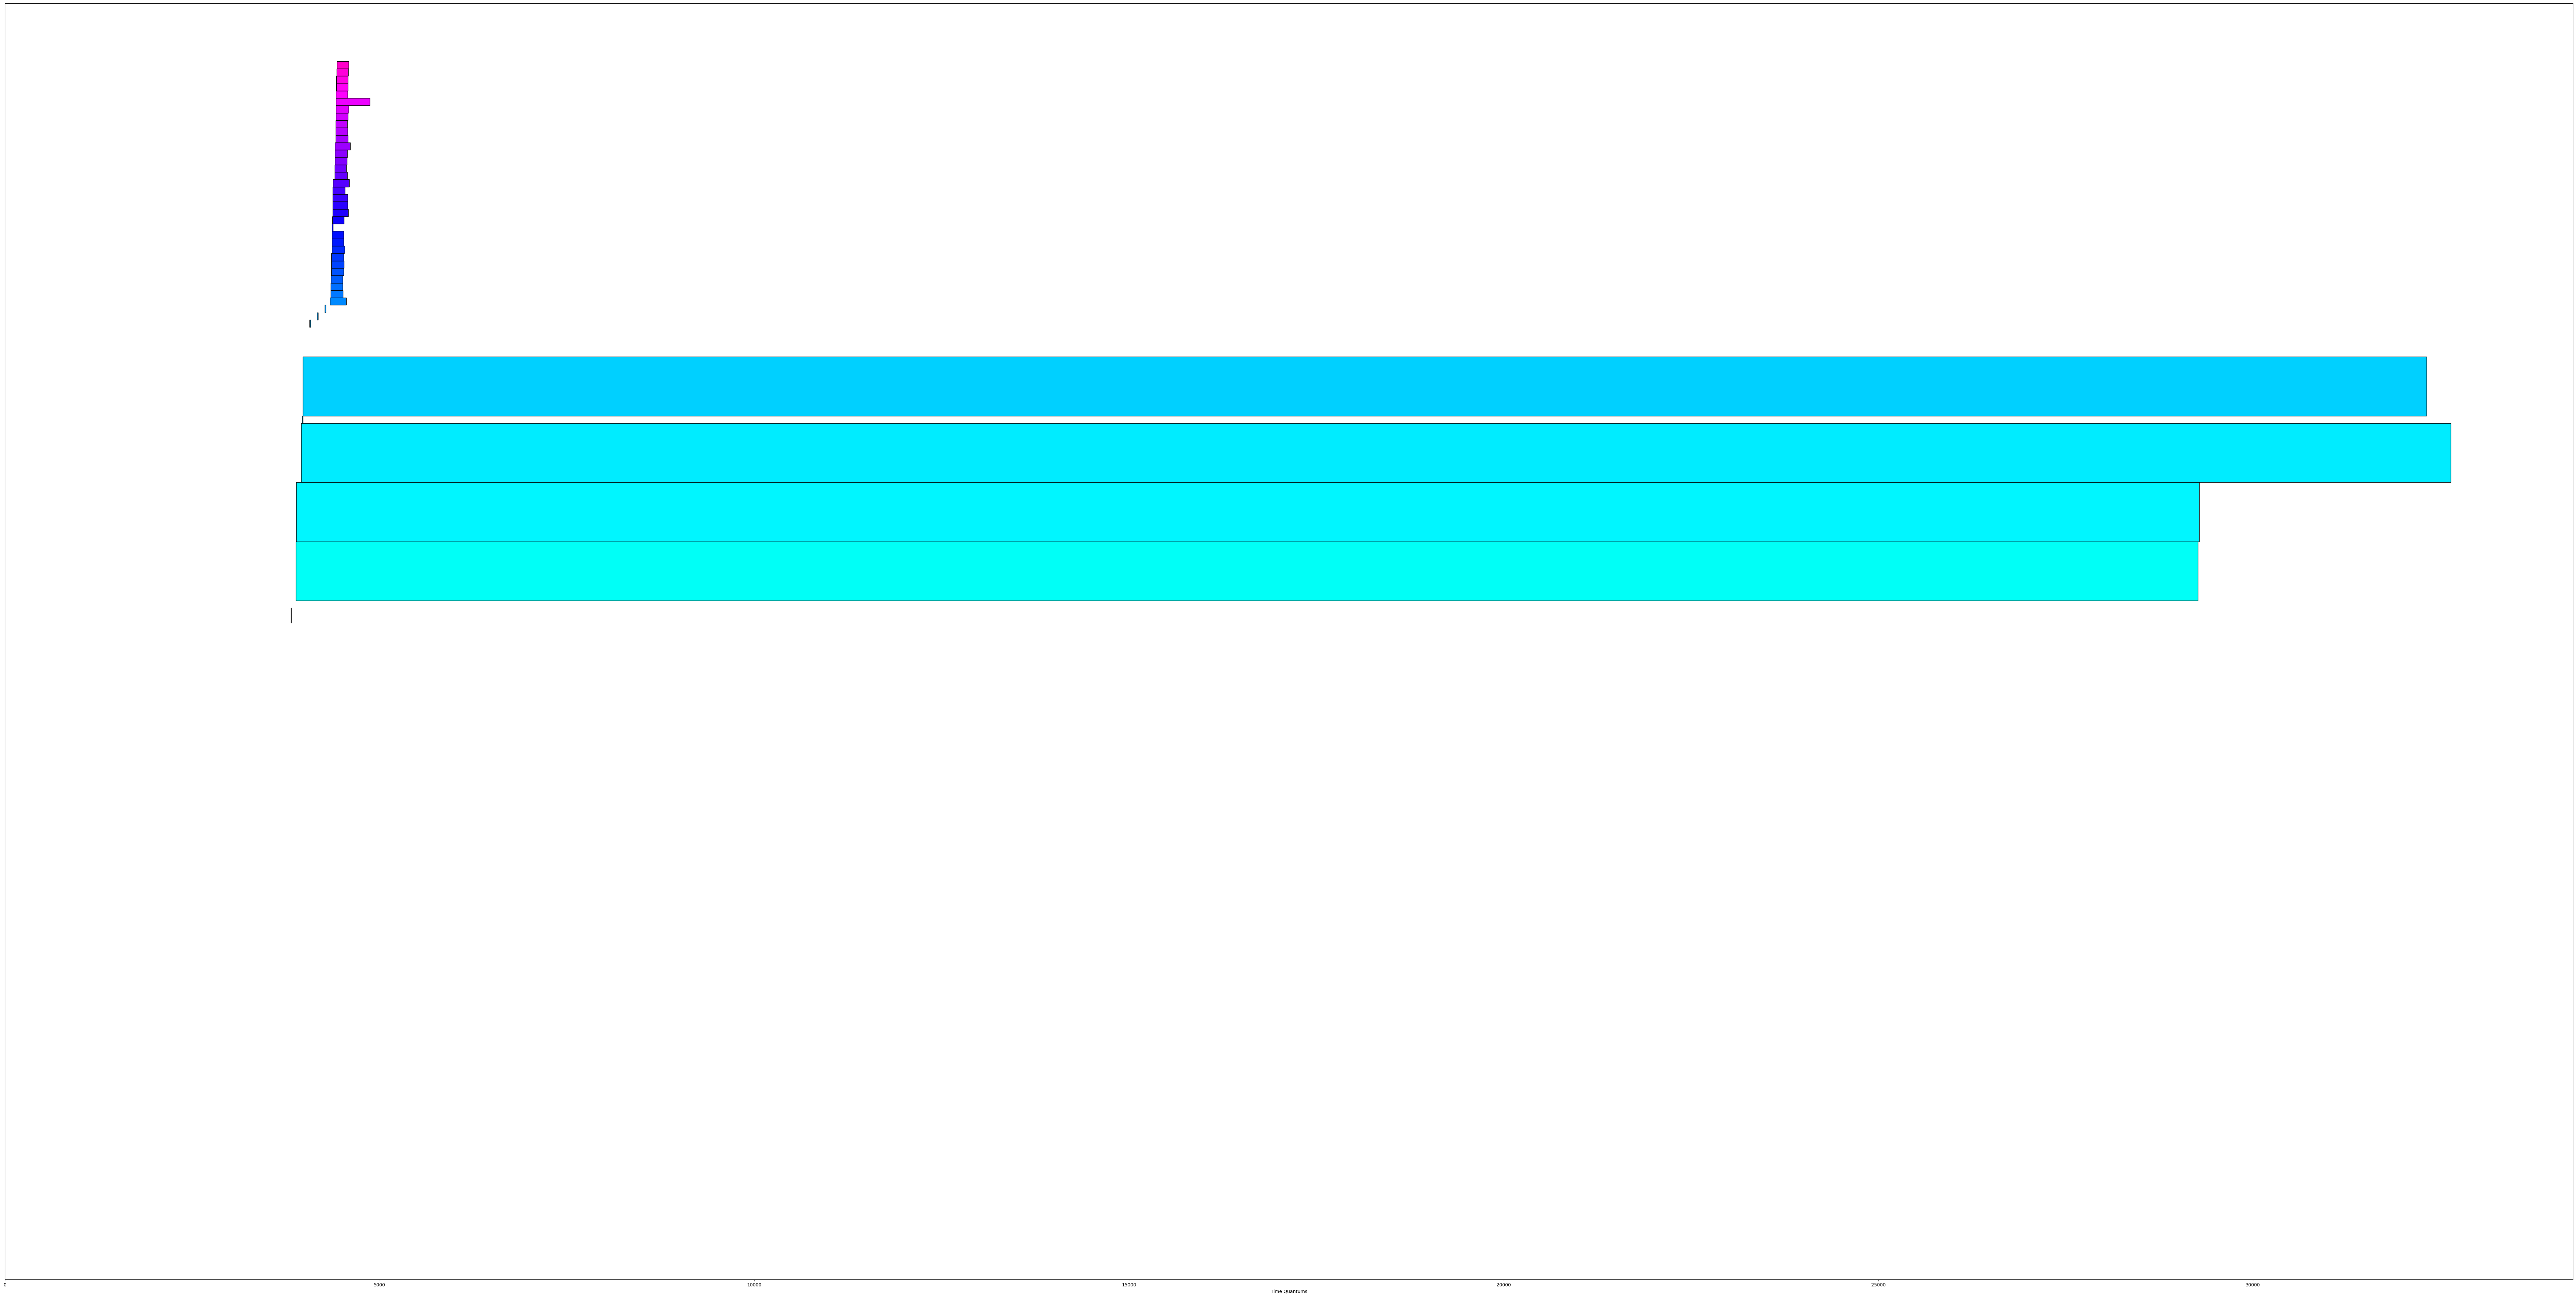

lvjf-local


In [ ]:
def plot_qjob_runtimes(jobs: List[QJob], mode='all'):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    x = [(j.arrival, min(j.deadline, max_time_quantum)) for j in jobs]
    fig, ax = plt.subplots(figsize=(100,50))
    
    count=0
    for i,evt in enumerate(x):
        if mode=='all':
            mask = 1
        elif mode=='cloud':
            if jobs[i].start is None:
                mask=1
            else:
                mask=0
        elif mode=='local':
            if jobs[i].start is None:
                mask=0
            else:
                mask=1
#         ax.barh(count,
#                 width=(evt[1]-evt[0]),
#                 edgecolor='black' if mask else None,
#                 height=1.0*jobs[i].num_gpus,
#                 left=evt[0],
#                 align='edge',
#                 color=colors[i] if mask else 'grey')
        ax.barh(count,
                width=mask*(evt[1]-evt[0]),
                edgecolor='black' if mask else None,
                height=1.0*jobs[i].num_gpus,
                left=evt[0],
                align='edge',
                color=colors[i] if mask else None)

        count+= jobs[i].num_gpus 
    ax.get_yaxis().set_visible(False)
    plt.xlabel('Time Quantums')
    plt.show()
print('all')
plot_qjob_runtimes(q_results['fifo'][1], mode='all')
for alg in algs:
    for job_filter in ['cloud', 'local']:
        print(f'{alg}-{job_filter}')
        plot_qjob_runtimes(q_results[alg][1], mode=job_filter)

all


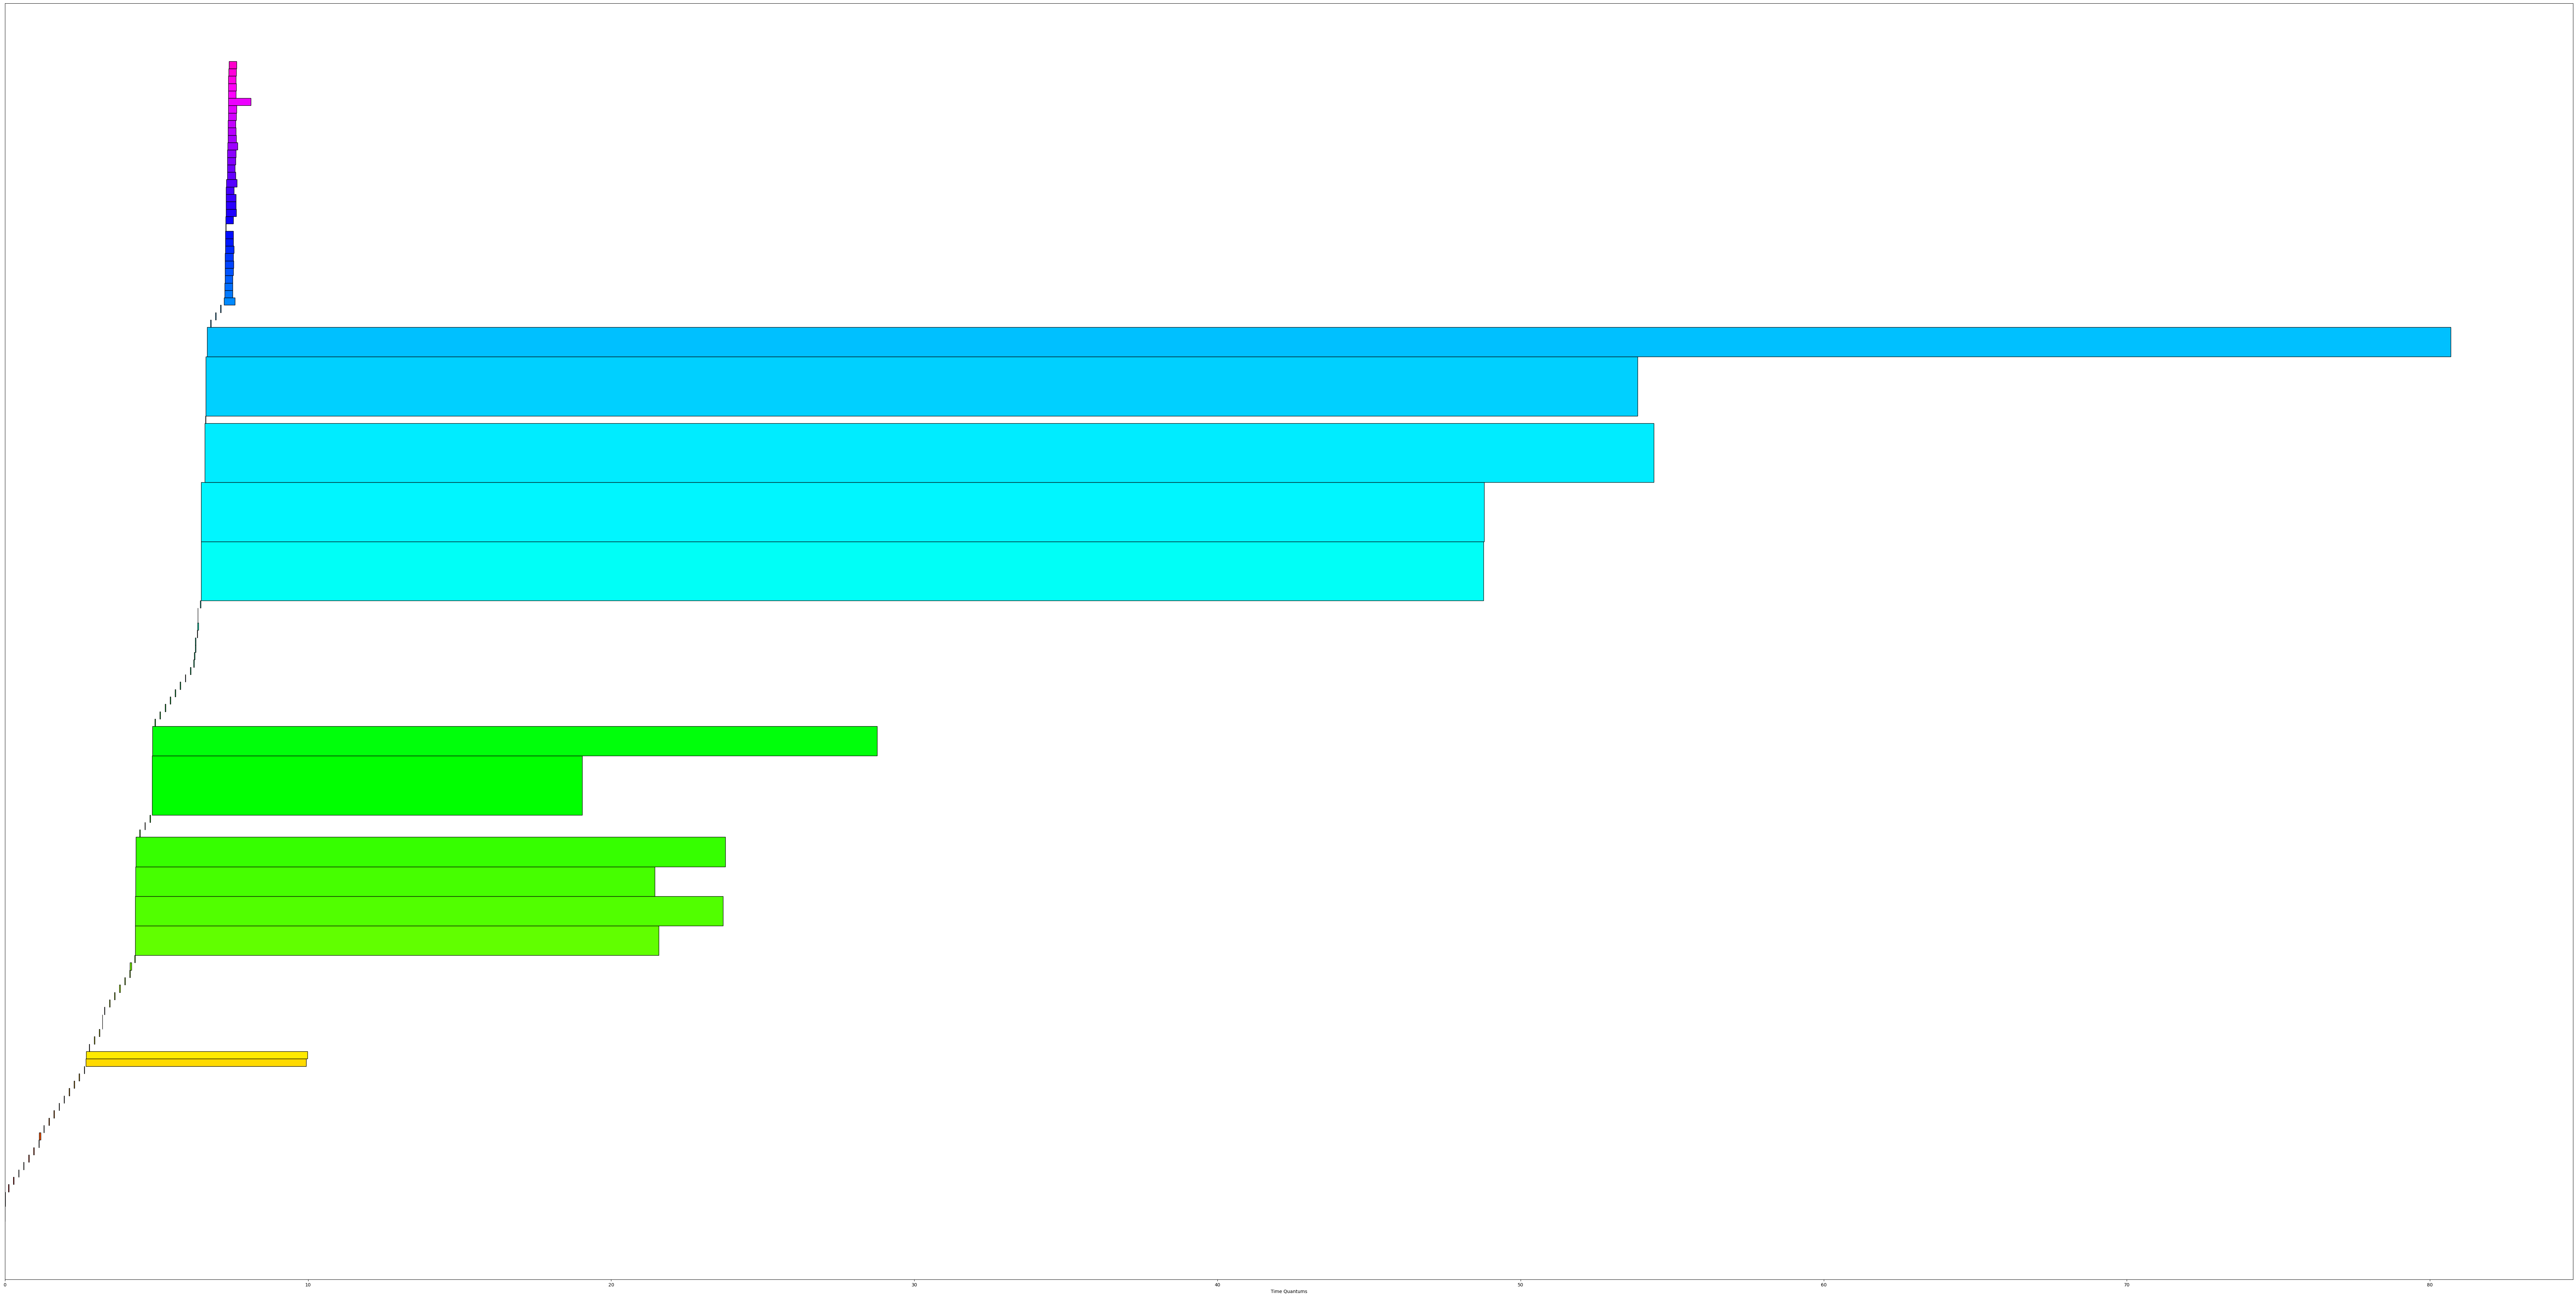

fifo-cloud


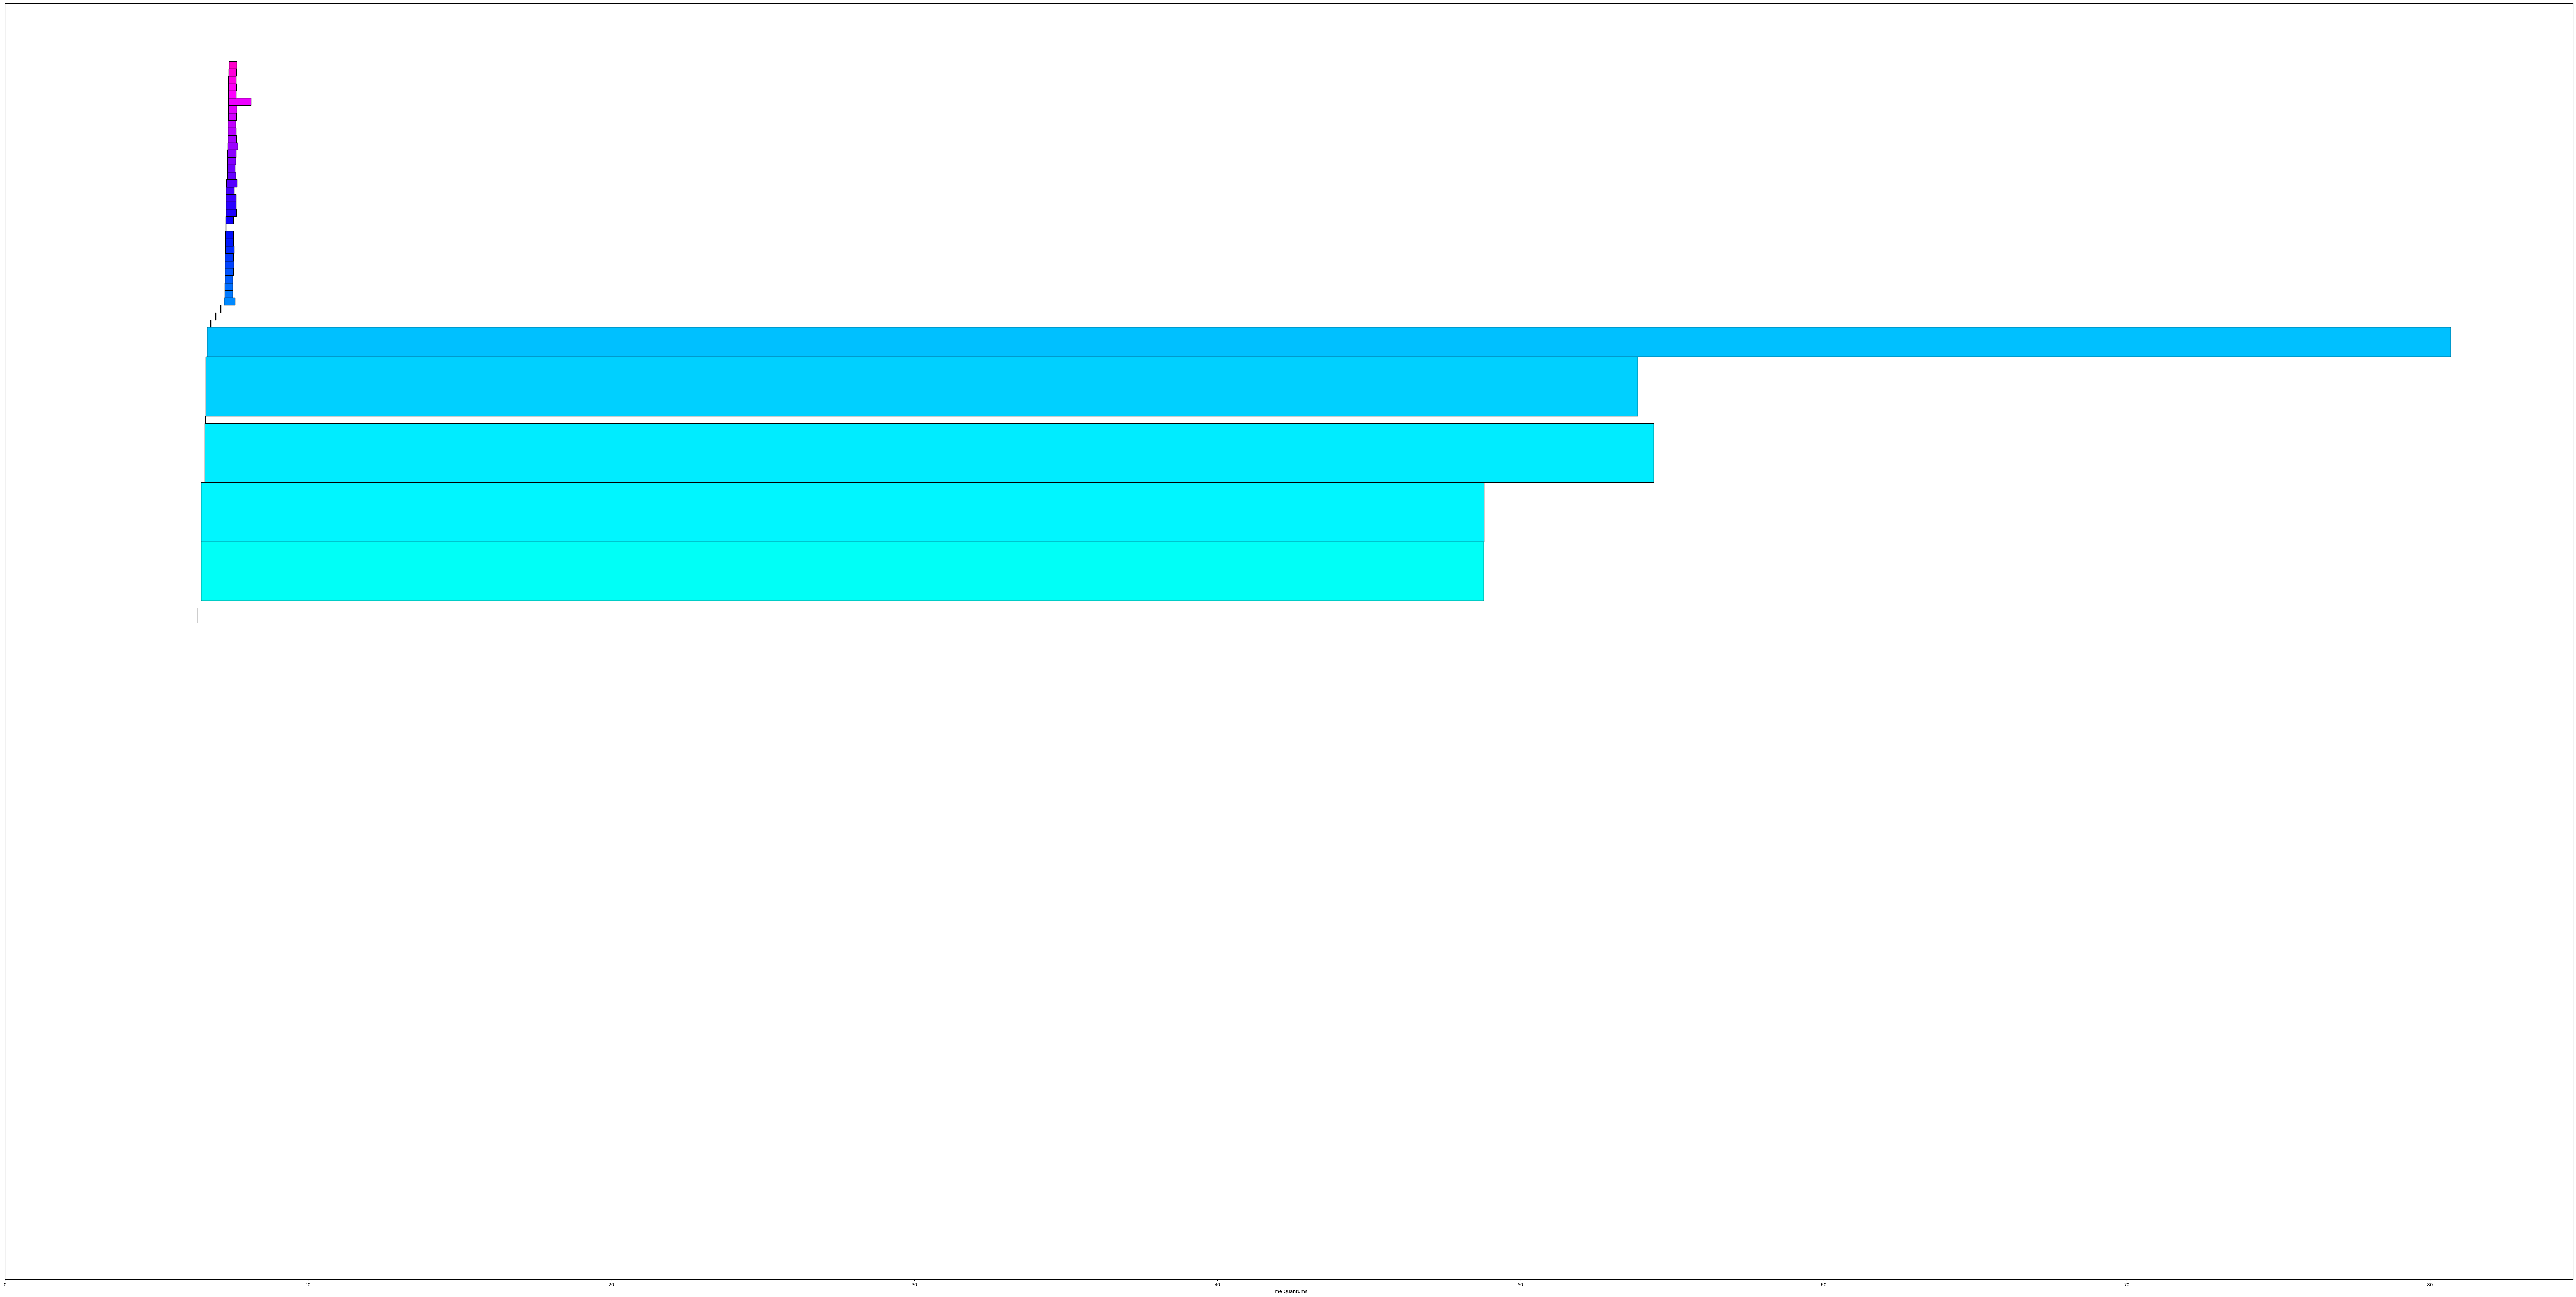

fifo-local


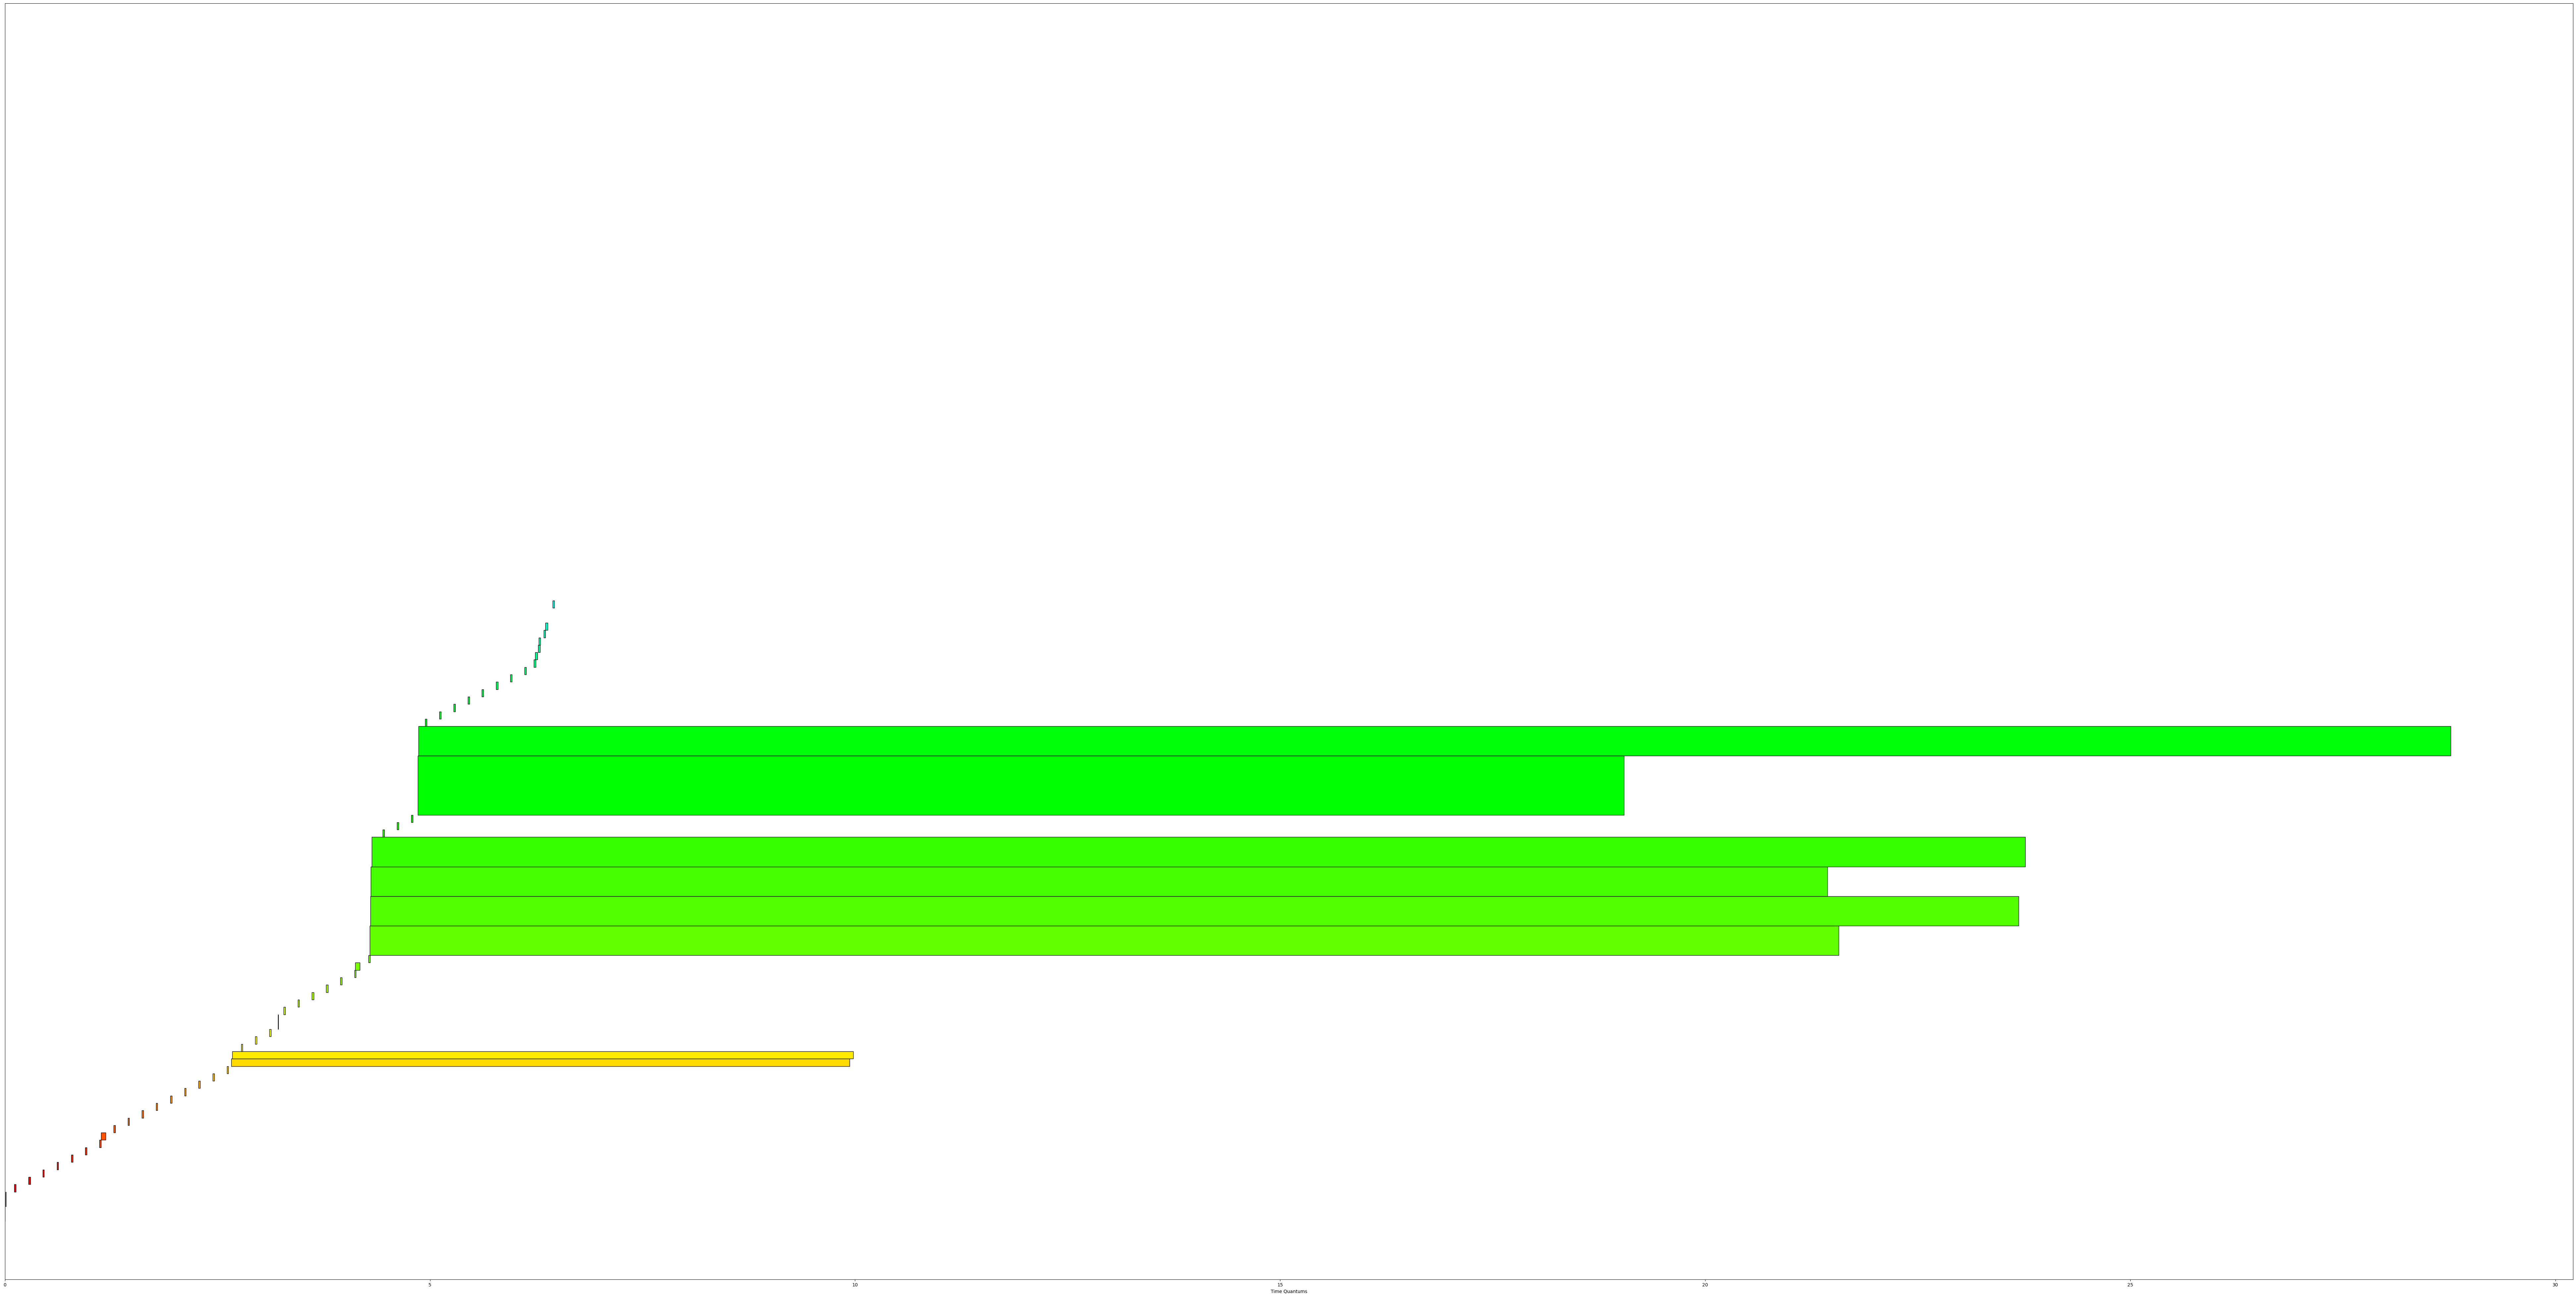

edf-cloud


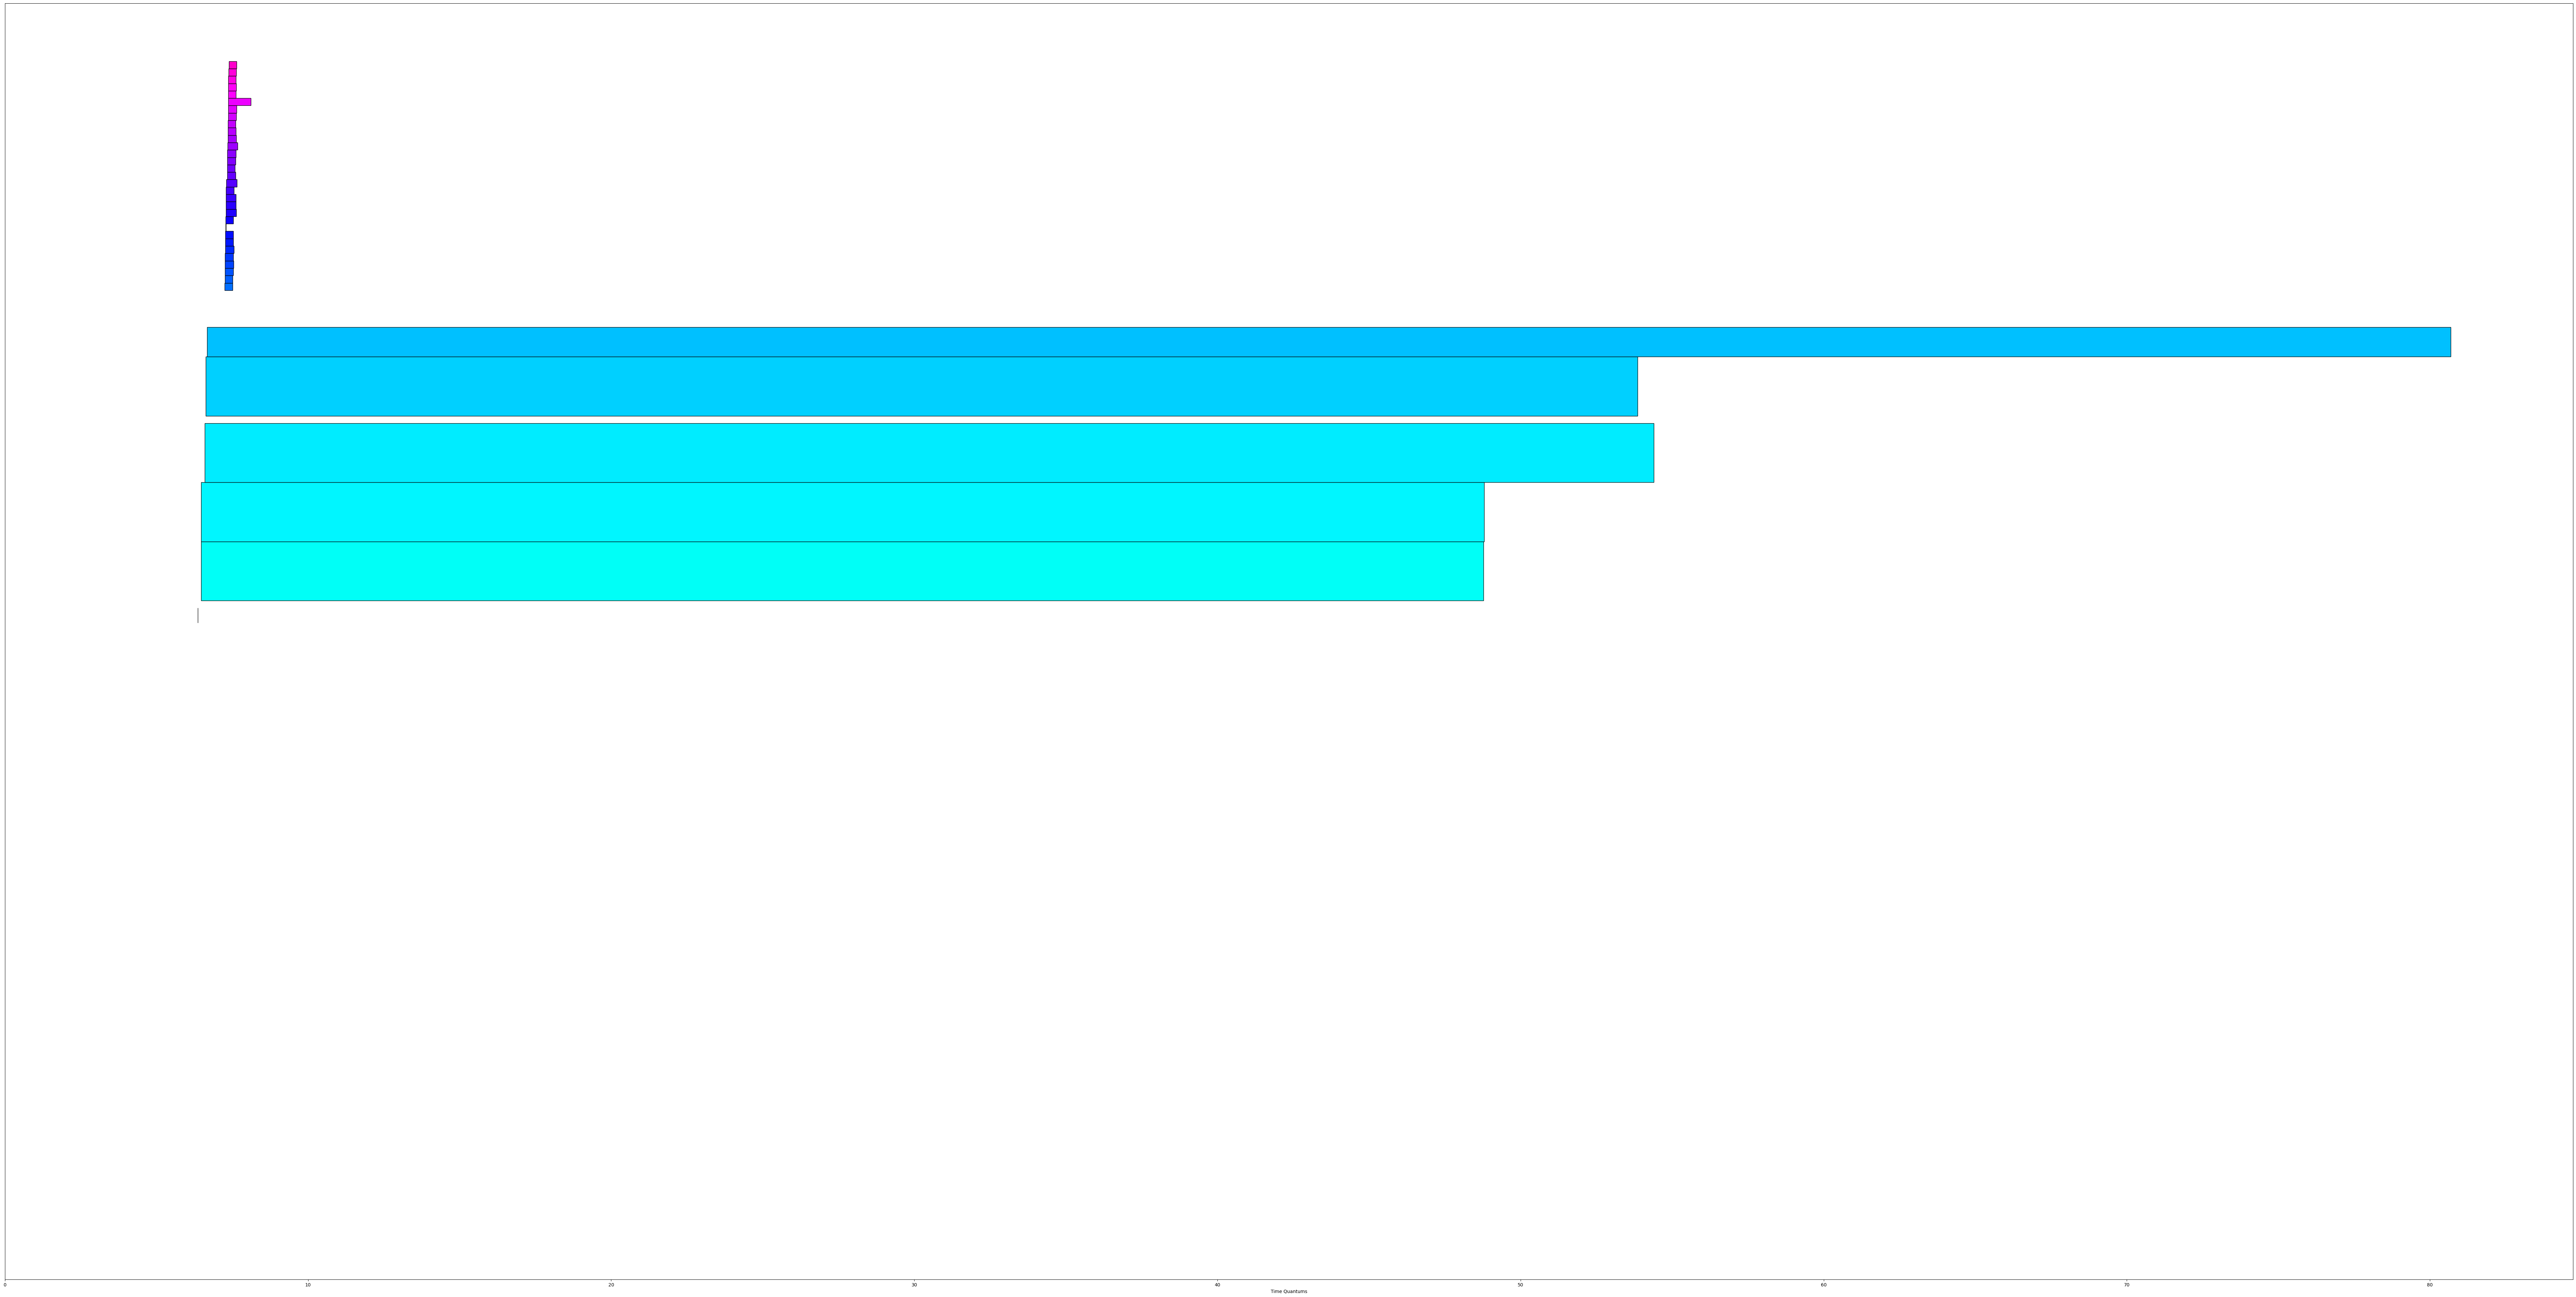

edf-local


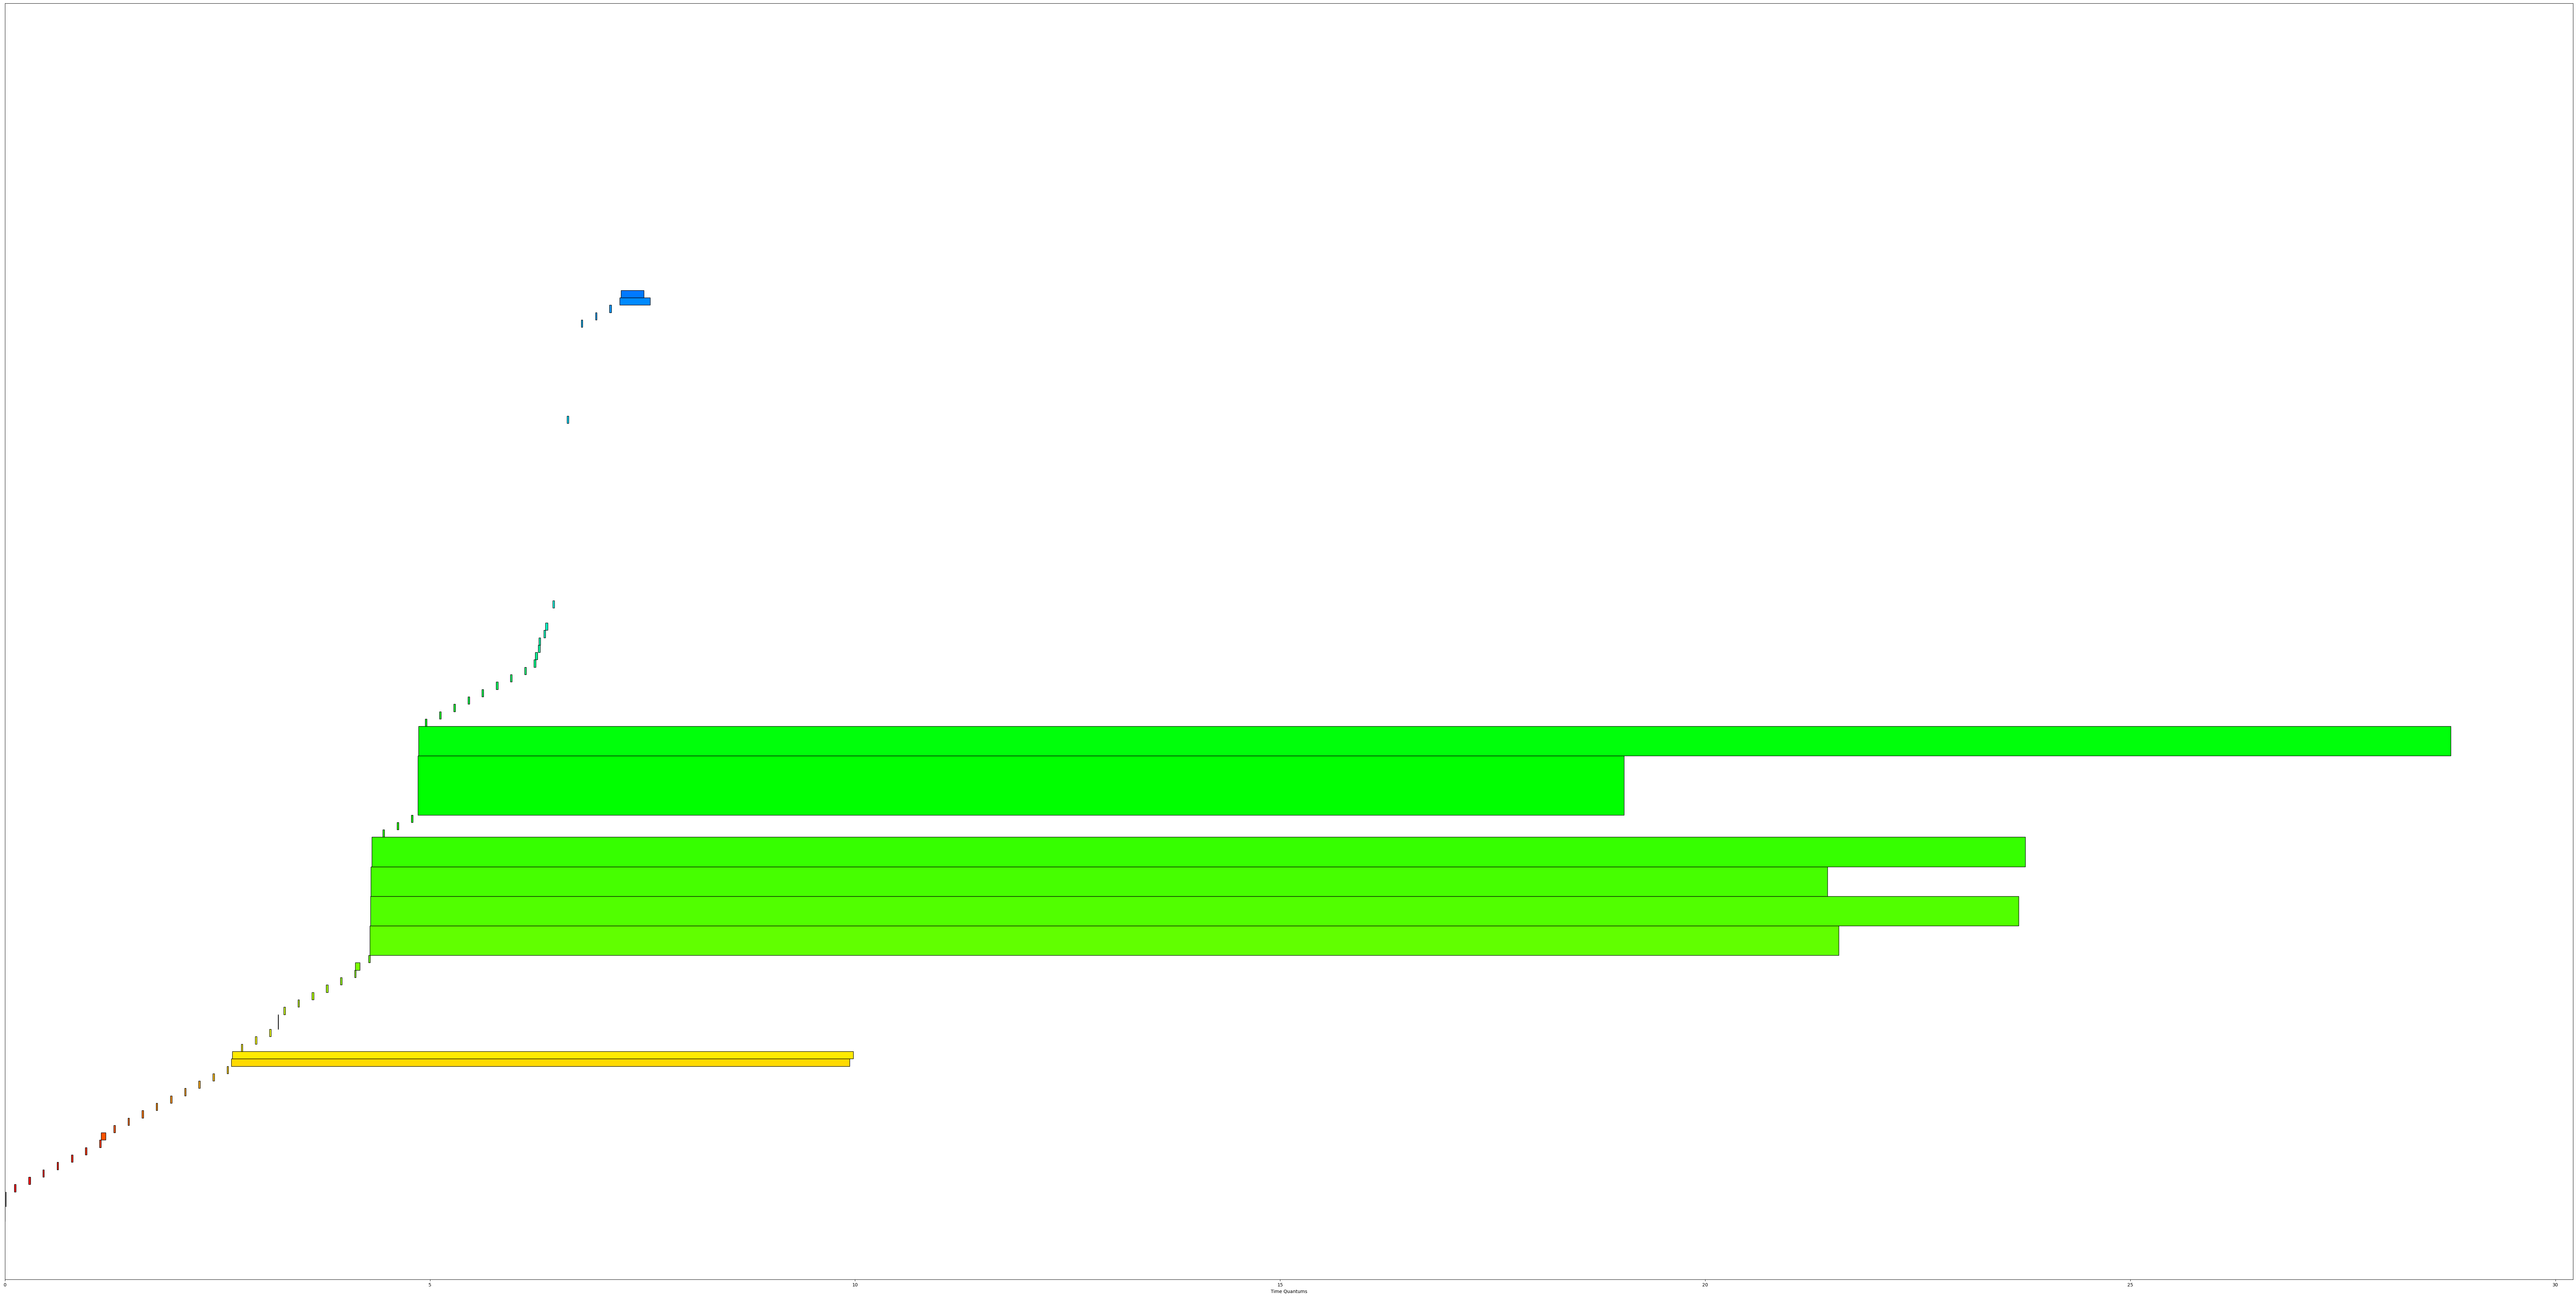

ljf-cloud


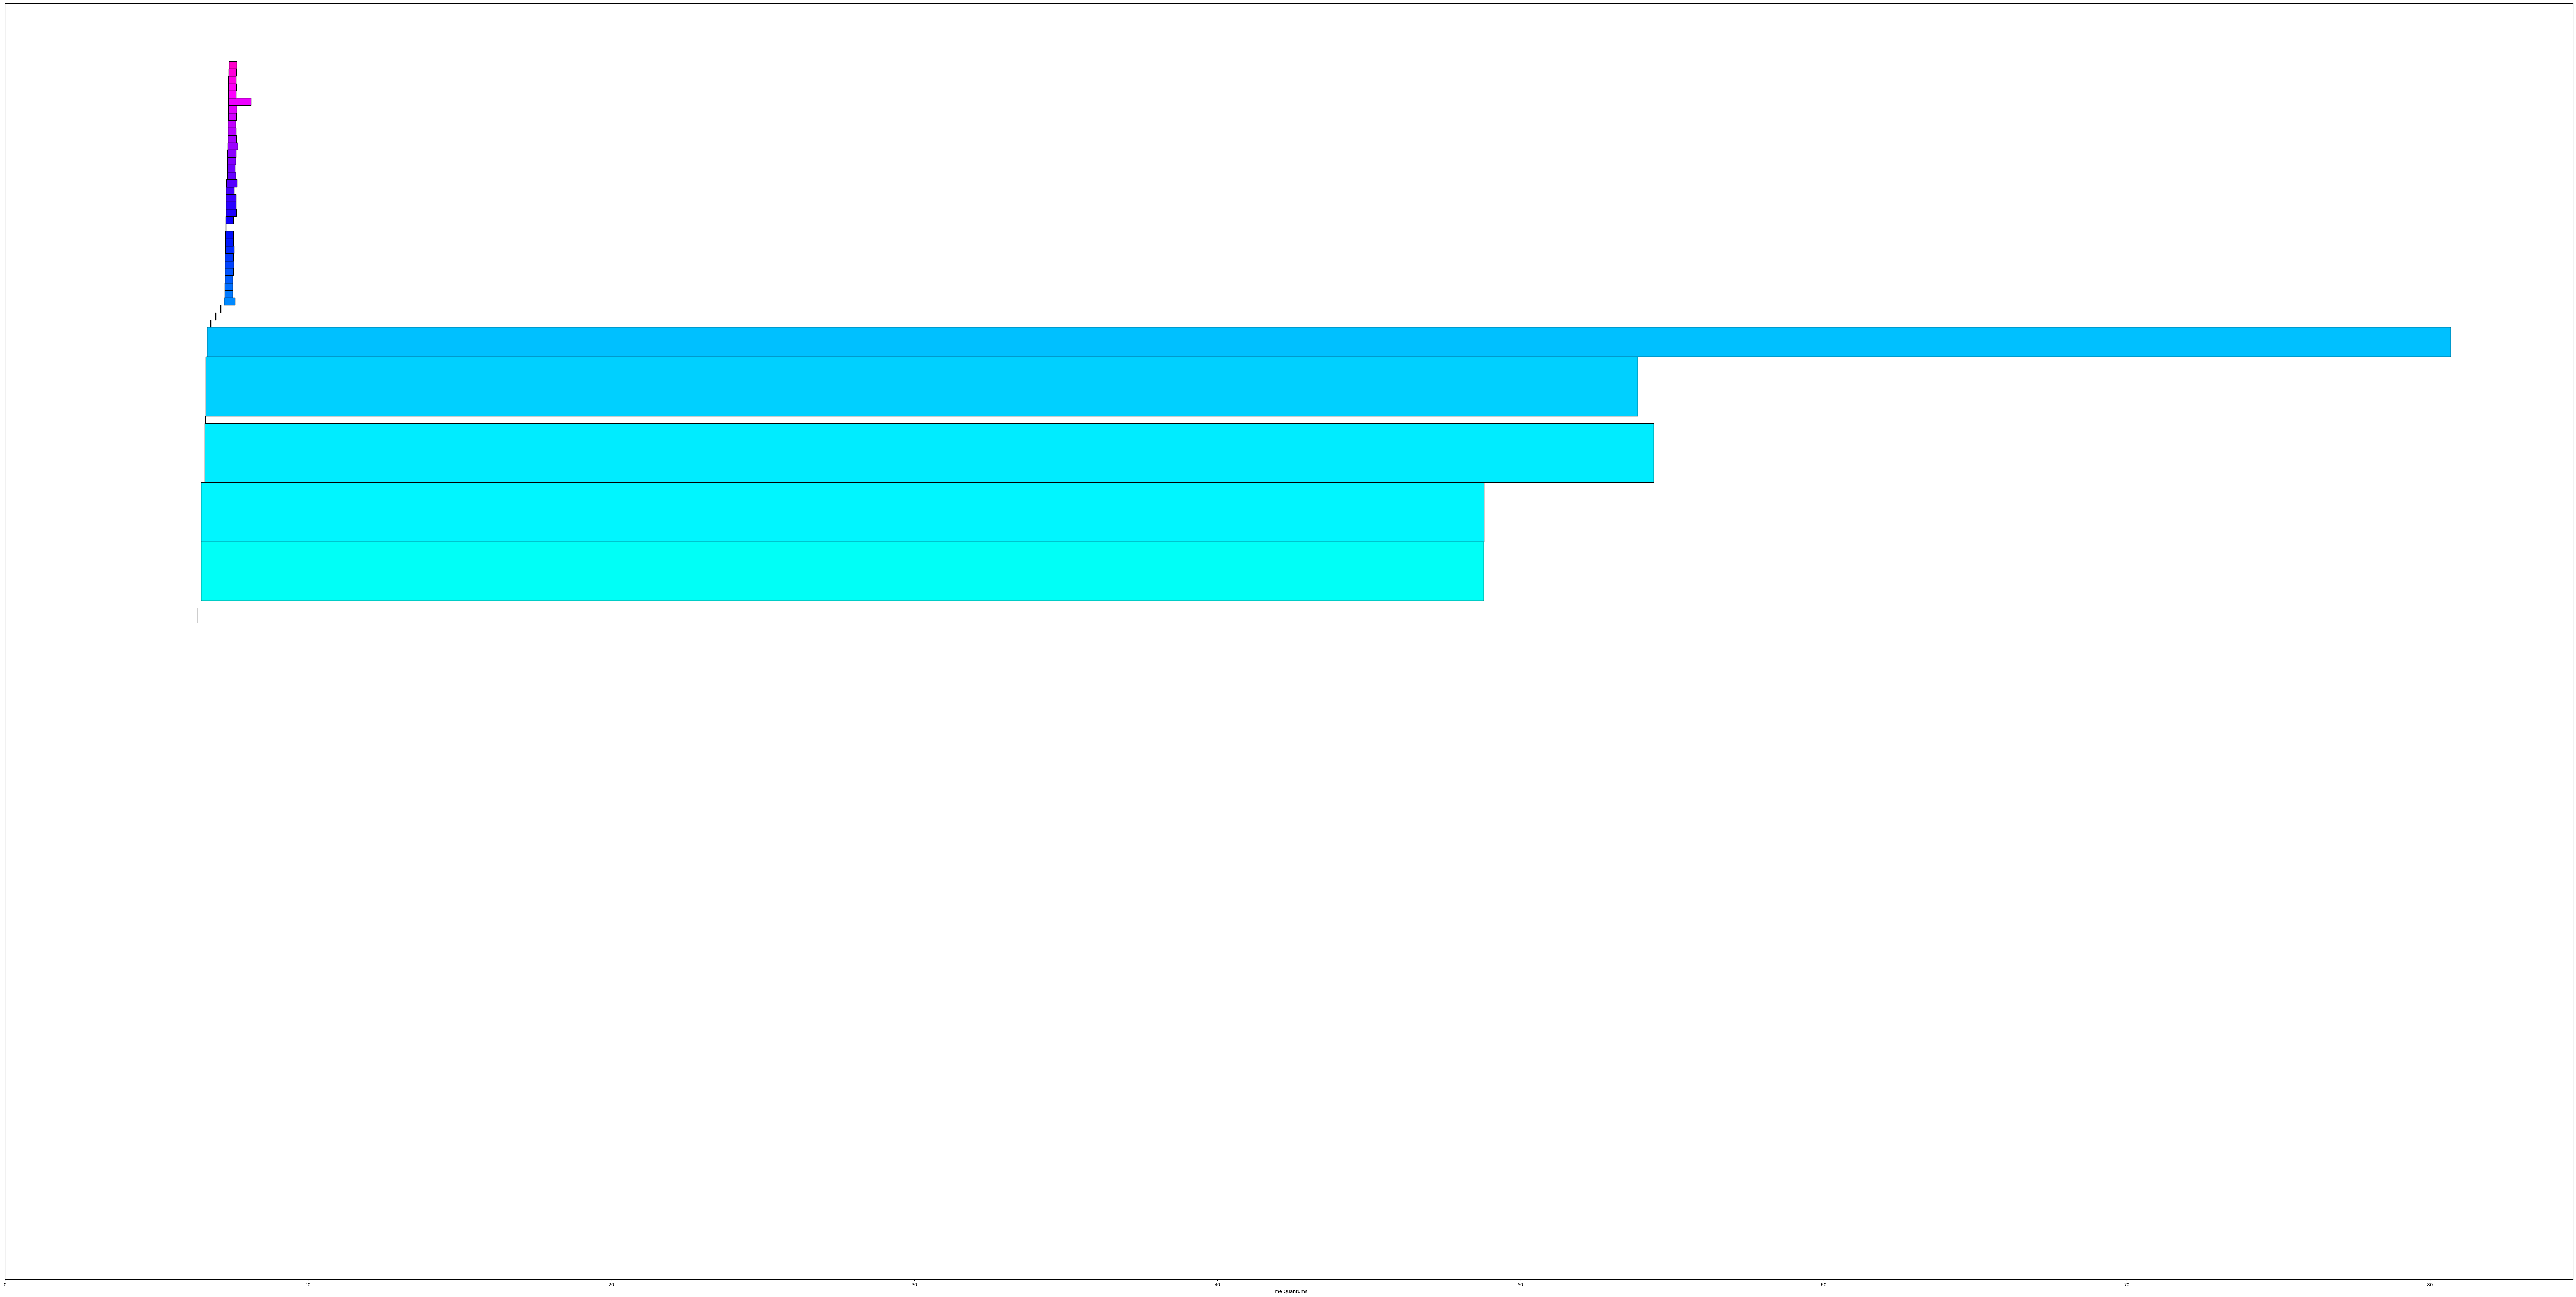

ljf-local


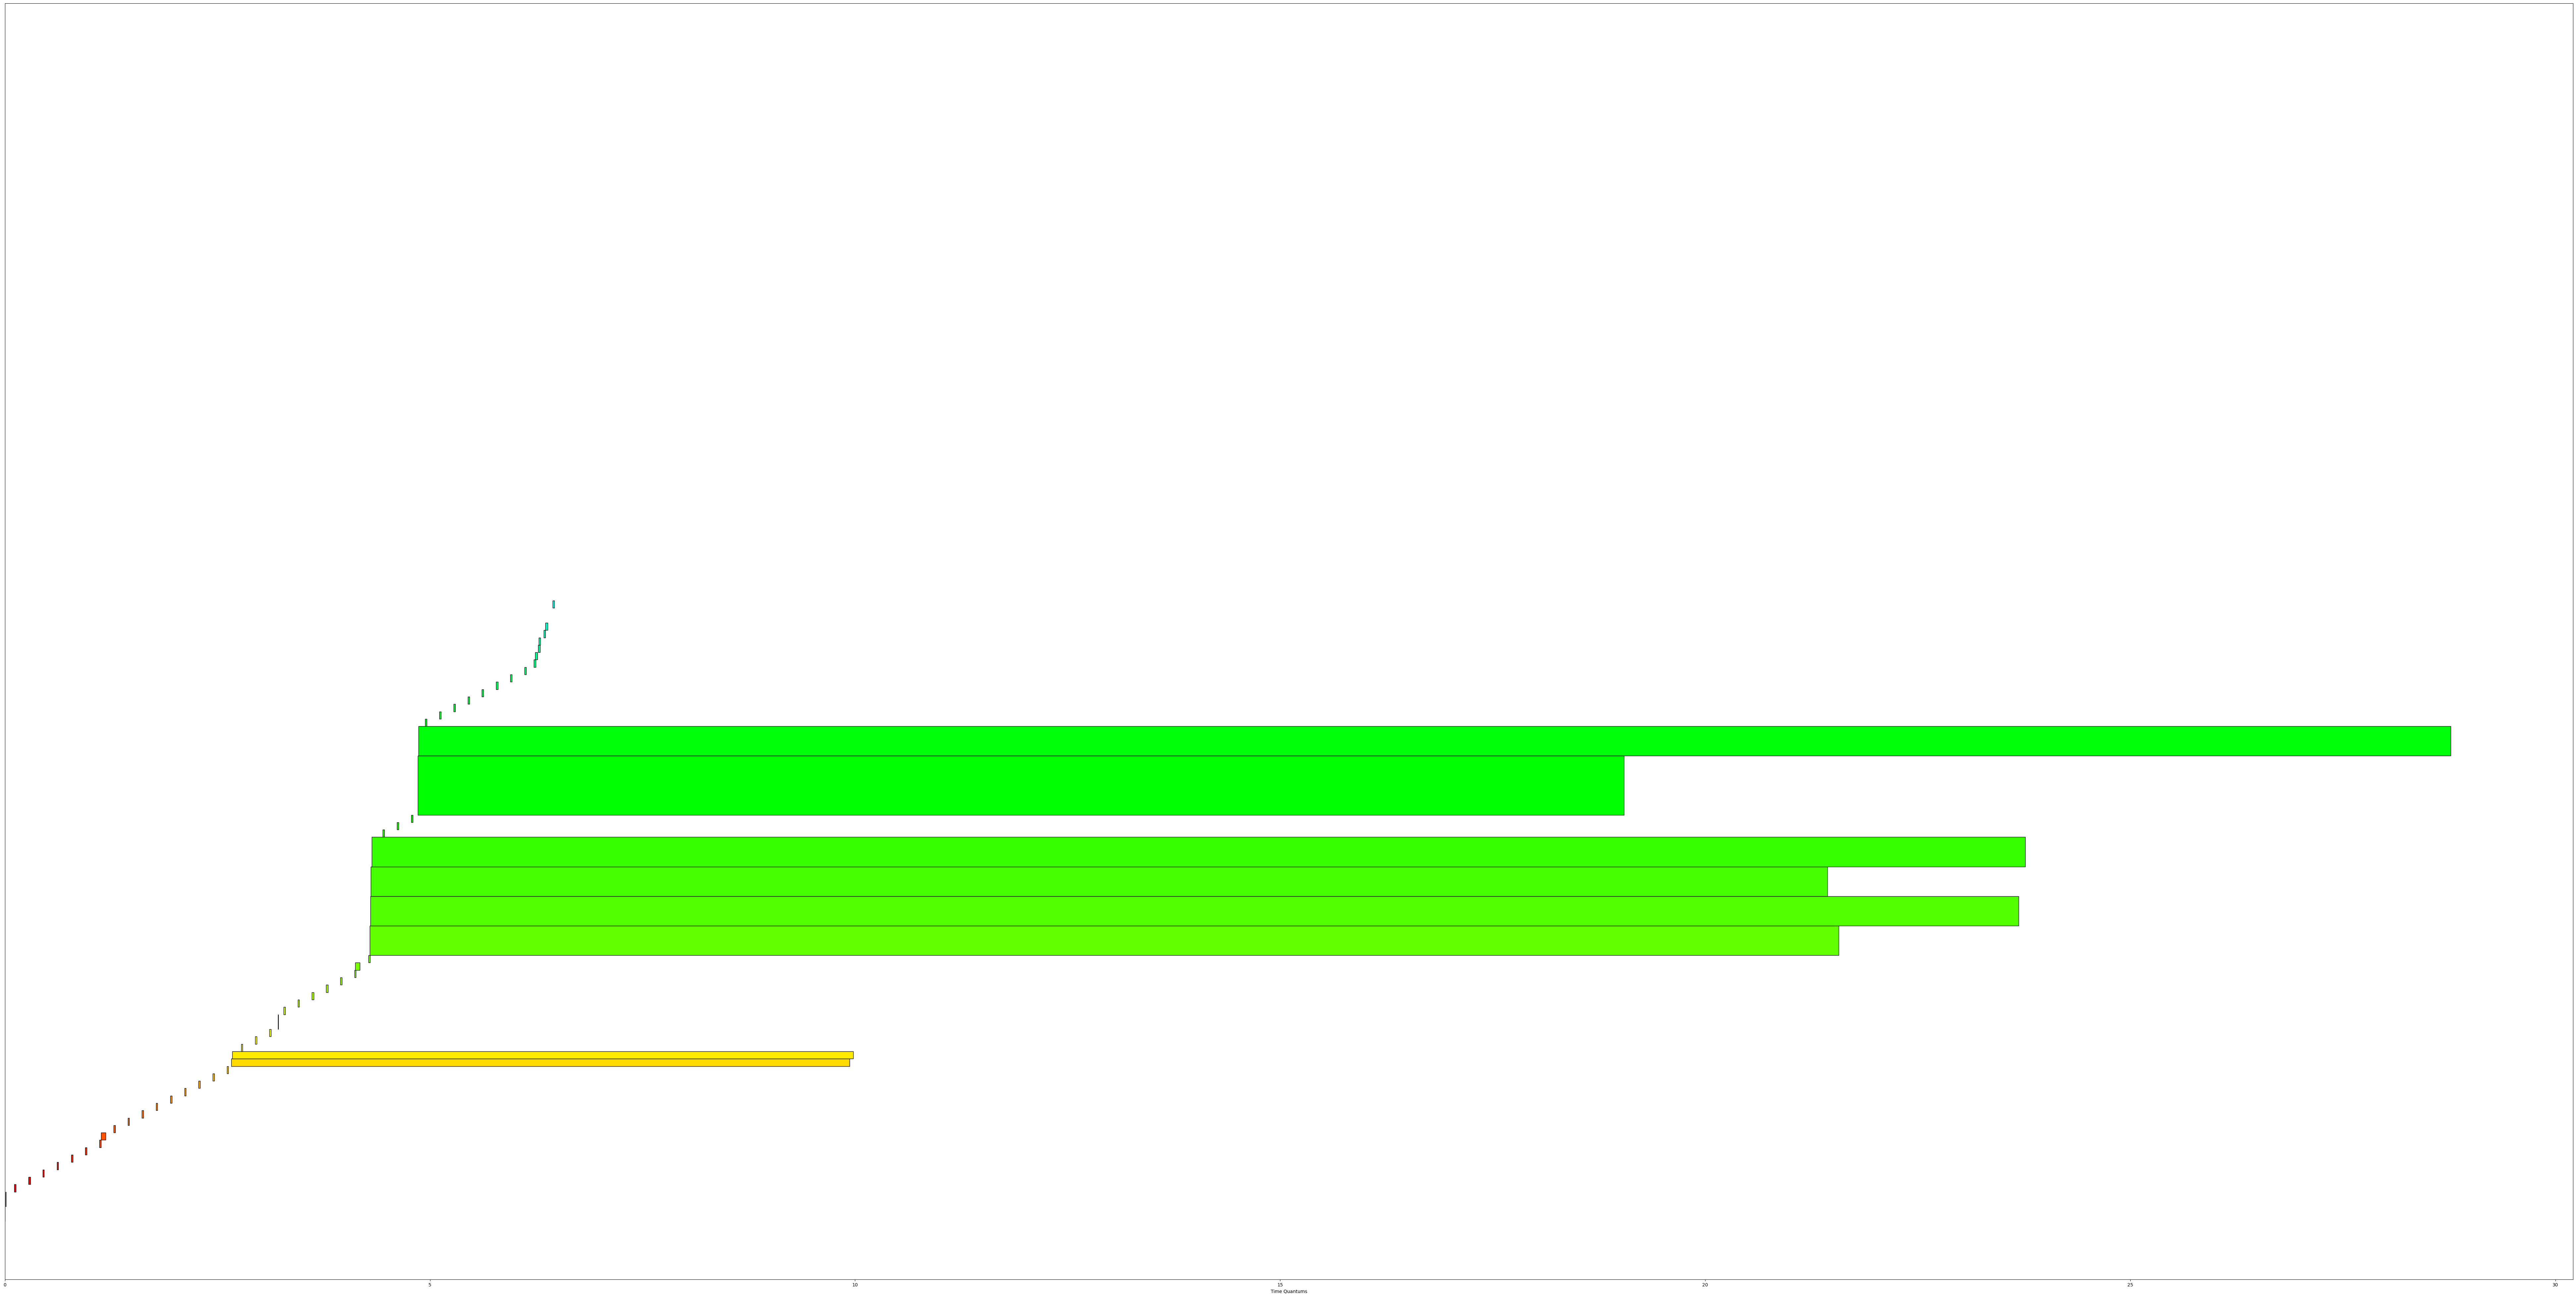

lvjf-cloud


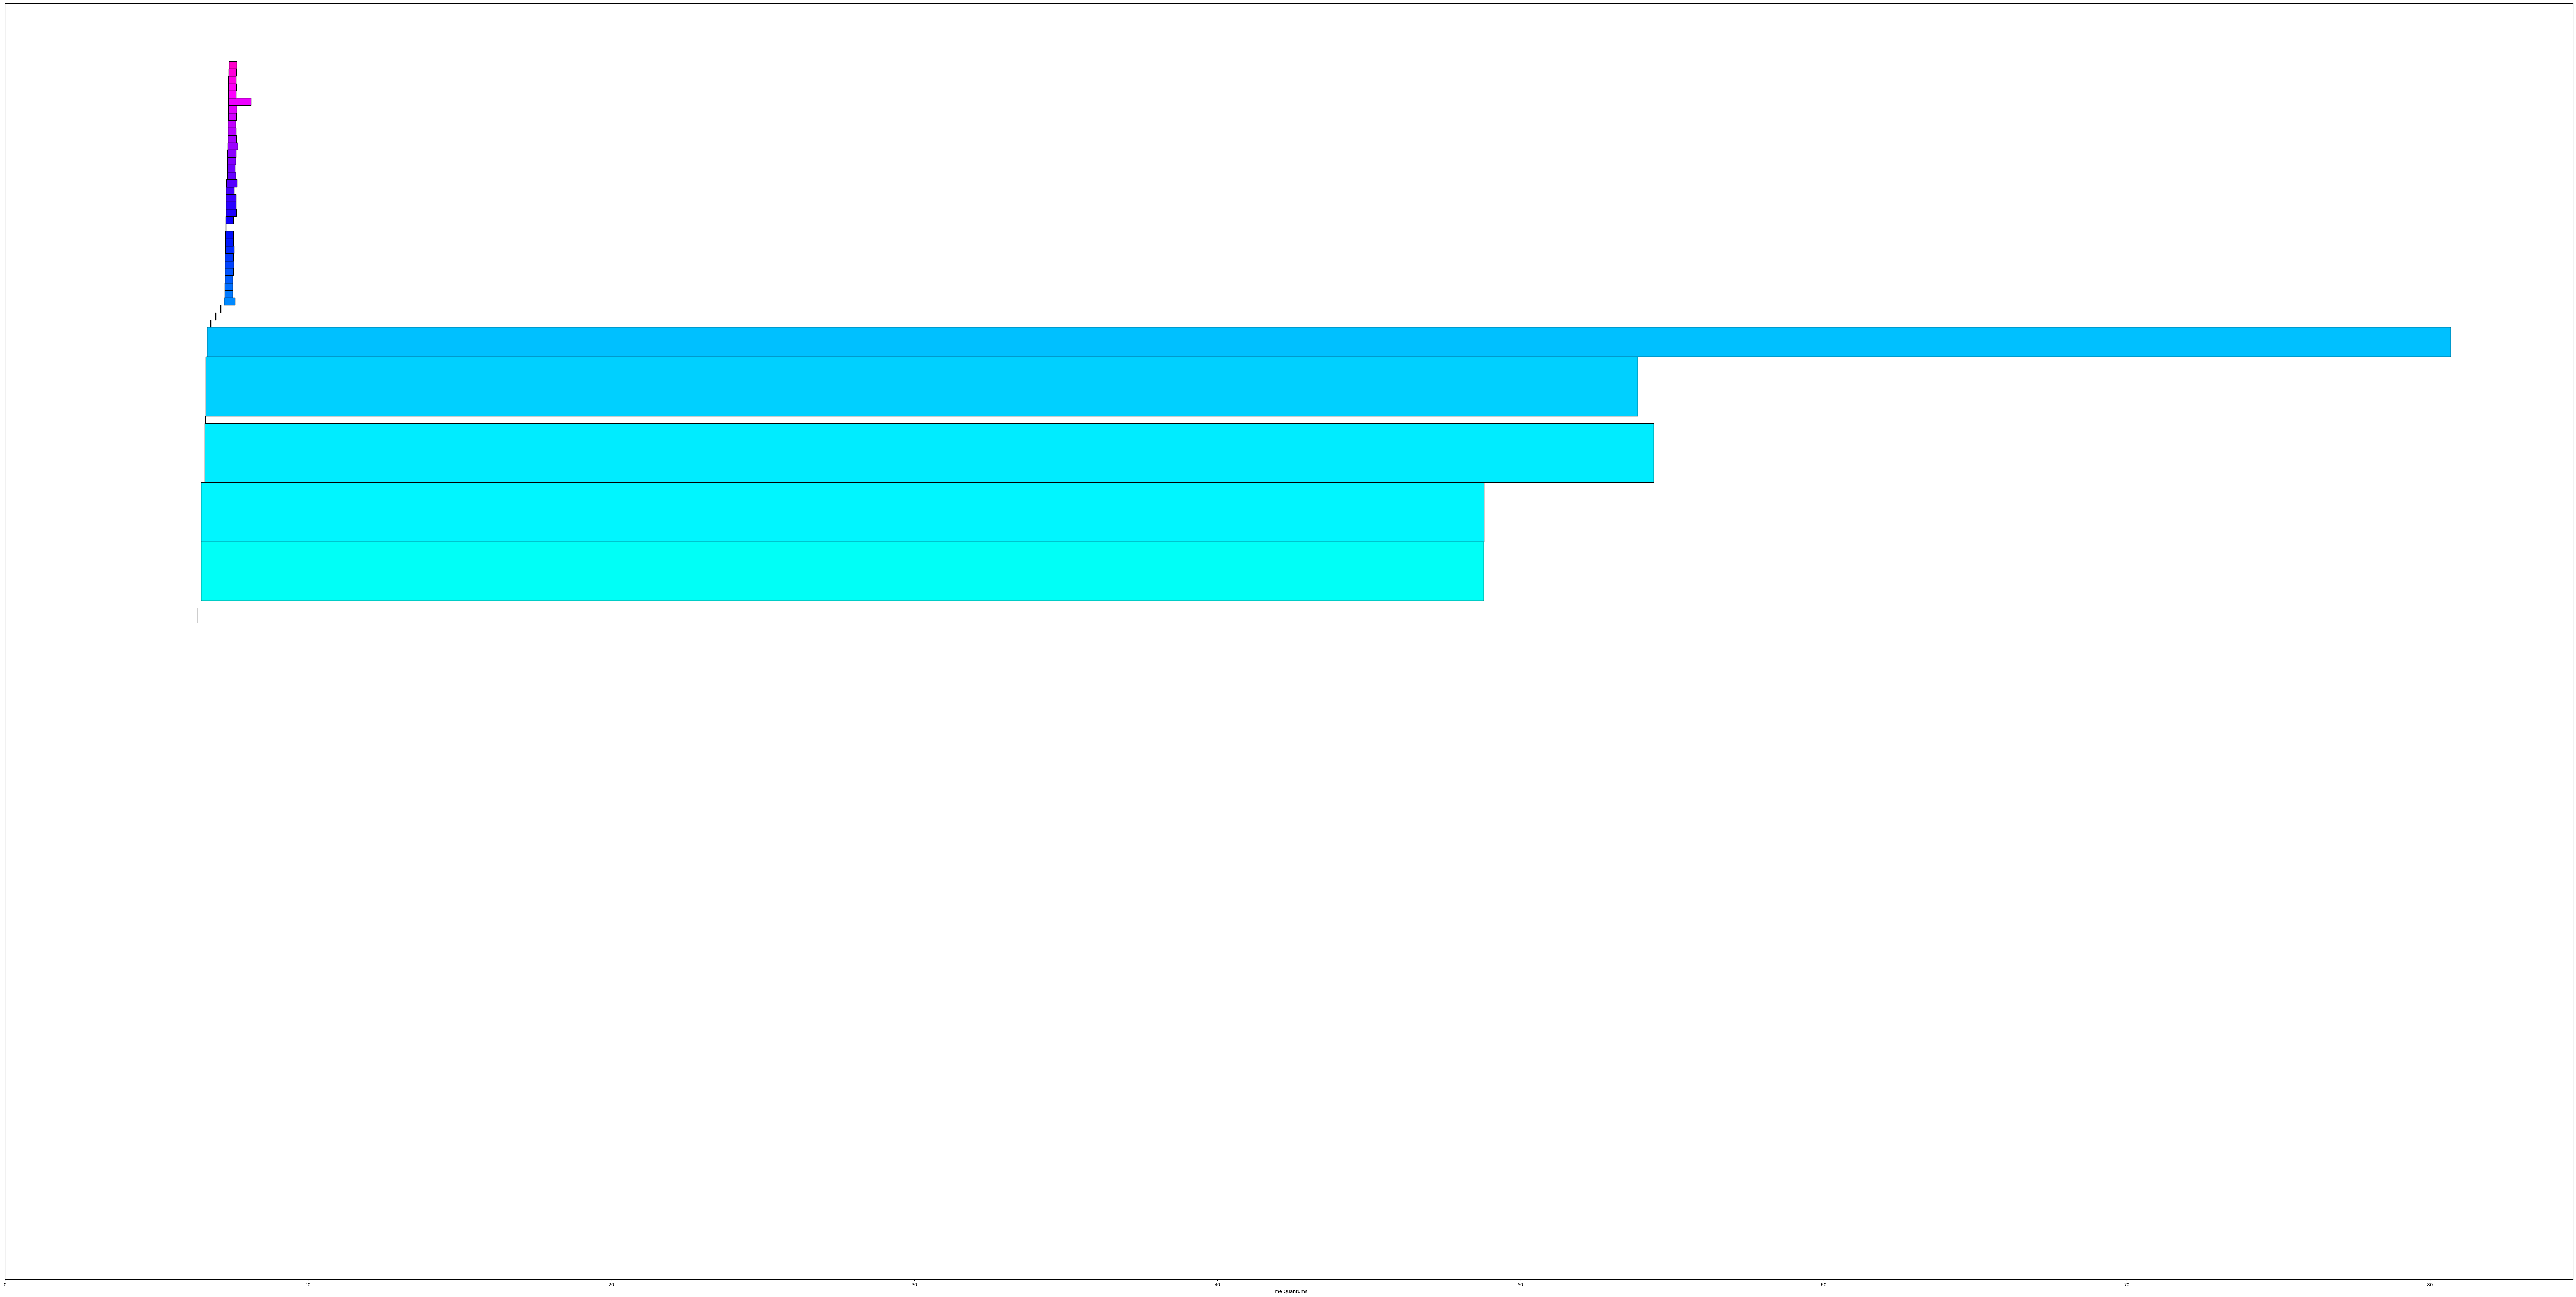

lvjf-local


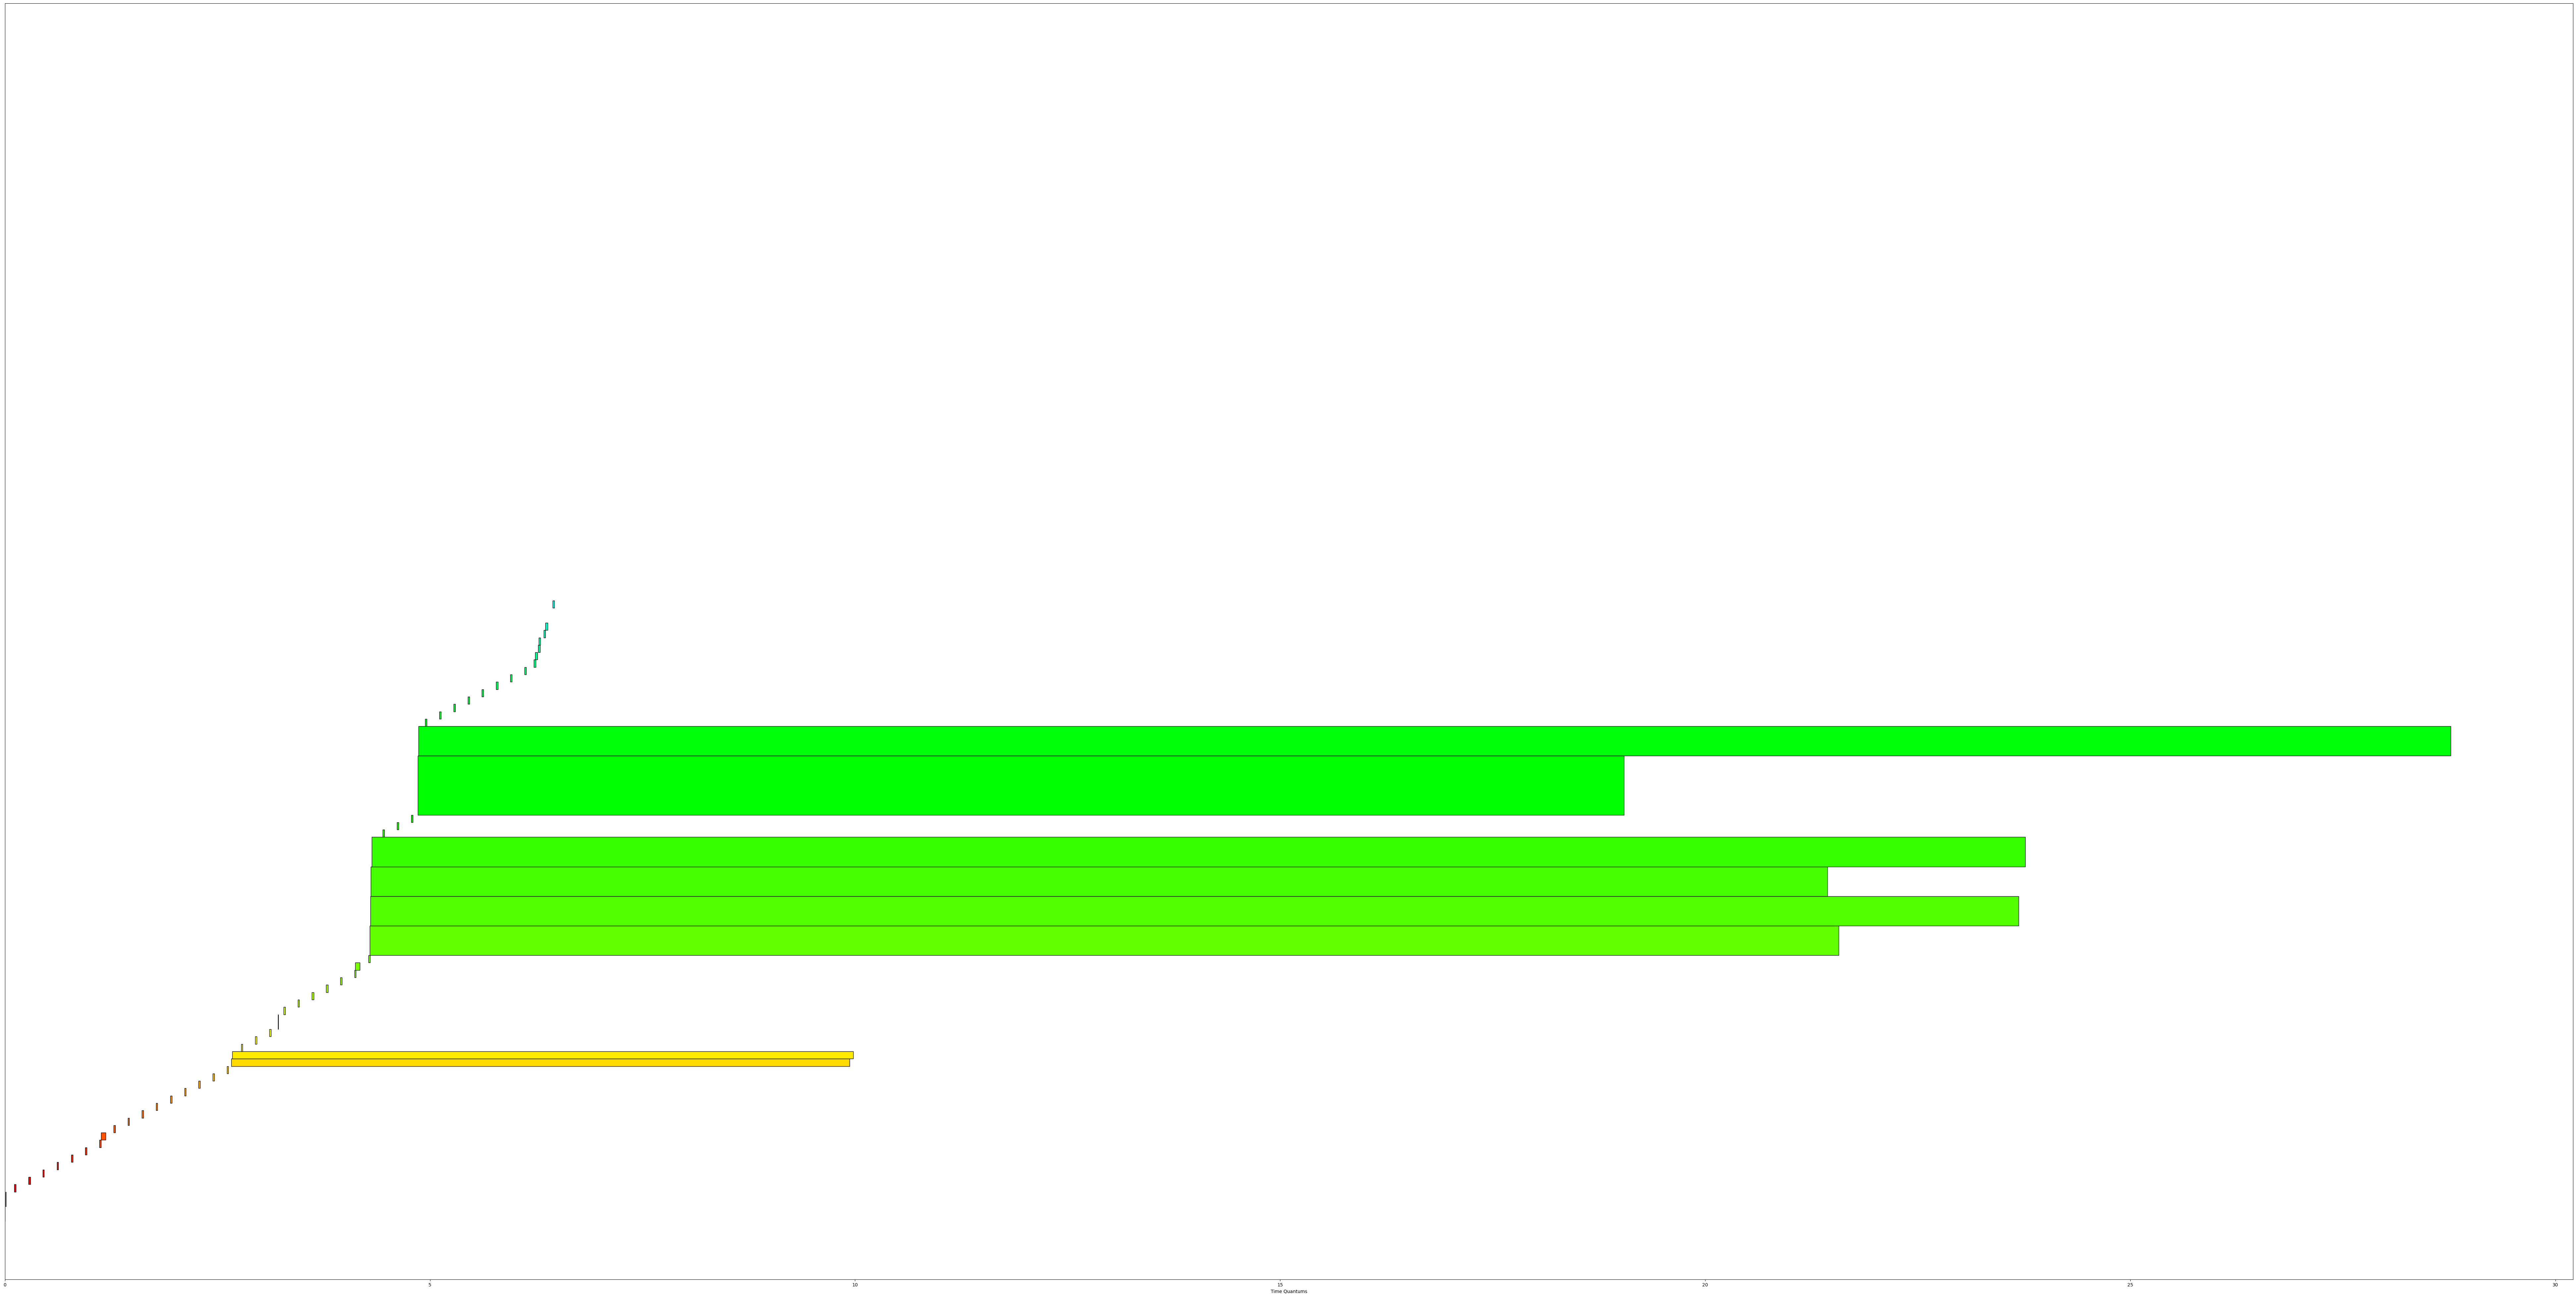

In [14]:
print('all')
plot_qjob_runtimes(results['fifo'][1], mode='all')
for alg in algs:
    for job_filter in ['cloud', 'local']:
        print(f'{alg}-{job_filter}')
        plot_qjob_runtimes(results[alg][1], mode=job_filter)

fifo


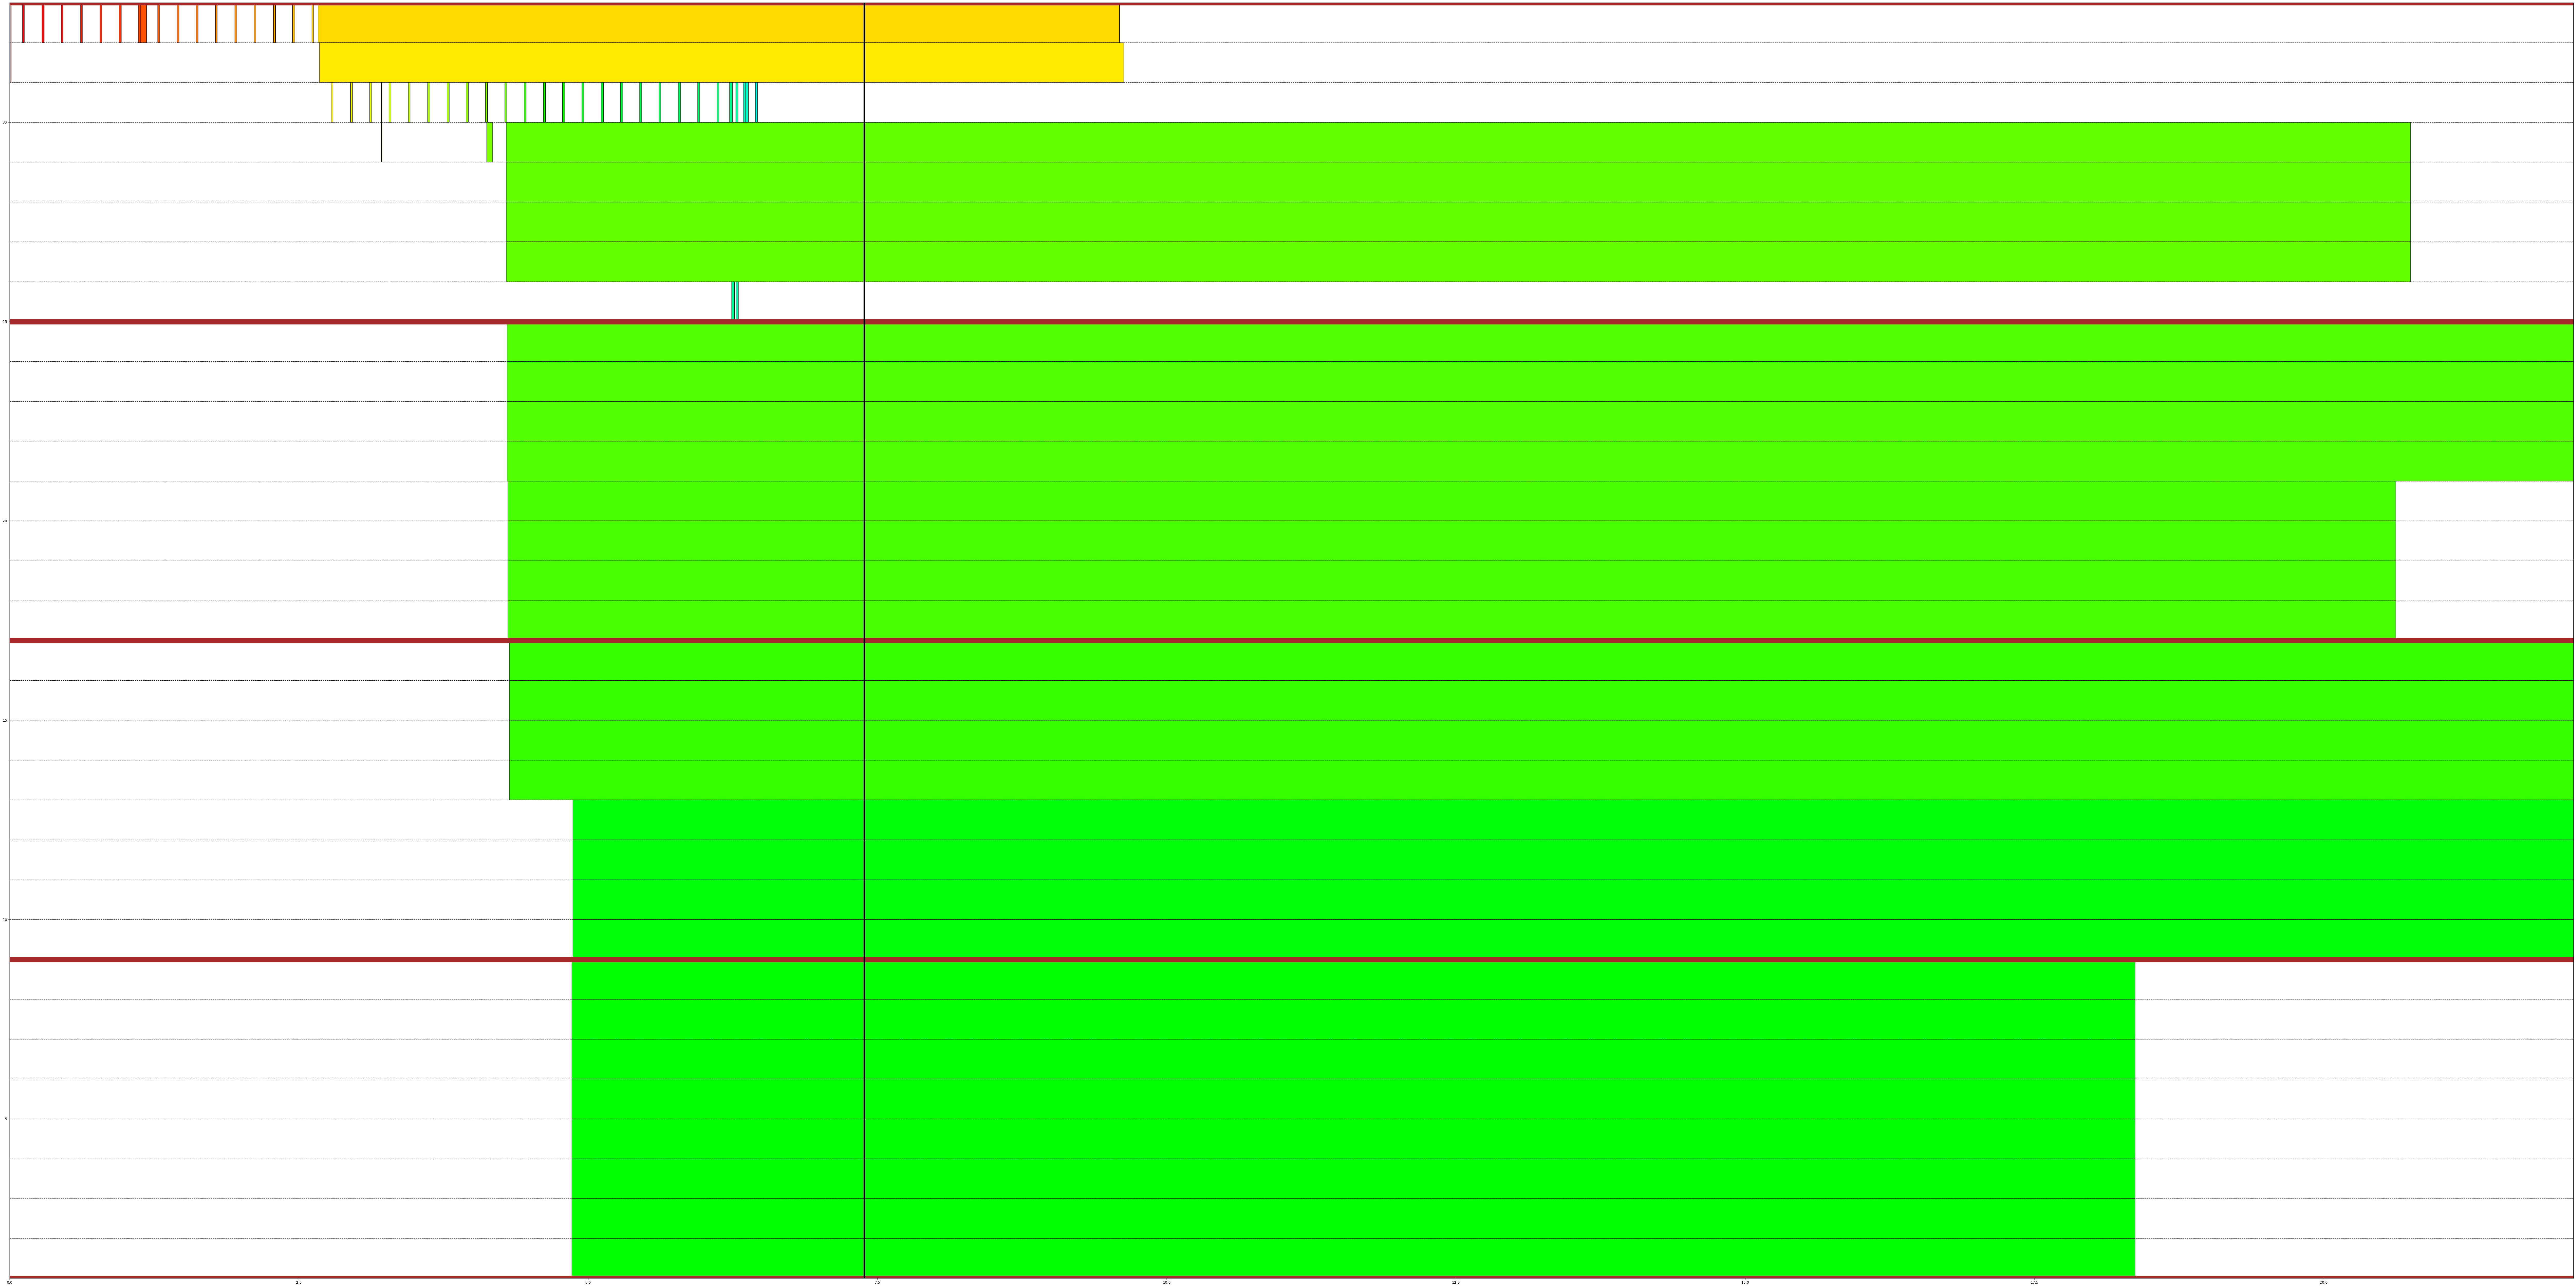

edf


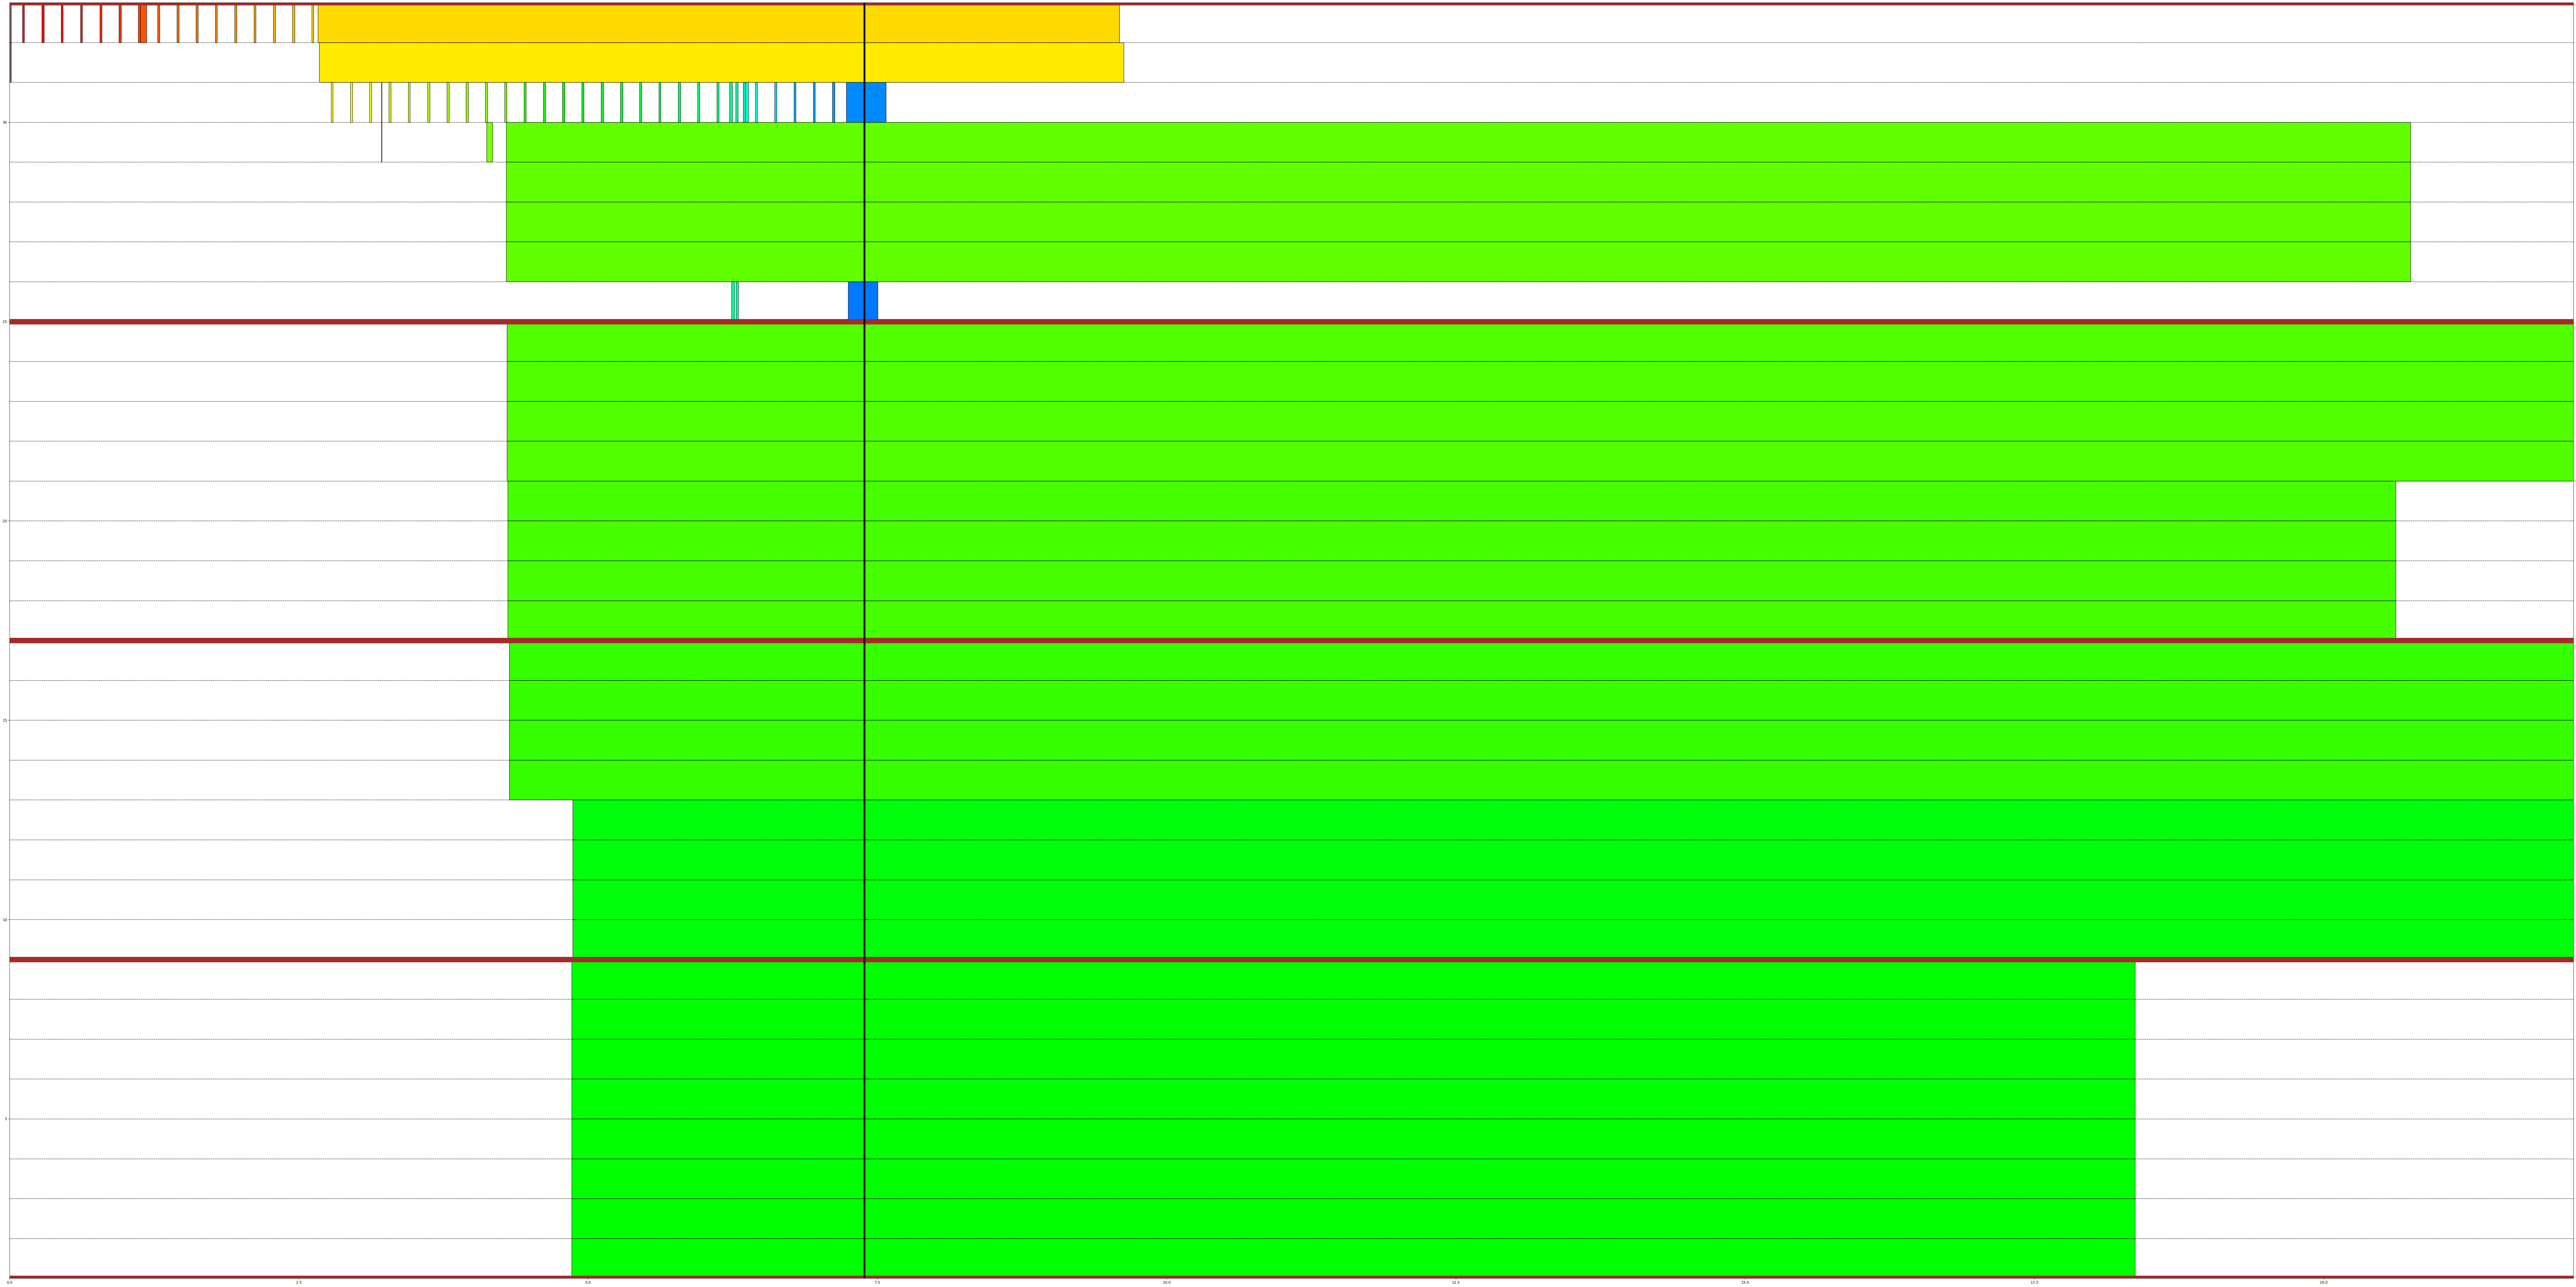

ljf


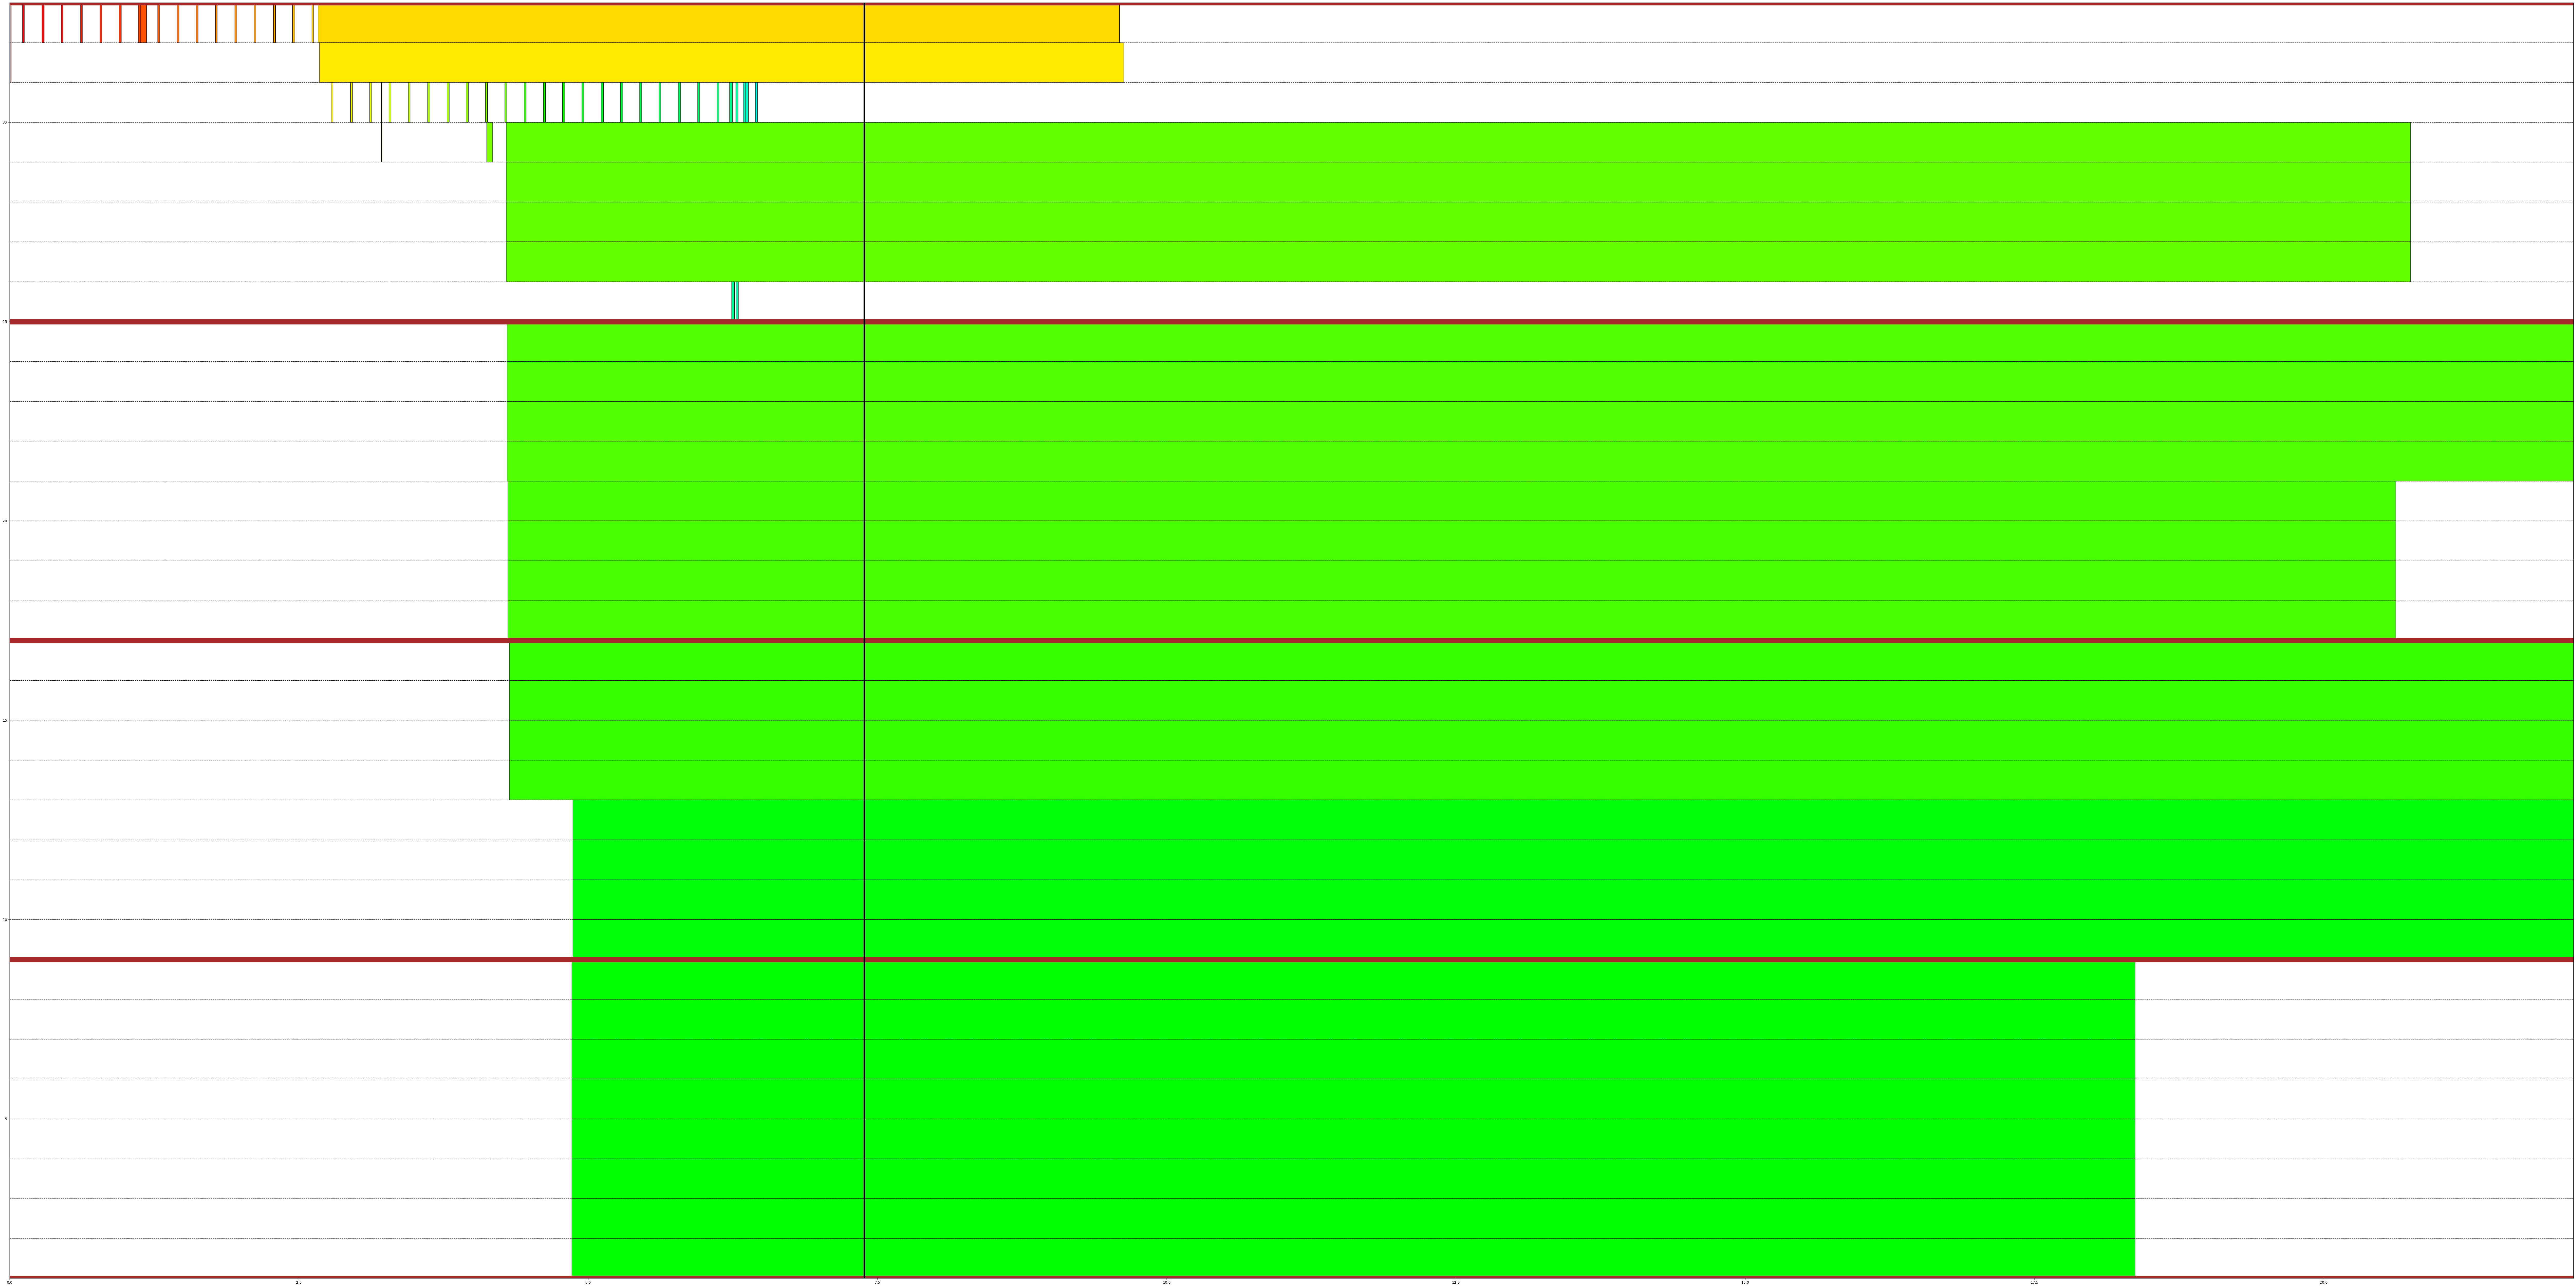

lvjf


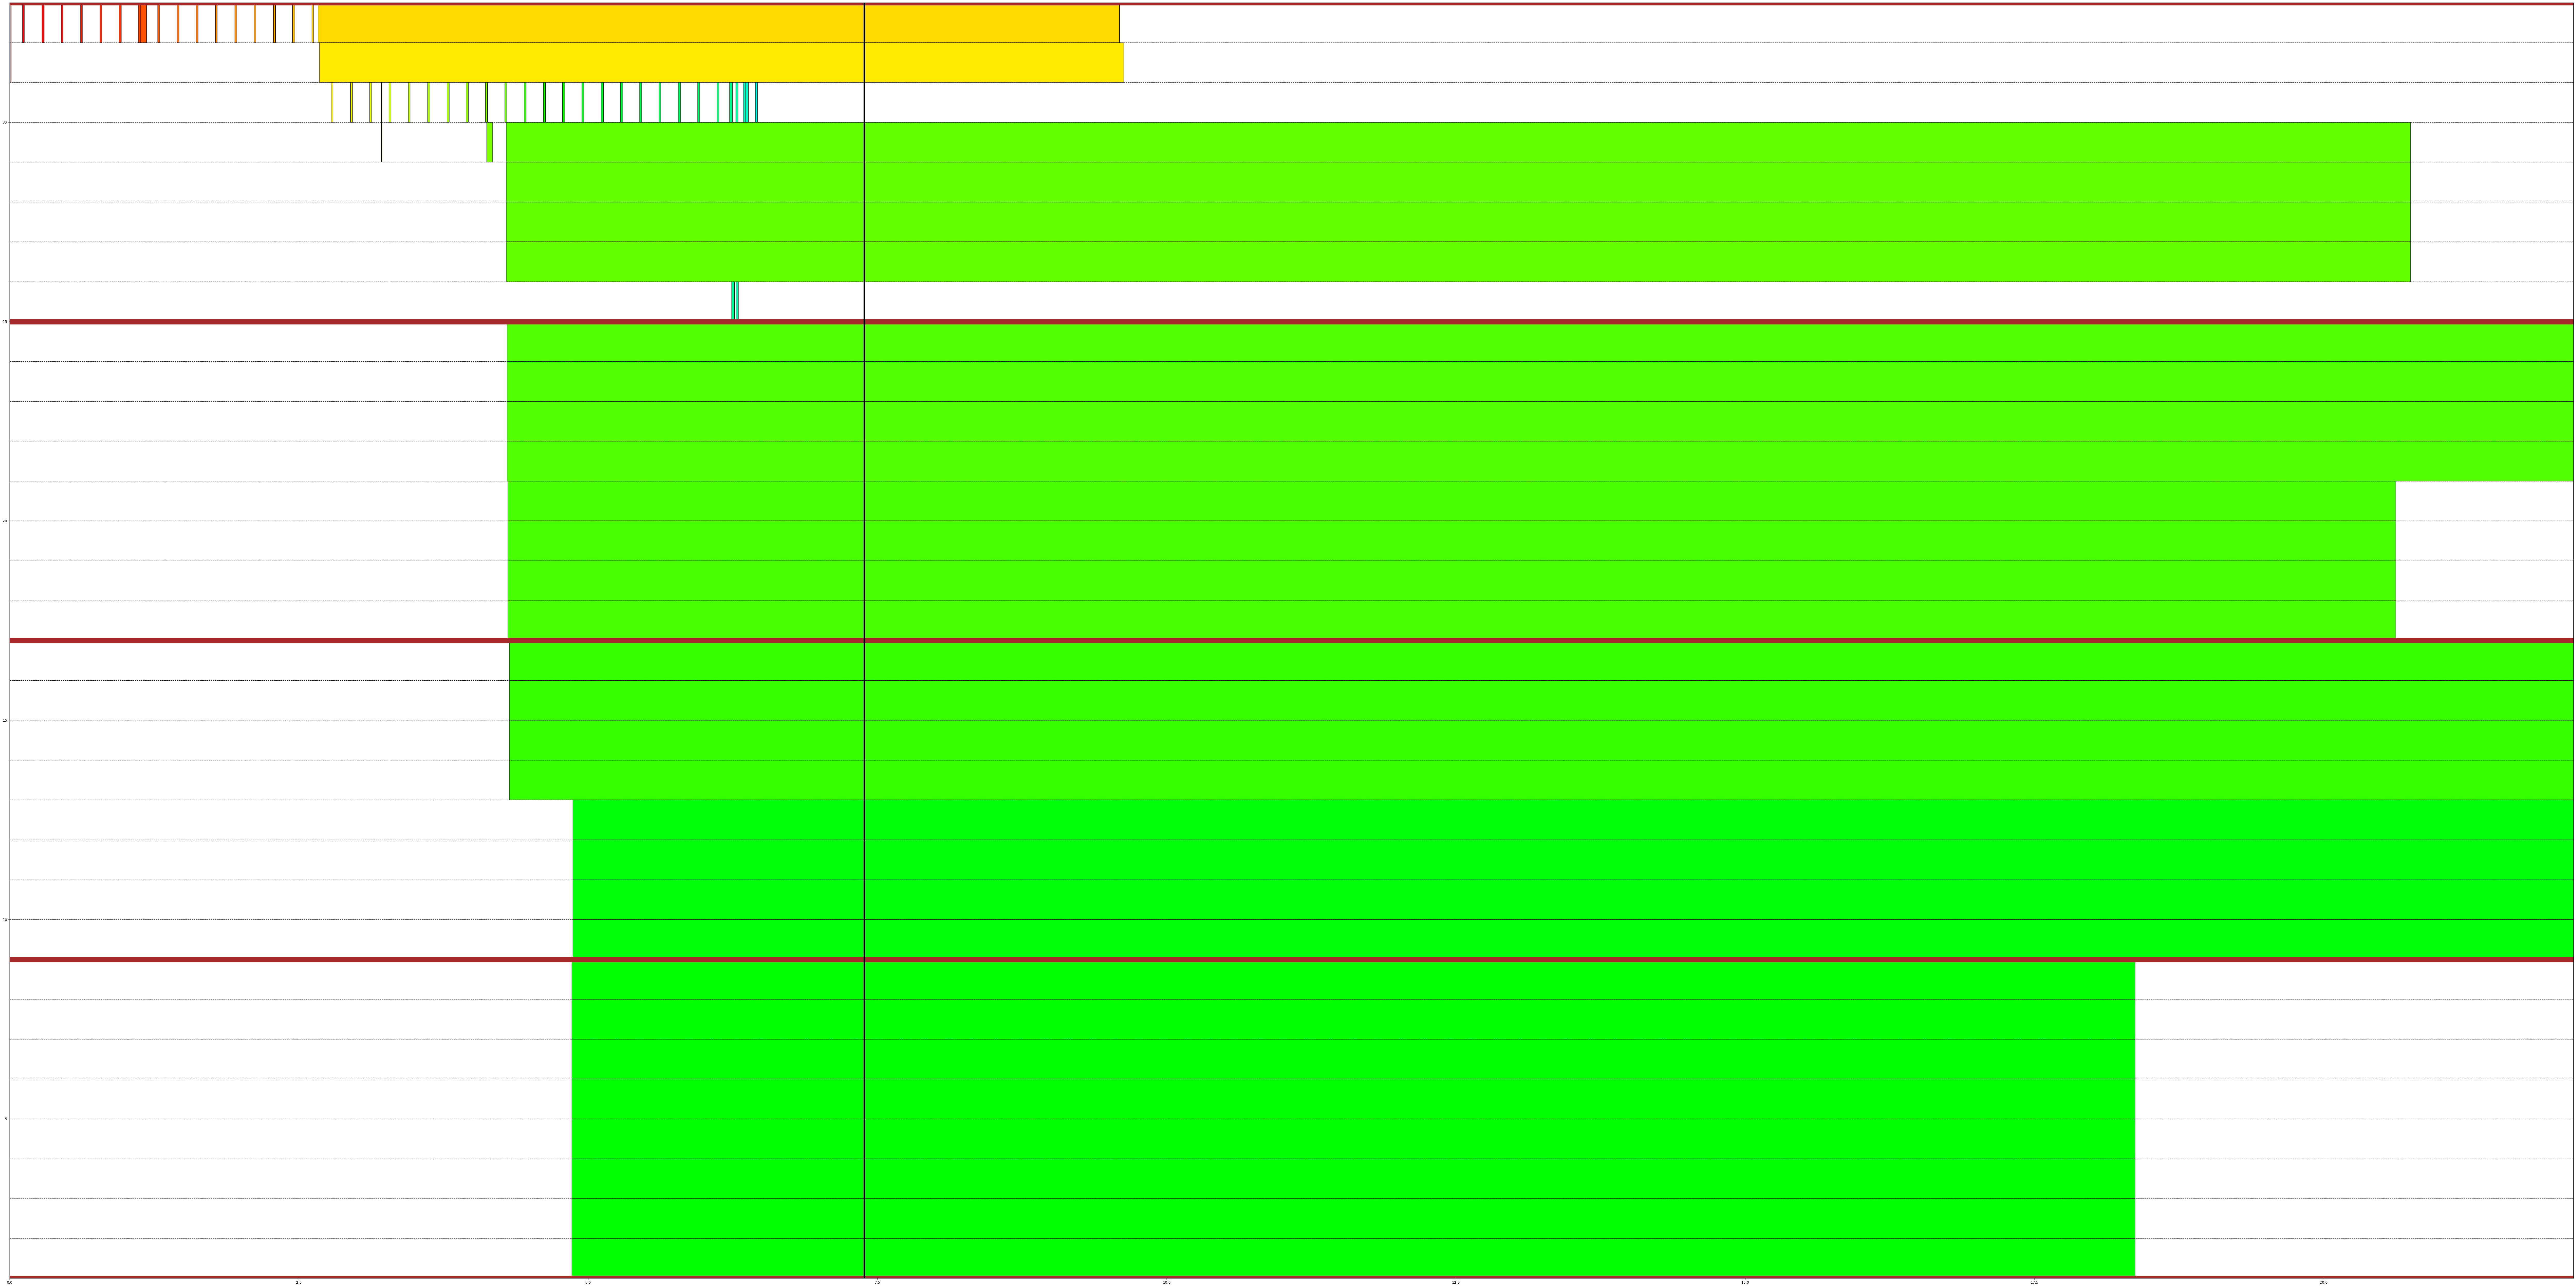

In [61]:
from matplotlib.colors import ListedColormap, BoundaryNorm

def quantized_gpu_traces(jobs: List[Job]):
    jobs = jobs.copy()
    NUM_COLORS = len(jobs)
    cm = plt.get_cmap('gist_rainbow')
    colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    jobs.sort(key=lambda x: x.idx)
    fig, ax = plt.subplots(figsize=(100,50))
    total_gpus = NUM_NODES * GPUS_PER_NODE
    for j_idx, job in enumerate(jobs):
        allocated_gpus = job.allocated_gpus
        if not allocated_gpus:
            continue
        for node_idx in allocated_gpus.keys():
            for node_gpu_idx in allocated_gpus[node_idx]:
                gpu_idx = total_gpus - (GPUS_PER_NODE * node_idx + node_gpu_idx)
                ax.barh(gpu_idx,
                        width=job.runtime,
                        edgecolor='black',
                        height=1.0,
                        left=job.start,
                        align='edge',
                        color=colors[job.idx])
    for i in range(total_gpus+1):
        if (i+1)%GPUS_PER_NODE==1:
            plt.axhline(y=i+1,linewidth=15, color='brown')
        else:
            plt.axhline(y=i+1,linewidth=1, color='black', linestyle='--')
    plt.ylim(bottom=1, top=total_gpus+1)
    plt.xlim(right=3*max([j.arrival for j in jobs]))
    plt.axvline(x=max([j.arrival for j in jobs]), color='black', linewidth=5)
    plt.tight_layout()
    plt.show()

for alg in algs:
    print(alg)
    quantized_gpu_traces(results[alg][1])

In [ ]:
def milp_solver_v3(jobs: List[Job]):
    import cvxpy
    import numpy as np
    bin_width = GPUS_PER_NODE
    bin_height = 1e6
    num_jobs = len(jobs)
    arrivals = np.array([j.arrival for j in jobs])
    runtimes = np.array([j.runtime for j in jobs])
    deadlines = np.array([j.deadline for j in jobs])
    num_gpus = []
    num_nodes = []
    costs = []
    for j in jobs:
        gpus = j.num_gpus
        if gpus > bin_width:
            assert gpus % bin_width == 0
            num_nodes.append(int(gpus/bin_width))
            num_gpus.append(bin_width)
            costs.append(j.cost/int(gpus/bin_width))
        else:
            num_nodes.append(1)
            num_gpus.append(gpus)
            costs.append(j.cost)
    
    num_gpus = np.array(num_gpus)
    num_nodes = np.array(num_nodes)
    costs = np.array(costs).reshape((num_jobs, 1))
    
    
    
    left = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    bottom = cvxpy.Variable((num_jobs, num_jobs), boolean=True)
    selection =  cvxpy.Variable((NUM_NODES, num_jobs), boolean=True)
    x_w = cvxpy.Variable((num_jobs,), integer=True)
    y_h = cvxpy.Variable((num_jobs,))
    all_or_nothing = cvxpy.Variable((num_jobs,), boolean=True)
    
    constraints = []
    
    # Restriction on X,Y coordinates
    constraints.append(x_w >= 0)
    constraints.append(x_w <= bin_width - num_gpus)
    constraints.append(y_h >= arrivals)
    constraints.append(y_h <=deadlines - runtimes)
    
    # Restriction on selection
    constraints.append(cvxpy.sum(selection, axis=0) == cvxpy.multiply(num_nodes, all_or_nothing))
    
    # Restriction on Boxes not intersecting
    triangle_filter = 100*np.triu(np.ones((num_jobs, num_jobs)))
    var_filter = triangle_filter + left + left.T + bottom + bottom.T 

    # Add constraints for each node boxes
    for n_idx in range(NUM_NODES):
        row = selection[n_idx]
        outer_sum = cvxpy.reshape(row, (num_jobs, 1)) + cvxpy.reshape(row, (1, num_jobs))
        constraints.append(var_filter + (2 - outer_sum) >=1)

    eq_1 = cvxpy.reshape(x_w + num_gpus, (num_jobs, 1)) - cvxpy.reshape(x_w, (1, num_jobs)) + bin_width * left <= bin_width 
    eq_2 = cvxpy.reshape(y_h + runtimes, (num_jobs, 1)) - cvxpy.reshape(y_h, (1, num_jobs)) + bin_height * bottom <= bin_height
    constraints.append(eq_1)
    constraints.append(eq_2)
    # Our total utility is the sum of the item utilities
    total_utility = cvxpy.sum(selection@costs)

    super_problem = cvxpy.Problem(cvxpy.Maximize(total_utility), constraints)

    # Solving the problem
    opts = {'limits/time' : 600, 'parallel/minnthreads': 8, 'parallel/maxnthreads': 32} #{'maxiters' : 5000}
    super_problem.solve(solver=cvxpy.SCIP, verbose=True, scip_params = opts)

    # Restriction on intersections
    return (left, bottom, selection, x_w, y_h, all_or_nothing)

variables  = milp_solver_v3(jobs_proc)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Jan 31 11:39:32 PM: Your problem has 20700 variables, 11 constraints, and 0 parameters.
(CVXPY) Jan 31 11:39:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 31 11:39:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 31 11:39:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 31 11:39:32 PM: Compiling problem (target solver=SCIP).
(CVXPY) Jan 31 11:39:32 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

0 + 2 + {1: [0, 1]}
1 + 2 + {3: [0, 1]}
2 + 1 + {3: [0]}
3 + 1 + {3: [0]}
4 + 1 + {3: [0]}
5 + 1 + {3: [0]}
6 + 1 + {3: [0]}
7 + 1 + {2: [0]}
8 + 1 + {3: [0]}
9 + 1 + {3: [0]}
10 + 1 + {1: [0]}
11 + 1 + {3: [0]}
12 + 1 + {2: [0]}
13 + 1 + {2: [0]}
14 + 1 + {3: [0]}
15 + 1 + {3: [0]}
16 + 1 + {2: [0]}
17 + 1 + {3: [0]}
18 + 1 + {3: [0]}
19 + 1 + {0: [7]}
20 + 1 + {0: [4]}
21 + 1 + {3: [0]}
22 + 1 + {3: [0]}
23 + 1 + {0: [0]}
24 + 2 + {1: [0, 1]}
25 + 1 + {0: [0]}
26 + 1 + {0: [0]}
27 + 1 + {0: [0]}
28 + 1 + {0: [0]}
29 + 1 + {0: [0]}
30 + 1 + {1: [0]}
31 + 1 + {1: [7]}
32 + 1 + {0: [0]}
37 + 1 + {0: [0]}
38 + 1 + {0: [0]}
39 + 1 + {0: [0]}
41 + 4 + {0: [0, 1, 2, 3]}
42 + 1 + {0: [0]}
43 + 1 + {3: [7]}
44 + 1 + {0: [6]}
45 + 1 + {1: [7]}
46 + 1 + {1: [7]}
47 + 1 + {0: [6]}
48 + 1 + {1: [7]}
49 + 1 + {1: [7]}
50 + 1 + {1: [7]}
51 + 1 + {0: [6]}
52 + 1 + {2: [7]}
53 + 1 + {0: [6]}
54 + 1 + {3: [0]}
55 + 1 + {1: [5]}
56 + 2 + {1: [6, 7]}
57 + 1 + {1: [7]}
59 + 8 + {2: [0, 1, 2, 3, 4, 5, 6, 

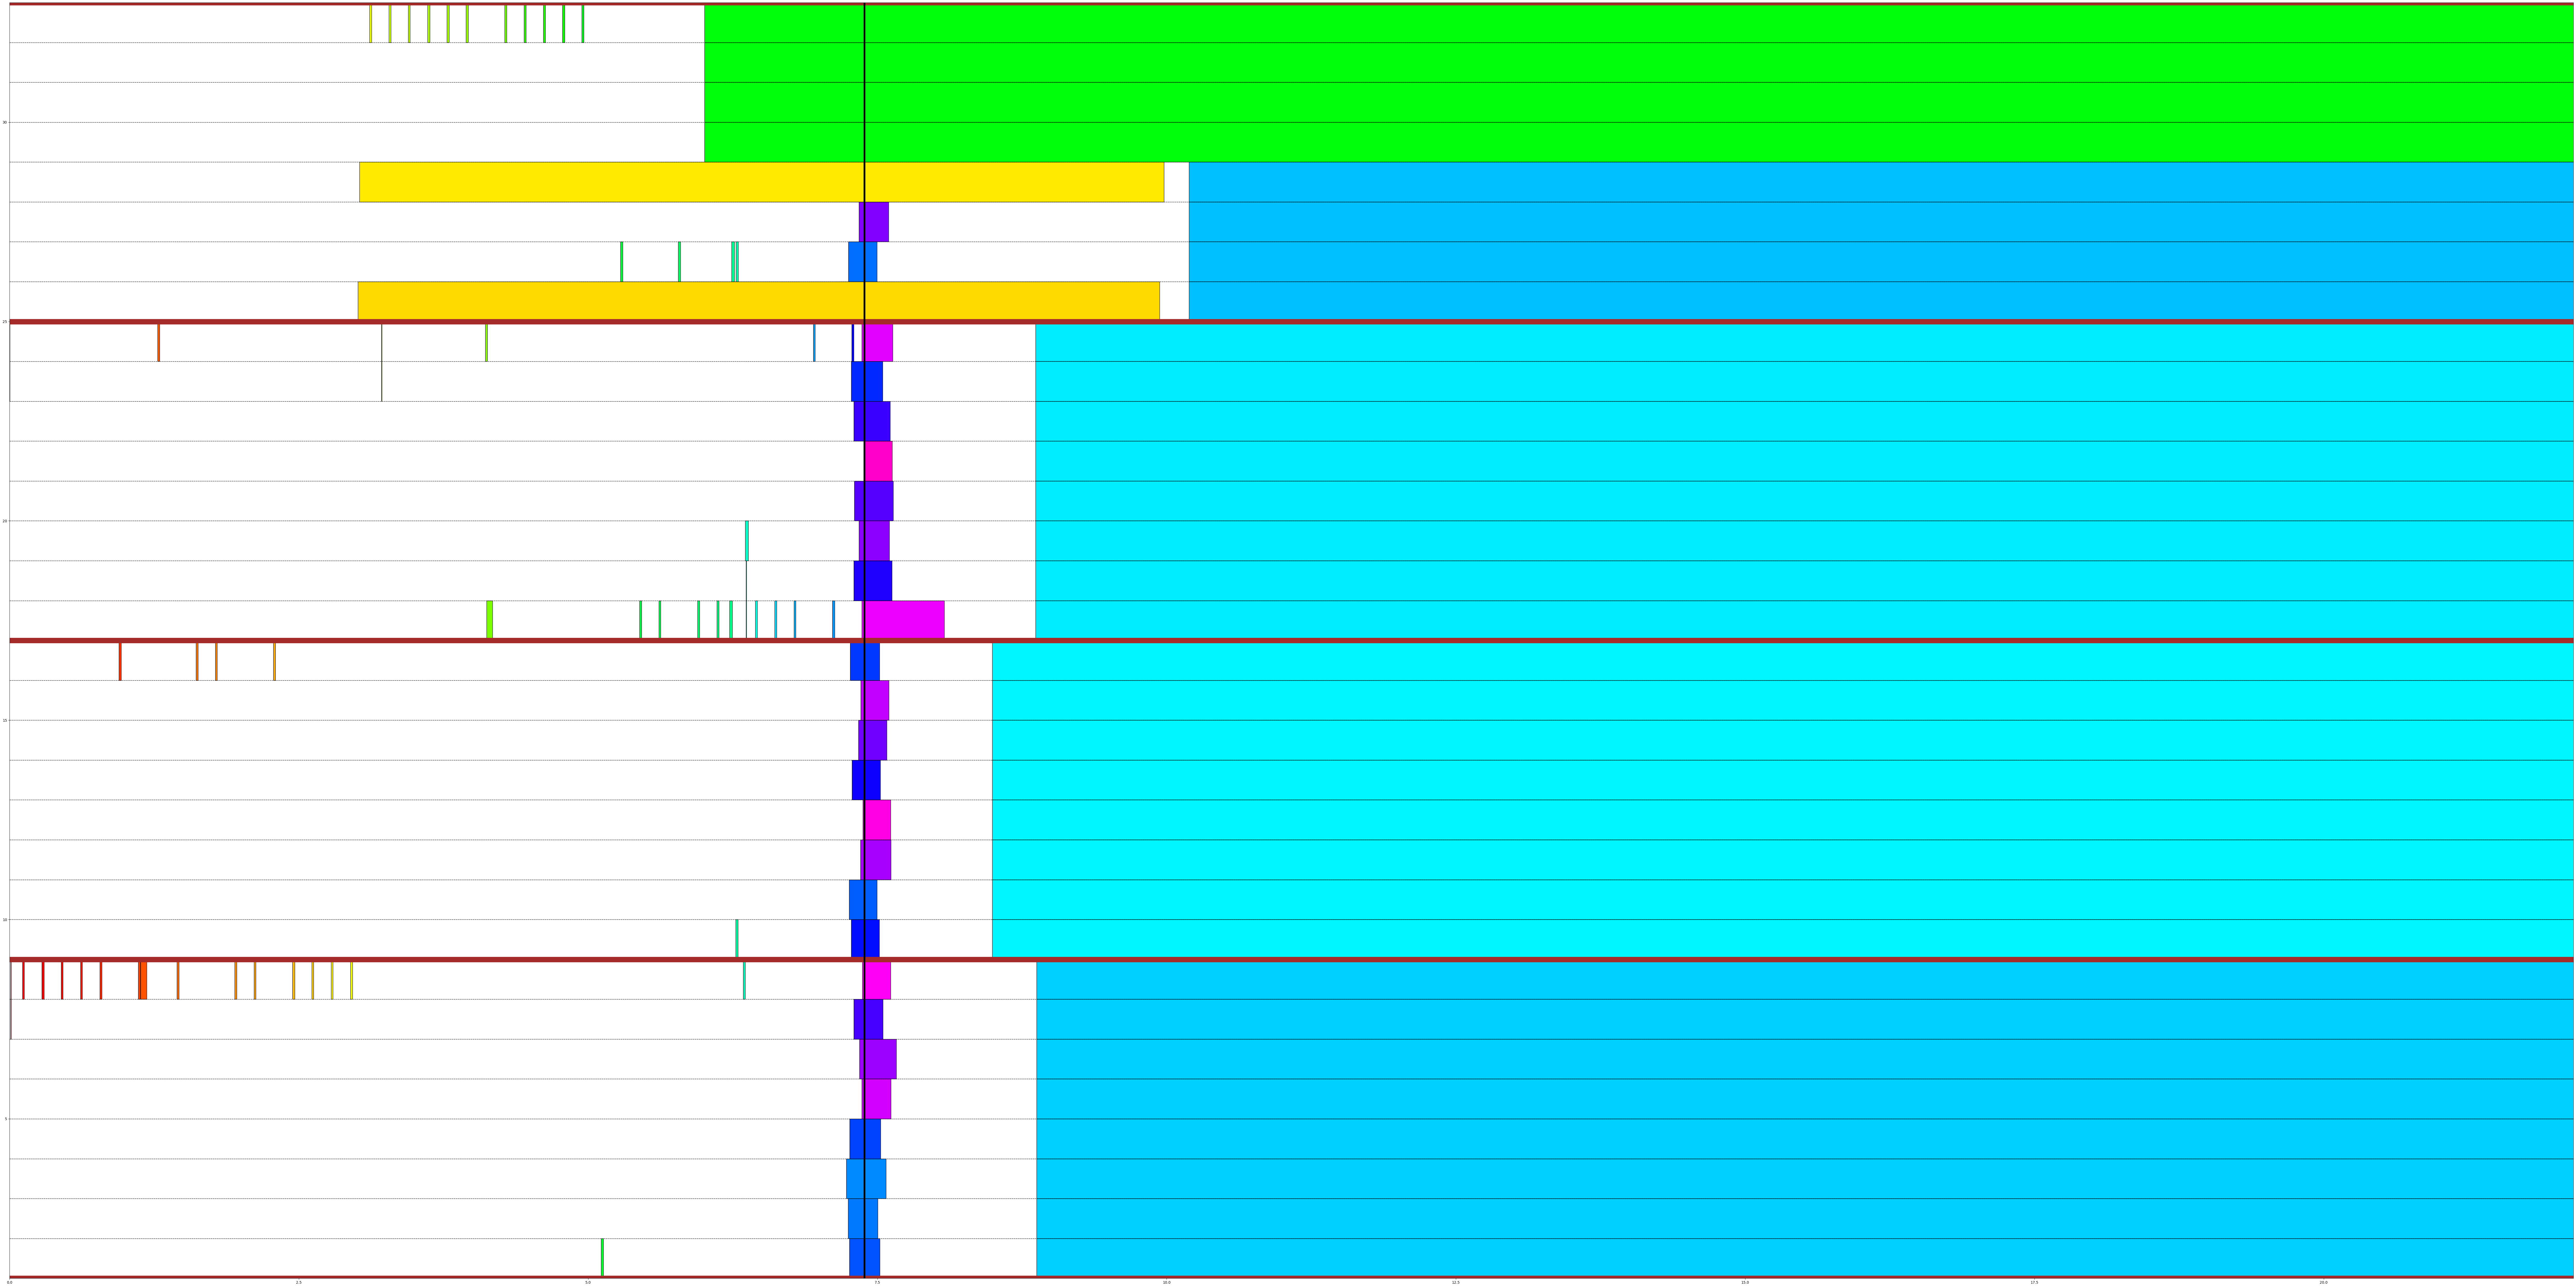

In [62]:
left, bottom, selection, x_w, y_h, all_or_nothing = variables

copy_jobs = copy.deepcopy(jobs_proc)
copy_jobs.sort(key=lambda x: x.idx)


gpu_values = selection.value
summed_values = np.sum(gpu_values, axis=0)
cloud_cost = 0
for j in copy_jobs:
    idx = j.idx
    if summed_values[idx]==0:
        cloud_cost += j.cost
        continue
    j.start = y_h.value[idx]
    #print(gpu_values[:,idx])
    for gpu_idx, gpu_v in enumerate(gpu_values[:,idx]):
        if gpu_v ==1:
            j.allocated_gpus[gpu_idx] = list(range(int(x_w.value[idx]), int(x_w.value[idx]) + j.num_gpus))    
    print(f'{idx} + {j.num_gpus} + {j.allocated_gpus}')
print(cloud_cost)
quantized_gpu_traces(copy_jobs)

In [42]:
print(selection.value.shape)

(4, 100)


In [ ]:
for job_filter in ['local', 'cloud']:
    print(f'MILP-{job_filter}')
    plot_qjob_runtimes(copy_jobs, mode=job_filter)

[-0.00000000e+00  7.50000000e-03  1.11388889e-01  2.78055556e-01
  4.44722222e-01  6.11388889e-01  7.78333333e-01  9.44722222e-01
  1.11138889e+00  1.13180556e+00  1.27805556e+00  1.44472222e+00
  1.61138889e+00  1.77805556e+00  1.94472222e+00  2.11138889e+00
  2.27805556e+00  2.44472222e+00  2.61138889e+00  3.01079167e+00
  3.02300000e+00  2.77805556e+00  2.94472222e+00  3.11138889e+00
  3.21305556e+00  3.27805556e+00  3.44472222e+00  3.61138889e+00
  3.77805556e+00  3.94472222e+00  4.11138889e+00  4.12222222e+00
  4.27805556e+00  5.11536111e+00  5.22181944e+00  5.12015278e+00
  5.24334722e+00  4.44472222e+00  4.61138889e+00  4.77805556e+00
  5.53420833e+00  6.00462500e+00  4.94472222e+00  5.11138889e+00
  5.27805556e+00  5.44472222e+00  5.61138889e+00  5.77833333e+00
  5.94472222e+00  6.11138889e+00  6.22222222e+00  6.23861111e+00
  6.27388889e+00  6.27805556e+00  6.33972222e+00  6.35750000e+00
  6.36361111e+00  6.44472222e+00  8.48334722e+00  8.49236111e+00
  8.86675000e+00  6.61166

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
print(np.sum())